In [8]:
%matplotlib inline

# IMAGE PRE-PROCESSING

6179,6046 gives error because they match but dont have the same z stack depth

5878 has another subject (musc), some has vaso2 others have vaso 2

4092 which is MSA is also stored in a control image dont know why, be carefull to remove it manually

## version producing 3channel rgb images

In [ ]:
# new version to save also png images
from readlif.reader import LifFile
from IPython.display import display
import pandas as pd
import numpy as np
import os
import re
import tifffile
import numpy as np
#import cv2
import matplotlib.pyplot as plt


def parse_name(name):
    # print(f"Parsing name: {name}") #uncomment to see all names that are parsed
    id_match = re.search(r"(\d{4})", name)
    subject_match = re.search(r"\b(gh(?:\s*n?\s*\d)?)\b", name, re.IGNORECASE) #recognize gh, gh 2, gh x, gh n x, ghnx
    # recgonize gh2, gh 2, gh
    if id_match and subject_match:
        id_ = id_match.group(1)
        subject = subject_match.group(1).lower()
        # print(f"Extracted ID: {id_}, Subject: {subject}") #uncomment to see all the IDs and Subjects extracted
        return id_, subject
    # print("ID or Subject not found") #uncomment to see all the names that don't match the criteria
    return None, None

def normalize_channel(channel_data):
    """
    performs a min-max normalization of the channel_data to the 0-255 range and converts it to uint8
    """
    min_val = np.min(channel_data)
    max_val = np.max(channel_data)
    
    if max_val - min_val == 0:
        # Handle cases where the channel has a constant value
        normalized_channel = np.zeros_like(channel_data, dtype=np.uint8)
    else:
        normalized_channel = ((channel_data - min_val) / (max_val - min_val) * 255).astype(np.uint8)
    
    return normalized_channel

def create_rgb_projection(image_data, method="max", red_channel=3, green_channel=0, blue_channel=1):
    """
    Creates a 3-channel RGB projection from a multi-channel image.
    without channel normalization""

    Args:
        image_data: NumPy array with shape (Z, Y, X, C) or (C, Y, X) where C is the number of channels.
        method: Projection method ("max" or "mean").
        red_channel: Index of the channel to use for red.
        green_channel: Index of the channel to use for green.
        blue_channel: Index of the channel to use for blue.

    Returns:
        NumPy array with shape (Y, X, 3) representing the RGB projection.
    """
    print(f"input shape before rgb: {image_data.shape}") # (50, 1024, 1024, 4)
    if image_data.ndim == 4:  # (Z, Y, X, C)
        if method == "max":
            projection_func = np.max
        elif method == "mean":
            projection_func = np.mean
        else:
            raise ValueError("Invalid projection method. Choose 'max' or 'mean'.")

        print(f"Creating RGB projection using {method} projection method")
        print(f"image shape: {image_data.shape}")
        # Ensure the selected channels are within the valid range
        num_channels = image_data.shape[3]
        if not all(0 <= c < num_channels for c in [red_channel, green_channel, blue_channel]):
            raise ValueError(f"Invalid channel indices. Image has {num_channels} channels.")

        # Project along the Z-axis for each selected channel
        red_proj = projection_func(image_data[:, :, :, red_channel], axis=0)
        green_proj = projection_func(image_data[:, :, :, green_channel], axis=0)
        blue_proj = projection_func(image_data[:, :, :, blue_channel], axis=0)
        rgb_image = np.stack([red_proj, green_proj, blue_proj], axis=-1) # (Y, X, 3)
    elif image_data.ndim == 3:  # (C, Y, X)
        # No projection needed, just select channels
        num_channels = image_data.shape[0]
        if not all(0 <= c < num_channels for c in [red_channel, green_channel, blue_channel]):
            raise ValueError(f"Invalid channel indices. Image has {num_channels} channels.")
        red_proj = image_data[red_channel, :, :]
        green_proj = image_data[green_channel, :, :]
        blue_proj = image_data[blue_channel, :, :]
        rgb_image = np.transpose(
            np.stack([
                image_data[red_channel],
                image_data[green_channel],
                image_data[blue_channel]
            ]),
            (1, 2, 0)  # From (3, Y, X) to (Y, X, 3)
        )
    else:
        raise ValueError("Invalid image_data shape. Must be either (Z, Y, X, C) or (C, Y, X).")

    # Normalize each channel to 0-255 and convert to uint8
    #red_proj = normalize_channel(red_proj)
    #green_proj = normalize_channel(green_proj)
    #blue_proj = normalize_channel(blue_proj)

    # Stack the channels to create an RGB image
    
    print(f"output shape after rgb projection, should be (X,Y,3): {rgb_image.shape}") #(1024, 1024, 3)

    return rgb_image

#!TODO put dapi overlay to false
def save_colored_mip_png(merged_data, output_path, id_, subject, red_channel=0, green_channel=1, blue_channel=2, dapi_overlay=True):
    """
    Create and save colored Maximum Intensity Projection (MIP) png.
    
    Args:
        merged_data: numpy array with shape (Z, C, Y, X) - Z-stack of multi-channel image data
        output_path: str - base directory for saving output
        id_: str - sample identifier
        subject: str - subject type (e.g., 'MSA', 'PD')
        red_channel: int - index of channel to use for red (default=0)
        green_channel: int - index of channel to use for green (default=1)
        blue_channel: int - index of channel to use for blue (default=2)
        dapi_overlay: bool - whether to overlay DAPI channel (assumed to be channel 3)
    
    Returns:
        str: Path to the saved MIP image
    """
    # Create output directory for colored MIPs if it doesn't exist
    mip_folder = os.path.join(output_path, "Colored_MIPs")
    if not os.path.exists(mip_folder):
        os.makedirs(mip_folder)

    # Get number of channels and validate channel indices
    num_channels = merged_data.shape[1]
    rgb_channels = [red_channel, green_channel, blue_channel]
    if not all(0 <= c < num_channels for c in rgb_channels):
        raise ValueError(f"Invalid channel indices for RGB. Image has {num_channels} channels.")
    if dapi_overlay and num_channels < 4:
        print("Warning: DAPI overlay requested but image has fewer than 4 channels. Skipping DAPI overlay.")
        dapi_overlay = False

    # Create maximum intensity projection for each channel
    mip_channels = [np.max(merged_data[:, c, :, :], axis=0) for c in range(num_channels)]

    # Normalize RGB channels and create composite image
    normalized_channels = [normalize_channel(mip_channels[c]) for c in rgb_channels]
    mip_image = np.zeros((*mip_channels[0].shape, 3), dtype=np.uint8)
    for i, c in enumerate(rgb_channels):
        mip_image[:, :, i] = normalized_channels[i]

    # Add DAPI channel overlay if requested
    if dapi_overlay:
        dapi = normalize_channel(mip_channels[3])
        for i in range(3):
            mip_image[:, :, i] = np.maximum(mip_image[:, :, i], dapi)

    # Save the colored MIP as PNG
    mip_folder = os.path.join(mip_folder, "colored_mips_PNG")
    if not os.path.exists(mip_folder):
        os.makedirs(mip_folder)
    mip_path = os.path.join(mip_folder, f"{id_}_{subject}_colored_mip.png")
    plt.imsave(mip_path, mip_image)
    print(f"Saved colored MIP as {mip_path}")
    return mip_path

def trim_to_match_z(data_TH, data_DAPI):
    """
    Trim Z-stacks of TH and DAPI images to match the smaller Z dimension.
    
    Args:
        data_TH: NumPy array of TH image data with shape (Z, Y, X, C)
        data_DAPI: NumPy array of DAPI image data with shape (Z, Y, X, C)
        
    Returns:
        Tuple of (trimmed_TH, trimmed_DAPI) where both arrays have matching Z dimensions
        equal to the minimum Z depth between the inputs
    """
    min_z = min(data_TH.shape[0], data_DAPI.shape[0])
    data_TH_trimmed = data_TH[:min_z, :, :, :]
    data_DAPI_trimmed = data_DAPI[:min_z, :, :, :]
    return data_TH_trimmed, data_DAPI_trimmed

def load_lif_images(lif_path):
    """
    Load images from a LIF file and extract image data.
    
    Args:
        lif_path: str - path to the LIF file
        
    Returns:
        list of dicts, where each dict contains:
            'name': str - name of the image
            'data': numpy array with shape (Z, Y, X, C) where:
                Z is number of z-planes
                Y is height
                X is width 
                C is number of channels
    """
    lif = LifFile(lif_path)
    images = []
    
    for img in lif.get_iter_image():
        num_channels = img.channels
        z_depth = img.dims.z
        frames = []
        print(f"Image name: {img.name}, Channels: {num_channels}, Z-depth: {z_depth}")
        
        # Create array to store Z-stack data
        z_stack_data = []
        
        # Iterate through Z-planes
        for z in range(z_depth):
            channels_data = []
            # Get each channel for this Z-plane
            for c in range(num_channels):
                frame = img.get_frame(z=z, c=c)
                frame_array = np.array(frame)
                channels_data.append(frame_array)
            # Stack channels for this Z-plane
            z_plane = np.stack(channels_data, axis=-1)
            z_stack_data.append(z_plane)
        
        # Stack all Z-planes
        data_array = np.stack(z_stack_data, axis=0)  # Shape: (Z, Y, X, C)
        images.append({'name': img.name, 'data': data_array})
        
    return images

def group_images_by_id_subject(images):
        """
        Groups images by their ID and subject into a dictionary.
        
        Args:
            images: List of dictionaries containing image data and names
            
        Returns:
            Dictionary with (id, subject) tuples as keys and lists of images as values
            { 
                (id1, subject1): [img1, img2, ...],
                (id2, subject2): [img3, img4, ...],
                ...}
        """
        series_dict = {}
        for img in images:
            name = img['name']
            id_, subject = parse_name(name)
            if id_ and subject:
                key = (id_, subject)
                if key not in series_dict:
                    series_dict[key] = []
                series_dict[key].append(img)
        return series_dict

def visualize_dict_with_pandas(series_dict):
    """
    Visualize the content of series_dict in a tabular format using pandas.

    Parameters:
    - series_dict: dict
        A dictionary where keys are tuples (ID, subject),
        and values are lists of dictionaries containing 'name' and 'data'.

    Returns:
    - A pandas DataFrame with the content of the dictionary.
    """
    # Prepare data for the DataFrame
    rows = []
    for (ID, subject), images in series_dict.items():
        for image in images:
            rows.append({
                "ID": ID,
                "Subject": subject,
                "Image Name": image.get("name"),
                "Data Shape": image.get("data", np.array([])).shape  # Show shape of the image array
            })
    
    # Create a DataFrame
    df = pd.DataFrame(rows)
    return df

def visualize_mips(data, title):
                n_channels = data.shape[3] #=4
                print(f"N channels: {n_channels}")
                print(f"Data shape: {data.shape}")
                
                # Create MIPs with normalization for each channel
                mips = []
                for c in range(n_channels):
                    channel_data = data[:,:,:,c]
                    mip = np.max(channel_data, axis=0)
                    # Normalize each MIP independently
                    mip = normalize_channel(mip)
                    mips.append(mip)
                
                # Create the figure
                fig, axes = plt.subplots(1, n_channels, figsize=(4*n_channels, 4))
                if n_channels == 1:
                    axes = [axes]
                
                # Display each channel
                for i, (mip, ax) in enumerate(zip(mips, axes)):
                    ax.imshow(mip, cmap='gray', vmin=0, vmax=255)
                    ax.set_title(f'{title} Channel {i}')
                    ax.axis('off')
                
                plt.tight_layout()
                plt.show()
                
                # Print min/max values for debugging
                for i, mip in enumerate(mips):
                    print(f"Channel {i} - Min: {np.min(mip)}, Max: {np.max(mip)}")
                
def visualize_single_channel(img_dict, channel=2, title=None, color = 'gray'):
    """
    Visualize a single channel from a dictionary containing image data.
    
    Args:
        img_dict: Dictionary containing:
            - 'name': str, name of the image
            - 'data': numpy.ndarray with shape (Z, Y, X, C)
        channel: int, index of channel to visualize (default=1)
        title: str, custom title for the plot (default=None)
    """
    if not isinstance(img_dict, dict) or 'data' not in img_dict:
        raise ValueError("Input must be a dictionary with 'data' key")
    
    data = img_dict['data']
    if data.ndim != 4:
        raise ValueError(f"Expected 4D data (Z,Y,X,C), got shape {data.shape}")
    
    if channel >= data.shape[3]:
        raise ValueError(f"Channel index out of range. Image has {data.shape[3]} channels")
    
    # Create maximum intensity projection for selected channel
    mip = np.max(data[:, :, :, channel], axis=0)
    
    # Normalize the projection
    mip_norm = normalize_channel(mip)
    
    # Set default title if none provided
    if title is None:
        title = f'{img_dict["name"]}\nChannel {channel}'
    
    # Create the visualization
    plt.figure(figsize=(8, 8))
    im = plt.imshow(mip_norm, cmap=color)
    plt.title(f'{title}\nmin={mip.min():.2f}, max={mip.max():.2f}')
    plt.axis('off')
    plt.colorbar(im)
    plt.show()

# Example usage:
# visualize_single_channel(img_DAPI, channel=2, title='DAPI Channel')

# NB:we assume that the channel color order is consistent with each image green,blue,grey,red
# if the order is different, the function will not work properly
import os
import numpy as np
import matplotlib.pyplot as plt

def process_pairs(lif_path, channel_to_add_from_DAPI=2, output_dir="merged_results", rgb_output_dir="rgb_projections"):
    # Create output directories if they don't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    if not os.path.exists(rgb_output_dir):
        os.makedirs(rgb_output_dir)

    images_dict = load_lif_images(lif_path)  # List of dicts: [{'name': ..., 'data': ...}, ...]
    series_dict = group_images_by_id_subject(images_dict)  # Keys: (id, subject) and values: list of images

    for key, images in series_dict.items():
        print(f"Found {len(images)} images for ID: {key[0]}, Subject: {key[1]}")
    df = visualize_dict_with_pandas(series_dict)
    display(df)

    for (id_, subject), imgs in series_dict.items():
        print(f"\nProcessing ID: {id_}, Subject: {subject}")
        # Define patterns for matching image names
        dapi_patterns = ['dapi']
        color_patterns = ['grey', 'gray']
        th_patterns = ['th']
        b_patterns = ['blue']

        # Find DAPI image (using name matching for 'dapi' or 'grey/gray')
        img_DAPI = next(
            (img for img in imgs 
             if any(d in img['name'].lower() for d in dapi_patterns) 
             or any(c in img['name'].lower() for c in color_patterns)), 
            None
        )

        # Find TH image (using name matching for 'th' or 'blue')
        img_TH = next(
            (img for img in imgs 
             if any(t in img['name'].lower() for t in th_patterns)
             or any(b in img['name'].lower() for b in b_patterns)), 
            None
        )

        print(f"DAPI image name found: {img_DAPI['name']}" if img_DAPI else "No DAPI image found")
        print(f"TH   image name found: {img_TH['name']}" if img_TH else "No TH image found")
        if img_DAPI and img_TH:
            print("names are equal?", img_DAPI['name'] == img_TH['name'])
        
        same_image = False
        if img_DAPI and img_TH and img_DAPI['name'] == img_TH['name']:
            print("The same image has both DAPI and TH channels")
            same_image = True

        if img_DAPI and img_TH:  # if both images are found
            data_DAPI = img_DAPI['data']  # shape (Z, Y, X, C)
            data_TH = img_TH['data']
            print(f"Data DAPI shape: {data_DAPI.shape}, Data TH shape: {data_TH.shape}")

            if not same_image:
                visualize_single_channel(img_DAPI, channel=2, title='DAPI Channel', color='gray')
                print("\nTH image channels:")
                visualize_single_channel(img_TH, channel=2, title='TH Channel', color='Blues')
            else:
                print("Image channels:")
                visualize_single_channel(img_DAPI, channel=2, title='DAPI Channel', color='gray')
            
            # If both images already have 4 channels, choose one to process
            if data_DAPI.shape[3] == 4 and data_TH.shape[3] == 4:
                data_to_process = data_DAPI if data_DAPI.shape[0] >= data_TH.shape[0] else data_TH
                save_images(data_to_process, output_dir, rgb_output_dir, id_, subject)
            else:
                # Ensure the number of Z-slices match
                if data_DAPI.shape[0] != data_TH.shape[0]:
                    data_TH, data_DAPI = trim_to_match_z(data_TH, data_DAPI)
                
                # Instead of using a fixed channel index, display a MIP for each channel of the DAPI image
                num_channels = data_DAPI.shape[3]
                print("Displaying maximum intensity projections (MIPs) for each DAPI channel:")
                for ch in range(num_channels):
                    # Compute the maximum intensity projection over the Z-axis for this channel
                    mip = data_DAPI[..., ch].max(axis=0)  # shape (Y, X)
                    plt.figure()
                    plt.imshow(mip, cmap='gray')
                    plt.title(f"DAPI Image - Channel {ch} MIP")
                    plt.axis('off')
                    plt.show()
                
                # Ask the user to choose which channel to use for merging
                try:
                    selected_channel = int(input("Enter the channel index to use for merging from the DAPI image: "))
                except Exception as e:
                    print("Invalid input. Skipping merging for this pair.")
                    continue

                if selected_channel < 0 or selected_channel >= num_channels:
                    print("Selected channel index is out of range. Skipping merging for this pair.")
                    continue

                # Extract the selected channel and expand dimensions so it can be concatenated along the channel axis
                dapi_channel = data_DAPI[..., selected_channel]
                dapi_channel = np.expand_dims(dapi_channel, axis=3)

                try:
                    # Merge the TH image with the selected DAPI channel (along the channel axis)
                    merged = np.concatenate((data_TH, dapi_channel), axis=3)
                    save_images(merged, output_dir, rgb_output_dir, id_, subject)
                except ValueError as ve:
                    print(f"Failed to concatenate arrays: {ve}")
                    continue
        else:
            # If no matching DAPI or TH images are found, try to locate a 4-channel image
            print("No DAPI or TH images found. Searching for a 4-channel image...")
            four_channel_img = next((img for img in imgs if img['data'].shape[3] == 4), None)
            if four_channel_img:
                print(f"Found 4-channel image for ID: {id_}, Subject: {subject}")
                data = four_channel_img['data']
                save_images(data, output_dir, rgb_output_dir, id_, subject)
            else:
                print(f"Skipping {id_}, {subject}: No matching images and the only image found has less than 4 channels")


def save_images(data, output_dir, rgb_output_dir, id_, subject):
    """Save the merged data as TIFF, produce a 4-channel MIP TIFF, save colored MIP, and save RGB projection."""
    # Save merged data as 4c no projection and no normalization TIFF
    out_path = os.path.join(output_dir, f"{id_}_{subject}_merged.tif")
    try:
        data_reoriented = np.moveaxis(data, 3, 1) # Move the 3rd axis (channels) to the 2nd position 
        print(f"Data reoriented shape: {data_reoriented.shape}") # (Z, C, Y, X)=(30, 4, 1024, 1024)
        print(f"Saving {data_reoriented.shape[1]} channel tiff to {out_path}")
        tifffile.imwrite(
            out_path,
            data_reoriented,
            imagej=True,
            metadata={
                'axes': 'ZCYX',
                'Channels': data_reoriented.shape[1],
                #'Channel_colors': ['red', 'green', 'blue', 'gray']
                'Channel_colors': ['green', 'blue', 'gray', 'red']
            }
        )
        print(f"Saved {out_path} with shape {data_reoriented.shape}")

        # Create and save 4-channel normalized MIP
        mip_data = np.max(data_reoriented, axis=0) # Maximum intensity projection along Z-axis
        print(f"MIP data shape: {mip_data.shape}") # (C, Y, X)=(4, 1024, 1024)
        normalized_mip_channels = [normalize_channel(mip_data[c]) for c in range(mip_data.shape[0])]
        normalized_mip = np.stack(normalized_mip_channels, axis=0)
        print(f"channel Normalized MIP stack shape: {normalized_mip.shape}") # (C, Y, X)=(4, 1024, 1024)
        mip_out_path = os.path.join(output_dir,"channel_Normalized_MIPS", f"{id_}_{subject}_mip.tif")
        os.makedirs(os.path.dirname(mip_out_path), exist_ok=True) 
        tifffile.imwrite(
            mip_out_path,
            normalized_mip,
            imagej=True,
            metadata={'axes': 'CYX', 'Channels': normalized_mip.shape[0]}
        )
        print(f"Saved 4-channel Normalized MIP as {mip_out_path}")

        # Save colored MIP for visualization
        save_colored_mip_png(data_reoriented, output_dir, id_, subject)

        # Create and save RGB projection for pre-trained network input

        rgb_projection = create_rgb_projection(data, method="max")
        print(f"RGB projection shape: {rgb_projection.shape}") # (Y, X, 3)=(1024, 1024, 3)
        rgb_projection = np.moveaxis(rgb_projection, 2, 0)  # Move the 3rd axis (channels) to the 1st position
        rgb_out_path = os.path.join(rgb_output_dir, f"{id_}_{subject}_rgb.tif")
        print(f"RGB projection shape after moveaxis: {rgb_projection.shape}") # (Y, X, 3)=(1024, 1024, 3)
        # Modified code
        tifffile.imwrite(
            rgb_out_path,
            rgb_projection, # (Y, X, 3)
            imagej=True,
            metadata={'axes': 'CYX', 'Channels': rgb_projection.shape[0]}
        )    
        print(f"Saved RGB projection: {rgb_out_path}")

    except Exception as e:
        print(f"Failed to save: {e}")


msa_lif_ids = [
    4092, 4121, 5349, 5358, 5435, 5463,
    5717, 5745, 5753, 5767, 5776, 5878,
    5881, 5904, 5954, 5969, 5978, 5992,
    5996, 6046, 6050, 6053, 6060, 6085,
    6179
]

ctrl_lif_ids = [
    4115, 5167, 5168, 5197, 5199,
    5888, 6731, 6743
]

pd_lif_ids = [
    6008, 6320, 6323, 6337, 6340, 6351, 6366,
    6459, 6577, 6616, 6690, 6696, 6773
    ]

# from utils.directory_functions import *
# base_directory = get_base_directory()
# base_path = os.path.join(base_directory, "MIND_TESI_IMMAGINI")
base_path = r"C:\Users\lucaz\OneDrive - Politecnico di Milano\Notebooks\università\MAGISTRALE\TESI\MIND_TESI_IMMAGINI"
# Process MSA and Control files
for lif_ids, folder_name in [(msa_lif_ids, "MSA"), (ctrl_lif_ids, "controllo")]:
    print(f"\nProcessing LIF IDs: {lif_ids}")
    tiff4c_folder = os.path.join(base_path, "MANUAL_4c_tif")
    tiff3c_rgb_folder = os.path.join(base_path, "MANUAL_3cRGB_new")
    # Determine output directory based on which list we're processing
    if lif_ids == msa_lif_ids:
        output_dir = os.path.join(tiff4c_folder, "MSA")
        rgb_output_dir = os.path.join(tiff3c_rgb_folder, "MSA")
        source_folder = "MSA"
    else:
        output_dir = os.path.join(tiff4c_folder, "control")
        rgb_output_dir = os.path.join(tiff3c_rgb_folder, "control")
        source_folder = "controllo"  

    print(f"\nProcessing {source_folder} files...")

    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    os.makedirs(rgb_output_dir, exist_ok=True)

    # Create source directory path
    source_dir = os.path.join(base_path, source_folder)
    if not os.path.exists(source_dir):
        raise FileNotFoundError(f"Source directory not found: {source_dir}")

    for lif_id in lif_ids:
        lif_path = os.path.join(source_dir, f"{lif_id}.lif")
        if not os.path.exists(lif_path):
            raise FileNotFoundError(f"LIF file not found: {lif_path}")

        process_pairs(
            lif_path,
            channel_to_add_from_DAPI=2,
            output_dir=output_dir,
            rgb_output_dir=rgb_output_dir
        )

5197 gh DL VIP r TH b Sinapto gr 63x z2 pinhole 06 z 022 , Channels: 4, Z-depth: 14 but it has 4 channels!! instead of expected 3

In [ ]:
# !TODO a function which saves 3channel tifs and make you select the channel to remove by making you visualize the mip of each channel
# something is wrong in this code since it shows images very differently from how they appears on fiji and save a merged results which shows
# a z stack instead of channels mip

import os
import numpy as np
import matplotlib.pyplot as plt

def process_pairs(lif_path, output_dir="merged_results", rgb_output_dir="rgb_projections"):
    # Create output directories if they don't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    if not os.path.exists(rgb_output_dir):
        os.makedirs(rgb_output_dir)

    # Load and group images (assumed functions provided elsewhere)
    images_dict = load_lif_images(lif_path)  # [{'name': ..., 'data': ...}, ...]
    series_dict = group_images_by_id_subject(images_dict)  # {(id, subject): [img1, img2, ...], ...}
    
    for key, images in series_dict.items():
        print(f"Found {len(images)} images for ID: {key[0]}, Subject: {key[1]}")
    df = visualize_dict_with_pandas(series_dict)
    display(df)

    for (id_, subject), imgs in series_dict.items():
        print(f"\nProcessing ID: {id_}, Subject: {subject}")
        
        # Define patterns for matching DAPI and TH images
        dapi_patterns = ['dapi']
        color_patterns = ['grey', 'gray']
        th_patterns = ['th']
        b_patterns = ['blue']

        # Find a DAPI image (using name matching)
        img_DAPI = next(
            (img for img in imgs 
             if any(d in img['name'].lower() for d in dapi_patterns) 
             or any(c in img['name'].lower() for c in color_patterns)),
            None
        )
        
        # Find a TH image (using name matching)
        img_TH = next(
            (img for img in imgs 
             if any(t in img['name'].lower() for t in th_patterns)
             or any(b in img['name'].lower() for b in b_patterns)),
            None
        )

        if img_DAPI:
            print(f"DAPI image found: {img_DAPI['name']}")
        else:
            print("No DAPI image found")
        if img_TH:
            print(f"TH image found: {img_TH['name']}")
        else:
            print("No TH image found")
        
        # If a TH image is detected, use it.
        if img_TH:
            data_TH = img_TH['data']  # Expected shape: (Z, Y, X, C)
            print(f"TH image shape: {data_TH.shape}")

            # If the TH image already has 3 channels, simply save it.
            if data_TH.shape[3] == 3:
                print("TH image has 3 channels. Saving this image (ignoring the DAPI image).")
                save_images(data_TH, output_dir, rgb_output_dir, id_, subject)
            # If the TH image has 4 channels, let the user choose which channel to remove.
            elif data_TH.shape[3] == 4:
                num_channels = data_TH.shape[3]
                print("The TH image has 4 channels. Please inspect the following normalized MIPs and select the channel index to remove:")
                for ch in range(num_channels):
                    # Compute the maximum intensity projection (MIP) over the Z-axis for channel ch
                    mip = data_TH[..., ch].max(axis=0)  # shape (Y, X)
                    # Normalize the MIP for display
                    mip_norm = (mip - np.min(mip)) / (np.ptp(mip) + 1e-8)
                    plt.figure()
                    plt.imshow(mip_norm, cmap='gray')
                    plt.title(f"TH Image - Channel {ch} MIP")
                    plt.axis('off')
                    plt.show()
                try:
                    channel_to_delete = int(input("Enter the channel index to remove: "))
                except Exception as e:
                    print("Invalid input. Skipping this image.")
                    continue
                if channel_to_delete < 0 or channel_to_delete >= num_channels:
                    print("Selected channel index is out of range. Skipping this image.")
                    continue
                channels_to_keep = [i for i in range(num_channels) if i != channel_to_delete]
                data_final = data_TH[..., channels_to_keep]
                print(f"Saving image after removing channel {channel_to_delete}. New shape: {data_final.shape}")
                save_images(data_final, output_dir, rgb_output_dir, id_, subject)
            else:
                print(f"Unexpected number of channels in TH image: {data_TH.shape[3]}")
        else:
            # If no TH image is found, search for a 4-channel image in the series
            print("No TH image found. Searching for a 4-channel image...")
            four_channel_img = next((img for img in imgs if img['data'].shape[3] == 4), None)
            if four_channel_img:
                data = four_channel_img['data']
                print(f"Found 4-channel image: {four_channel_img['name']}.")
                num_channels = data.shape[3]
                print("Please inspect the following normalized MIPs and select the channel index to remove:")
                for ch in range(num_channels):
                    mip = data[..., ch].max(axis=0)
                    mip_norm = (mip - np.min(mip)) / (np.ptp(mip) + 1e-8)
                    plt.figure()
                    plt.imshow(mip_norm, cmap='gray')
                    plt.title(f"Image {four_channel_img['name']} - Channel {ch} MIP")
                    plt.axis('off')
                    plt.show()
                try:
                    channel_to_delete = int(input("Enter the channel index to remove: "))
                except Exception as e:
                    print("Invalid input. Skipping this image.")
                    continue
                if channel_to_delete < 0 or channel_to_delete >= num_channels:
                    print("Selected channel index is out of range. Skipping this image.")
                    continue
                channels_to_keep = [i for i in range(num_channels) if i != channel_to_delete]
                data_final = data[..., channels_to_keep]
                print(f"Saving image after removing channel {channel_to_delete}. New shape: {data_final.shape}")
                save_images(data_final, output_dir, rgb_output_dir, id_, subject)
            else:
                print(f"Skipping {id_}, {subject}: No matching images found.")


                
msa_lif_ids = [
    4092, 4121, 5349, 5358, 5435, 5463,
    5717, 5745, 5753, 5767, 5776, 5878,
    5881, 5904, 5954, 5969, 5978, 5992,
    5996, 6046, 6050, 6053, 6060, 6085,
    6179
]

ctrl_lif_ids = [
    4115, 5167, 5168, 5197, 5199,
    5888, 6731, 6743, 7141
]

pd_lif_ids = [
    6008, 6320, 6323, 6337, 6340, 6351, 6366,
    6459, 6577, 6616, 6690, 6696, 6773
    ]

# from utils.directory_functions import *
# base_directory = get_base_directory()
# base_path = os.path.join(base_directory, "MIND_TESI_IMMAGINI")
base_path = r"C:\Users\lucaz\OneDrive - Politecnico di Milano\Notebooks\università\MAGISTRALE\TESI\MIND_TESI_IMMAGINI"
# Process MSA and Control files
for lif_ids, folder_name in [(msa_lif_ids, "MSA"), (ctrl_lif_ids, "controllo")]:
    print(f"\nProcessing LIF IDs: {lif_ids}")
    tiff4c_folder = os.path.join(base_path, "MANUAL_3c_tif")
    tiff3c_rgb_folder = os.path.join(base_path, "MANUAL_3c_3cRGB_new")
    # Determine output directory based on which list we're processing
    if lif_ids == msa_lif_ids:
        output_dir = os.path.join(tiff4c_folder, "MSA")
        rgb_output_dir = os.path.join(tiff3c_rgb_folder, "MSA")
        source_folder = "MSA"
    else:
        output_dir = os.path.join(tiff4c_folder, "control")
        rgb_output_dir = os.path.join(tiff3c_rgb_folder, "control")
        source_folder = "controllo"  

    print(f"\nProcessing {source_folder} files...")

    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    os.makedirs(rgb_output_dir, exist_ok=True)

    # Create source directory path
    source_dir = os.path.join(base_path, source_folder)
    if not os.path.exists(source_dir):
        raise FileNotFoundError(f"Source directory not found: {source_dir}")

    for lif_id in lif_ids:
        lif_path = os.path.join(source_dir, f"{lif_id}.lif")
        if not os.path.exists(lif_path):
            raise FileNotFoundError(f"LIF file not found: {lif_path}")

        process_pairs(
            lif_path,
            #channel_to_add_from_DAPI=2,
            output_dir=output_dir,
            rgb_output_dir=rgb_output_dir
        )

In [ ]:

test_lif_ids = [
    7114,7120,7155,7222,
    7229,7239,7284,7293
    ]

base_path = r"C:\Users\lucaz\OneDrive - Politecnico di Milano\Notebooks\università\MAGISTRALE\TESI\MIND_TESI_IMMAGINI"
# Process MSA and Control files
for lif_ids, folder_name in [(test_lif_ids, "MIX_TEST")]:
    print(f"\nProcessing LIF IDs: {lif_ids}")
    tiff4c_folder = os.path.join(base_path, "test_4c")
    tiff3c_rgb_folder = os.path.join(base_path, "test_3cRGB")
    # Determine output directory based on which list we're processing
    
    output_dir = os.path.join(tiff4c_folder, "test")
    rgb_output_dir = os.path.join(tiff3c_rgb_folder, "test3crgb")
    source_folder = "MIX_TEST"  

    print(f"\nProcessing {source_folder} files...")

    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    os.makedirs(rgb_output_dir, exist_ok=True)

    # Create source directory path
    source_dir = os.path.join(base_path, source_folder)
    if not os.path.exists(source_dir):
        raise FileNotFoundError(f"Source directory not found: {source_dir}")

    for lif_id in lif_ids:
        lif_path = os.path.join(source_dir, f"{lif_id}.lif")
        if not os.path.exists(lif_path):
            raise FileNotFoundError(f"LIF file not found: {lif_path}")

        process_pairs(
            lif_path,
            channel_to_add_from_DAPI=2,
            output_dir=output_dir,
            rgb_output_dir=rgb_output_dir
        )

In [ ]:
import os
import shutil

def organize_images(source_dir, id_list):
    """
    Organize images by copying them to MSA-P or MSA-C subfolders based on ID presence.

    Parameters:
    - source_dir (str): Path to the directory containing images.
    - id_list (list of int): List of IDs to check in image names.
    """
    msa_p_dir = os.path.join(source_dir, "MSA-P")
    msa_c_dir = os.path.join(source_dir, "MSA-C")
    
    # Create subfolders if they don't exist
    os.makedirs(msa_p_dir, exist_ok=True)
    os.makedirs(msa_c_dir, exist_ok=True)
    
    # Convert IDs to strings for matching
    id_str_list = [str(id_) for id_ in id_list]
    
    for filename in os.listdir(source_dir):
        file_path = os.path.join(source_dir, filename)
        
        # Skip directories
        if os.path.isdir(file_path):
            continue
        
        # Check if filename contains any ID from the list
        if any(id_str in filename for id_str in id_str_list):
            target_dir = msa_p_dir
        else:
            target_dir = msa_c_dir
        
        # Copy the file to the target directory
        shutil.copy2(file_path, target_dir)
        print(f"Copied {filename} to {target_dir}")


msap_ids = [
    4121, 5349, 5358, 5435, 5717, 5745, 5753, 
    5767, 5776, 5878, 5978, 5992, 6050, 6053, 
    6179, 6308, 6311, 6326, 6343, 6485, 6593,
    6599, 6657, 7120, 7132, 7144, 7343 
]

input_folder = r"/home/zano/Documents/TESI/3c_MIP_new/MSA"
output_dir = input_folder
# rgb_output_dir = os.path.join(base_path, "18_3cRGB_new", "MSA")   
source_directory = output_dir
organize_images(source_directory, msap_ids)
# source_directory = rgb_output_dir
# organize_images(source_directory, msap_ids)

Copied MAX_4121.lif - 4121 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh 2.tif to /home/zano/Documents/TESI/3c_MIP_new/MSA/MSA-P
Copied MAX_5904 gh2.tif.tif to /home/zano/Documents/TESI/3c_MIP_new/MSA/MSA-C
Copied MAX_7132.lif - 7132 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh n2.tif to /home/zano/Documents/TESI/3c_MIP_new/MSA/MSA-P
Copied MAX_5717.lif - 5717 DL VIP r TH b Sinapto gr DAPI grey 63x z2 gh pinhole 1 z 05.tif to /home/zano/Documents/TESI/3c_MIP_new/MSA/MSA-P
Copied MAX_5969 gh2.tif.tif to /home/zano/Documents/TESI/3c_MIP_new/MSA/MSA-C
Copied MAX_7105.lif - 7105 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh  n2.tif to /home/zano/Documents/TESI/3c_MIP_new/MSA/MSA-C
Copied MAX_7144.lif - 7144 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh.tif to /home/zano/Documents/TESI/3c_MIP_new/MSA/MSA-P
Copied MAX_6046 gh2.tif.tif to /home/zano/Documents/TESI/3c_MIP_new/MSA/MSA-C
Copied MAX_5776 gh2.tif.tif to /home/zano/Documents/

In [ ]:
import os
import re
import tifffile
import numpy as np
import matplotlib.pyplot as plt
import shutil

def parse_name(name):
    """
    Extracts (id_, subject) from a filename using regular expressions.
    Adjust to your actual naming patterns as needed.
    """
    id_match = re.search(r"(\d{4})", name)
    subject_match = re.search(r"\b(gh(?:\s*n?\s*2)?|vaso(?:\s*n?\s*2)?)\b", name, re.IGNORECASE)
    
    if id_match and subject_match:
        id_ = id_match.group(1)
        subject = subject_match.group(1).lower()
        return id_, subject
    return None, None

def group_images_by_id_subject(image_paths):
    """
    Groups images by (id_, subject) into a dictionary.
    
    Args:
        image_paths: List of (full_path, filename).
    
    Returns:
        Dictionary: { (id_, subject): [ (full_path, filename), ... ], (id_2, subject) : [ ... ] }
    1. For each image, extract (id_, subject) using `parse_name`.
    2. If (id_, subject) is found, add the image to the corresponding list in the dictionary.
    3. If (id_, subject) is not found, skip the image.
    4. Return the dictionary.
    """
    series_dict = {}
    for full_path, fname in image_paths:
        id_, subject = parse_name(fname)
        if id_ and subject:
            key = (id_, subject)
            # if key (id,subject) not in series_dict initialize it
            if key not in series_dict:
                series_dict[key] = []
            # append the image to the list of images for that key
            series_dict[key].append((full_path, fname))
    return series_dict

def find_tif_images_in_folder(folder_path):
    """
    Recursively finds all '.tif' or '.tiff' files in `folder_path`.
    Returns a list of (full_path, filename).
    """
    image_paths = []
    # Walk through the directory tree rooted at top = folder_path
    for root, dirs, files in os.walk(top=folder_path):
        # Iterate over each file in the current directory
        for f in files:
            # Check if the file has a .tif or .tiff extension (case-insensitive)
            if f.lower().endswith(('.tif', '.tiff')):
                # Construct the full path to the file
                full_path = os.path.join(root, f)
                # Append the full path and filename to the image_paths list
                image_paths.append((full_path, f))
    # Return the list of image paths
    return image_paths

def filter_keep_th_images(series_dict):
    """
    For each (id_, subject) group, keep only images containing 'TH'
    if more than one image is found. Discard the rest (like 'DAPI').
    
    If no 'TH' image is found in that group, keep them all.
    
    Returns a new dict with the filtered results.
    """
    filtered_dict = {}
    for key, file_list in series_dict.items():
        # If there's only 1 file, we keep it by default
        if len(file_list) == 1:
            filtered_dict[key] = file_list
            continue
        
        # More than one image -> print a message
        print(f"For (id={key[0]}, subject={key[1]}) found {len(file_list)} images. Filtering by 'TH'...")
        
        # Keep only files with 'TH' in their name (case-insensitive)
        th_files = [f for f in file_list if "th" in f[1].lower()]
        
        if th_files:
            filtered_dict[key] = th_files
            print(f"  -> Keeping {len(th_files)} file(s) with 'TH' in the name.")
        else:
            # If no TH images found, keep them all (or decide otherwise).
            filtered_dict[key] = file_list
            print(f"  -> No 'TH' found; keeping all {len(file_list)} file(s).")
    return filtered_dict

# Figure out which axis is channels
def get_num_channels(arr):
    if arr.ndim == 3:
        return arr.shape[-1] if arr.shape[-1] <= 4 else arr.shape[0]
    raise ValueError(f"Cannot determine number of channels from shape: {arr.shape}")
    
def show_channels_and_select_removal(image_array, image_title=""):
    """
    Displays each channel in a separate subplot and prompts the user
    which channel to remove. Returns (ch_to_remove, channel_axis).
    
    Uses color maps in the order: Greens, Blues, gray, Reds (then repeats if needed).
    """
    arr = image_array
    if arr.ndim != 3:
        raise ValueError(f"Expected a 3D array (multi-channel), got shape {arr.shape}")
    
    # Figure out which axis is channels
    if arr.shape[-1] <= 4:  # likely (height, width, channels)
        print("image in the form (H, W, C)")
        channel_axis = -1
        num_channels = arr.shape[-1]
    elif arr.shape[0] <= 4: # possibly (channels, height, width)
        print("image in the form (C, H, W)")
        channel_axis = 0
        num_channels = arr.shape[0]
    else:
        raise ValueError(f"Cannot determine channel axis from shape: {arr.shape}")
    
    # A small color map cycle for up to 4 channels.
    cmap_cycle = ["Greens", "Blues", "gray", "Reds"]
    
    plt.figure(figsize=(12, 4))
    for c in range(num_channels):
        plt.subplot(1, num_channels, c+1)
        if channel_axis == -1:
            channel_image = arr[:, :, c]
        else:
            channel_image = arr[c, :, :]
        cmap = cmap_cycle[c % len(cmap_cycle)]
        plt.imshow(channel_image, cmap=cmap)
        plt.title(f"Channel {c} ({cmap})")
        plt.axis('off')
    plt.suptitle(image_title)
    plt.show(block=True)
    
    # Ask user which channel index to remove
    ch_to_remove = 2#input(f"Enter the channel index [0-{num_channels-1}] to remove for {image_title}: ")
    try:
        ch_to_remove = int(ch_to_remove)
        if ch_to_remove < 0 or ch_to_remove >= num_channels:
            raise ValueError("Index out of range.")
    except ValueError:
        print("Invalid channel index. Skipping removal.")
        return None
    
    return ch_to_remove, channel_axis

def remove_channel_and_save(image_array, ch_to_remove, channel_axis, save_path):
    """
    Removes the specified channel from `image_array` along `channel_axis`
    and saves the resulting 3-channel array to `save_path`.
    """
    
    arr_3ch = np.delete(image_array, ch_to_remove, axis=channel_axis)
    print(f"Removed channel {ch_to_remove} from axis {channel_axis}. New shape: {arr_3ch.shape}")
    tifffile.imwrite(save_path, arr_3ch)
    print(f"Saved 3-channel image to: {save_path}")

def main(folder_path):
    # 1) Find all TIFF images
    all_images = find_tif_images_in_folder(folder_path)
    if not all_images:
        print("No tif images found in the specified folder.")
        return

    # 2) Group by (id_, subject)
    grouped = group_images_by_id_subject(all_images)

    # 3) Filter groups to keep only images with "TH" if there's more than one
    filtered = filter_keep_th_images(grouped)
    
    # Define the output base folder as a sibling of folder_path.
    parent_folder = os.path.dirname(folder_path)
    output_base = os.path.join(parent_folder, "3c_version")
    os.makedirs(output_base, exist_ok=True)
    
    # 4) Process each surviving image
    for key, file_list in filtered.items():
        for (full_path, fname) in file_list:
            # Read the tif
            img = tifffile.imread(full_path)
            shape_ = img.shape  # e.g. (C, Y, X) or (Y, X, C)
            print(f"Processing {fname} with shape {shape_}")
            
            # Determine the original directory and compute its relative path to folder_path.
            original_dir = os.path.dirname(full_path)
            relative_subfolder = os.path.relpath(original_dir, folder_path)
            # If the file is directly under folder_path, use the folder's basename
            if relative_subfolder == ".":
                relative_subfolder = os.path.basename(folder_path)
            # Create the corresponding output directory inside output_base.
            out_dir = os.path.join(output_base, relative_subfolder)
            os.makedirs(out_dir, exist_ok=True)
            
            # CASE A: It's 4-channel => ask user which channel to remove
            if (len(shape_) == 3) and (4 in shape_):
                print(f"\nProcessing 4-channel image: {fname}")
                ch_to_remove, channel_axis = show_channels_and_select_removal(img, image_title=fname)
                
                out_name = os.path.splitext(fname)[0] + "_3ch.tif"
                out_path = os.path.join(out_dir, out_name)
                remove_channel_and_save(img, ch_to_remove, channel_axis, out_path)
            
            # CASE B: It's already 3-channel => if filename doesn't contain "dapi", copy to out_dir
            elif (len(shape_) == 3) and (3 in shape_):
                if "dapi" not in fname.lower():
                    out_name = os.path.splitext(fname)[0] + "_3ch.tif"
                    out_path = os.path.join(out_dir, out_name)
                    tifffile.imwrite(out_path, img)
                    print(f"Copied 3-channel image (no DAPI) to: {out_path}")
                else:
                    print(f"Skipped 3-channel image containing 'dapi': {fname}")
            
            # Otherwise, skip the image
            else:
                print(f"Image '{fname}' is not 4-channel or 3-channel (shape={shape_}); skipping additional processing.")
                
if __name__ == "__main__":
    # Replace below with the path of your main folder containing subfolders with TIFF images
    folder_to_process = r"/home/zano/Documents/TESI/IMAGES_LIF/mix3_4c_MIP"
    main(folder_to_process)

let's fix image ordering
4 channel images are already in the right order which is: 
- green-Blue-Gray-Red

but there are also 3 channel images which are in another order ie.  
- Red-Green-Blue 
- Red-Green-Gray

we have agreed to the standard order Green-Blue-Red for 3channel images and Green-Blue-Gray-Red for 4channel images

We have to make a code which produce:
- filter only glands 
- in the case of 3 channels glands it reorders them to from RGB to GBR 
- in the case of 4 channel do nothing

In [ ]:
import os
import tifffile
import shutil

# Use the folder path defined in the previous cell
folder_path = '/home/zano/Documents/TESI/IMAGES_LIF/control_MIP'  # Or replace with the specific folder path you want to inspect
three_channel_mip_path = os.path.join(folder_path, "3c_version")
four_channel_mip_path = os.path.join(folder_path, "4c_version")

os.makedirs(three_channel_mip_ok now i've these columns for my runs logged in a csv files. suggest me the graphs to produce for my thesis: ['experiment_name', 'run_name', 'dataset', 'classes', 'num_channels', 'batch_size', 'best_fold_idx', 'best_lr', 'color_transforms', 'creation_date', 'creation_time', 'dropout_rate', 'epochs', 'fine_tuning', 'freezed_layer_index', 'intensity_augmentation_preset', 'lr_discovery_folds', 'lr_discovery_method', 'mixup_alpha', 'model_library', 'model_name', 'optimizer_name', 'pretrained', 'test_counts', 'test_pat_ids_for_best_fold', 'test_pat_ids_per_fold', 'total_params', 'train_counts', 'trainable_params', 'transfer_learning', 'use_crop', 'use_lr_discovery', 'val_counts', 'weight_decay', 'exec_time_min', 'mean_patient_major_bal_acc', 'mean_patient_major_mcc', 'mean_patient_major_precision', 'mean_patient_major_recall', 'mean_patient_soft_bal_acc', 'mean_patient_soft_mcc', 'mean_patient_soft_precision', 'mean_patient_soft_recall', 'mean_test_accuracy', 'mean_test_auc', 'mean_test_balanced_acc', 'mean_test_f1', 'mean_test_mcc', 'mean_test_precision', 'mean_test_recall', 'patient_major_bal_acc_formatted', 'patient_major_mcc_formatted', 'patient_major_precision_formatted', 'patient_major_recall_formatted', 'patient_soft_bal_acc_formatted', 'patient_soft_mcc_formatted', 'patient_soft_precision_formatted', 'patient_soft_recall_formatted', 'std_patient_major_bal_acc', 'std_patient_major_mcc', 'std_patient_major_precision', 'std_patient_major_recall', 'std_patient_soft_bal_acc', 'std_patient_soft_mcc', 'std_patient_soft_precision', 'std_patient_soft_recall', 'std_test_accuracy', 'std_test_auc', 'std_test_balanced_acc', 'std_test_f1', 'std_test_mcc', 'std_test_precision', 'std_test_recall', 'patient_major_bal_acc_formatted', 'patient_major_mcc_formatted', 'patient_major_precision_formatted', 'patient_major_recall_formatted', 'patient_soft_bal_acc_formatted', 'patient_soft_mcc_formatted', 'patient_soft_precision_formatted', 'patient_soft_recall_formatted', 'test_accuracy_formatted', 'test_auc_formatted', 'test_balanced_acc_formatted', 'test_f1_formatted', 'test_mcc_formatted', 'test_precision_formatted', 'test_recall_formatted']path, exist_ok=True)
os.makedirs(four_channel_mip_path, exist_ok=True)

os.makedirs(folder_path, exist_ok=True)
print(f"Inspecting TIFF files in folder: {folder_path}")

# Check if the folder exists
if not os.path.isdir(folder_path):
    print(f"Error: Folder not found at {folder_path}")
else:
    # Iterate through all files in the specified directory
    for filename in os.listdir(folder_path):
        # Check if the file is a TIFF file
        if filename.lower().endswith(('.tif', '.tiff')):
            file_path = os.path.join(folder_path, filename)
            try:
                # Read the TIFF file
                img_array = tifffile.imread(file_path)
                # Print the filename and the shape of the image array
                print(f"File: {filename}, Shape: {img_array.shape}")
                if img_array.shape == (3, 1024, 1024):
                    # Move the file to the 3-channel folder
                    shutil.move(file_path, three_channel_mip_path)
                    print(f"Moved {filename} to {three_channel_mip_path}")
                elif img_array.shape == (4, 1024, 1024):
                    shutil.move(file_path, four_channel_mip_path)
            except Exception as e:
                print(f"Error reading file {filename}: {e}")
                


Inspecting TIFF files in folder: /home/zano/Documents/TESI/IMAGES_LIF/control_MIP
File: MAX_6731.lif - 6731 DL VIP r Sinapto gr TH b 63x z2 gh 2 pinhole 1 z 05.tif, Shape: (3, 1024, 1024)
Moved MAX_6731.lif - 6731 DL VIP r Sinapto gr TH b 63x z2 gh 2 pinhole 1 z 05.tif to /home/zano/Documents/TESI/IMAGES_LIF/control_MIP/3c_version
File: MAX_5168.lif - 5168 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh 3.tif, Shape: (4, 1024, 1024)
File: MAX_5167.lif - 5167 DL VIP red Sinapto gr TH b D grey 63x z2 pinhole 1 z 05 gh.tif, Shape: (4, 1024, 1024)
File: MAX_5199.lif - 5199 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh.tif, Shape: (4, 1024, 1024)
File: MAX_6743.lif - 6743 DL VIP r Sinapto gr TH b 63x z2 gh 2 pinhole 1 z 05.tif, Shape: (4, 1024, 1024)
File: MAX_5197.lif - 5197 gh DL VIP r TH b Sinapto gr 63x z2 pinhole 06 z 022.tif, Shape: (4, 1024, 1024)
File: MAX_5167.lif - 5167 DL VIP red Sinapto gr TH b D grey 63x z2 pinhole 1 z 05 gh2.tif, Shape: (4, 1024, 1024

In [ ]:
%pip install ome-types


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.1/245.1 kB 5.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.1/224.1 kB 7.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import numpy as np 
import tifffile
import os

def remove_channel(file_path,channel_to_remove = 3) -> np.ndarray:
    img_array = tifffile.imread(file_path)
    print(isinstance(img_array, np.ndarray))
    new_img_array = np.delete(img_array, channel_to_remove, axis=0)
    return new_img_array
    

# code to remove the dapi channel from 4channel images reducing them to 3channel images
source_folder = r"/home/zano/Documents/TESI/IMAGES_LIF/control_MIP/4c_version"
output_folder = r"/home/zano/Documents/TESI/IMAGES_LIF/control_MIP/3c_version"
os.makedirs(output_folder, exist_ok=True)
dapi_channel_number = 2
# Iterate through all files in the specified directory
for filename in os.listdir(source_folder):
    # Check if the file is a TIFF file
    if filename.lower().endswith(('.tif', '.tiff')):
        file_path = os.path.join(source_folder, filename)
        try:
            three_c_array = remove_channel(file_path,channel_to_remove = dapi_channel_number)
            three_c_array = np.expand_dims(three_c_array, axis=0)  #ADD the T dim to  Ensure data is (1, C, Y, X) to match OME-TIFF format (T, C, Y, X)
            save_path = os.path.join(output_folder, filename)
            tifffile.imwrite(
                save_path,
                three_c_array,
                metadata={'axes': 'TCYX'},
                photometric='minisblack',
                ome=True
            )
            
            print(f"Saved {filename} to {save_path}")
        except Exception as e:
            print(f"Error reading file {filename}: {e}")
    

## TIFF TO PNG FROM A FOLDER

In [ ]:
#!/usr/bin/env python3
"""
Batch-convert 4-channel TIFFs (C, H, W) → 4-channel PNGs (R, G, B, A).
Author: <you>; 2025-05-29
"""
from pathlib import Path
import select
import tifffile          as tiff
import imageio.v3        as iio    # v3 API gives ndarray IO
import numpy             as np

def reorder_channels(arr: np.ndarray) -> np.ndarray:
    """
    Rearrange channels so they become RGB or RGBA as requested.

    Input order assumptions
    -----------------------
    * 3-channel TIFF :  (G, B, R)                        → (R, G, B)
    * 4-channel TIFF :  (G, B, Gray, R)  (=GBλR)         → (R, G, Gray, B)

      # index : 0    1     2      3
      # new   : 3    0     2      1

    Raises
    ------
    ValueError
        If the TIFF has anything other than 3 or 4 planes.
    """
    if arr.ndim != 3:
        raise ValueError(f"Expected (C, H, W); got {arr.shape}")

    c = arr.shape[0]
    if c == 3:          # GBR  →  RGB
        return arr[[2, 0, 1], :, :]
    if c == 4:          # GBλR → R G λ B
        return arr[[3, 0, 2, 1], :, :]

    raise ValueError(f"Unsupported channel count: {c}")

def compose_png(arr: np.ndarray) -> np.ndarray:
    """
    Expects a (4, H, W) array in float or uint-type.
    Returns a uint8 (H, W, 4)   suitable for PNG-RGBA.
    it normalises the input array to 0-255 range and rearranges channels.
    Modify here if you want to recolour channels, normalise, etc.
    """
    assert arr.shape[0] == 4 or arr.shape[0] == 3, "Need exactly 3 or 4 source channels"
    # -------- optional normalisation (0-255) ----------
    if arr.dtype != np.uint8:
        arr = arr.astype(np.float32)
        arr = 255.0 * (arr - arr.min()) / (arr.ptp() + 1e-8)
    arr = arr.astype(np.uint8)
    # 2. rearrange channels
    arr = reorder_channels(arr)
    # TIFF = (C, H, W); PNG wants (H, W, C)
    return np.transpose(arr, (1, 2, 0))


def tiffs_to_pngs(src_dir: Path, dst_dir: Path) -> None:
    dst_dir.mkdir(parents=True, exist_ok=True)
    for tif_path in src_dir.glob("*.tif*"):
        img = tiff.imread(tif_path)
        png = compose_png(img)
        out_path = dst_dir / (tif_path.stem + ".png")
        iio.imwrite(out_path, png, plugin="pillow")   # pillow handles RGBA
        print(f"✔  {tif_path.name}  →  {out_path.name}")


if __name__ == "__main__":
    #patient_type =
    num_channels = int(input("Enter the number of channels (3 or 4): "))
    if num_channels not in [3, 4]:
        raise ValueError("Invalid number of channels. Please enter 3 or 4.")
    # Define available patient types and their corresponding folder paths
    if num_channels == 3:
        patient_types = {
            "MSA": "/home/zano/Documents/TESI/3c_MIP_new/MSA",
            "PD": "/home/zano/Documents/TESI/3c_MIP_new/PD",
            "MSA-P": "/home/zano/Documents/TESI/3c_MIP_new/MSA-P"
        }
    elif num_channels == 4:
        patient_types = {
            "MSA": "/home/zano/Documents/TESI/4c_MIP/MSA",
            "PD": "/home/zano/Documents/TESI/4c_MIP/PD",
            "MSA-P": "/home/zano/Documents/TESI/4c_MIP/MSA-P"
        }
    
    # Prompt the user to select a patient type
    print("Available patient types:")
    for key in patient_types.keys():
        print(f"- {key}")
    
    selected_type = input("Enter the patient type: ").upper()
    
    # Validate the user input
    if selected_type not in patient_types:
        raise ValueError("Invalid patient type selected.")
    
    # Get the source folder path based on the selected patient type
    SRC = Path(patient_types[selected_type])
    
    # Define the destination folder path based on the selected patient type
    if num_channels == 3:
        DST = Path(f"/home/zano/Documents/TESI/3c_MIP_new/{selected_type}_PNG")
    elif num_channels == 4:
        DST = Path(f"/home/zano/Documents/TESI/4c_MIP/{selected_type}_PNG")

    # Process the TIFF files
    tiffs_to_pngs(SRC, DST)

Available patient types:
- MSA
- PD
- MSA-P
✔  MAX_6791.lif - 6791 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh 2.tif  →  MAX_6791.lif - 6791 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh 2.png
✔  MAX_6375.lif - 6375 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh.tif  →  MAX_6375.lif - 6375 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh.png
✔  MAX_6616.lif - 6616 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh.tif  →  MAX_6616.lif - 6616 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh.png
✔  MAX_7155.lif - 7155 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh.tif  →  MAX_7155.lif - 7155 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh.png
✔  MAX_6366.lif - 6366 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh.tif  →  MAX_6366.lif - 6366 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh.png
✔  MAX_6651.lif - 6651 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 

### CHECK IMAGES SHAPES INSIDE A FOLDER

In [ ]:
!pip install tifffile


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [ ]:
!cd ..

In [ ]:
import os
import tifffile
from collections import Counter
import pandas as pd

def check_tiff_shapes(folder_path):
    """
    Check the shapes of all TIFF images in the specified folder.
    
    Args:
        folder_path (str): Path to the folder containing TIFF images
        
    Returns:
        pd.DataFrame: DataFrame with image filenames and their shapes
    """
    # Verify the folder exists
    if not os.path.exists(folder_path):
        print(f"Error: Folder not found at {folder_path}")
        return None
    
    # List to store results
    results = []
    shapes_counter = Counter()
    
    # Iterate through all files in the folder
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.tif', '.tiff')):
            file_path = os.path.join(folder_path, filename)
            try:
                # Read the image and get its shape
                img = tifffile.imread(file_path)
                shape = img.shape
                shapes_counter[shape] += 1
                
                # Add to results
                results.append({
                    'filename': filename,
                    'shape': shape,
                    'dimensions': len(shape),
                    'min_value': img.min(),
                    'max_value': img.max(),
                    'dtype': img.dtype
                })
                
            except Exception as e:
                print(f"Error reading {filename}: {e}")
                results.append({
                    'filename': filename,
                    'shape': 'ERROR',
                    'dimensions': 'ERROR',
                    'min_value': 'ERROR',
                    'max_value': 'ERROR',
                    'dtype': 'ERROR'
                })
    
    # Create DataFrame
    df = pd.DataFrame(results)
    
    # Print summary
    print(f"Found {len(results)} TIFF files in {folder_path}")
    print("\nShape distribution:")
    for shape, count in shapes_counter.most_common():
        print(f"  {shape}: {count} files")
    
    return df

# Example usage:
folder_to_check = "/home/zano/Documents/TESI/FOLDER_CINECA/data/SUBSLICE_MIPS/PRETRAINING_MSAP_VS_PD"
df = check_tiff_shapes(folder_to_check)
display(df)

Found 522 TIFF files in /home/zano/Documents/TESI/FOLDER_CINECA/data/SUBSLICE_MIPS/PRETRAINING_MSAP_VS_PD

Shape distribution:
  (4, 1024, 1024): 522 files


filename            shape  \
0    7056.lif_-_7056_DL_VIP_red_Sinapto_gr_TH_b_D_g...  (4, 1024, 1024)   
1    4115.lif_-_4115_DL_VIP_red_Sinapto_gr_TH_b_D_g...  (4, 1024, 1024)   
2    5168.lif_-_5168_DL_VIP_red_Sinapto_gr_TH_b_D_g...  (4, 1024, 1024)   
3                         5904_gh.tif_blk04_Z23-27.tif  (4, 1024, 1024)   
4    7407.lif_-_7407_DL_VIP_red_Sinapto_gr_TH_b_D_g...  (4, 1024, 1024)   
..                                                 ...              ...   
517                      6085_gh2.tif_blk06_Z33-37.tif  (4, 1024, 1024)   
518  7407.lif_-_7407_DL_VIP_red_Sinapto_gr_TH_b_D_g...  (4, 1024, 1024)   
519                       5904_gh.tif_blk02_Z13-17.tif  (4, 1024, 1024)   
520  5349.lif_-_5349_DL_VIP_red_Sinapto_gr_TH_b_D_g...  (4, 1024, 1024)   
521  7857.lif_-_7857_DL_VIP_red_Sinapto_gr_TH_b_D_g...  (4, 1024, 1024)   

     dimensions  min_value  max_value  dtype  
0             3          0        184  uint8  
1             3          0        255  uint8  
2             3          0        255  uint8  
3             3          0        210  uint8  
4             3          0        255  uint8  
..          ...        ...        ...    ...  
517           3          0        255  uint8  
518           3          0        255  uint8  
519           3          0        214  uint8  
520           3          0        255  uint8  
521           3          0        255  uint8  

[522 rows x 6 columns]

In [ ]:
import os
import tifffile
import shutil
from pathlib import Path

def remove_images_with_few_channels(folder_path, min_channels=4, backup_folder=None, dry_run=False):
    """
    Remove or move images that have fewer than the specified minimum number of channels.
    
    Args:
        folder_path (str): Path to the folder containing images
        min_channels (int): Minimum number of channels required (default: 3)
        backup_folder (str, optional): Path to move removed files instead of deleting them
        dry_run (bool): If True, only prints what would be removed without actually doing it
        
    Returns:
        dict: Summary of removed files and their shapes
    """
    folder_path = Path(folder_path)
    
    if not folder_path.exists():
        print(f"Error: Folder not found at {folder_path}")
        return None
    
    # Create backup folder if specified
    if backup_folder and not dry_run:
        backup_path = Path(backup_folder)
        backup_path.mkdir(parents=True, exist_ok=True)
    
    removed_files = []
    kept_files = []
    error_files = []
    
    # Iterate through all TIFF files
    for file_path in folder_path.glob("*.tif*"):
        try:
            # Read image and check shape
            img = tifffile.imread(file_path)
            
            # Determine number of channels based on shape
            if img.ndim == 2:
                num_channels = 1
            elif img.ndim == 3:
                # Could be (H, W, C) or (C, H, W)
                # Assume channels is the smallest dimension if <= 4
                if min(img.shape) <= 4:
                    num_channels = min(img.shape)
                else:
                    # If all dimensions > 4, assume last dimension is channels
                    num_channels = img.shape[-1] if img.shape[-1] <= 4 else 1
            else:
                # For 4D arrays, assume format is (Z, C, H, W) or (Z, H, W, C)
                if img.ndim == 4:
                    # Find dimension with size <= 4 (likely channels)
                    channel_candidates = [i for i, size in enumerate(img.shape) if size <= 4]
                    if channel_candidates:
                        num_channels = img.shape[channel_candidates[0]]
                    else:
                        num_channels = 1
                else:
                    num_channels = 1
            
            # Check if image should be removed
            if num_channels < min_channels:
                removed_files.append({
                    'filename': file_path.name,
                    'shape': img.shape,
                    'channels': num_channels
                })
                
                if not dry_run:
                    if backup_folder:
                        # Move to backup folder
                        backup_file = backup_path / file_path.name
                        shutil.move(str(file_path), str(backup_file))
                        print(f"Moved {file_path.name} (shape: {img.shape}, channels: {num_channels}) to backup folder")
                    else:
                        # Delete the file
                        file_path.unlink()
                        print(f"Deleted {file_path.name} (shape: {img.shape}, channels: {num_channels})")
                else:
                    print(f"Would remove {file_path.name} (shape: {img.shape}, channels: {num_channels})")
            else:
                kept_files.append({
                    'filename': file_path.name,
                    'shape': img.shape,
                    'channels': num_channels
                })
                
        except Exception as e:
            error_files.append({
                'filename': file_path.name,
                'error': str(e)
            })
            print(f"Error processing {file_path.name}: {e}")
    
    # Print summary
    print(f"\nSummary:")
    print(f"Total files processed: {len(removed_files) + len(kept_files) + len(error_files)}")
    print(f"Files with < {min_channels} channels: {len(removed_files)}")
    print(f"Files kept: {len(kept_files)}")
    print(f"Files with errors: {len(error_files)}")
    
    if dry_run:
        print("\n*** DRY RUN - No files were actually removed ***")
    
    return {
        'removed': removed_files,
        'kept': kept_files,
        'errors': error_files
    }

# Example usage:
# First, do a dry run to see what would be removed
folder_to_clean = "/home/zano/Documents/TESI/FOLDER_CINECA/data/SUBSLICE_MIPS/PRETRAINING_MSAP_VS_PD"
backup_folder = "/home/zano/Documents/TESI/FOLDER_CINECA/data/backup_removed_files"

print("=== DRY RUN ===")
results = remove_images_with_few_channels(
    folder_path=folder_to_clean,
    min_channels=4,
    backup_folder=backup_folder,
    dry_run=True
)

# If you're satisfied with the dry run results, run it for real:
# print("\n=== ACTUAL REMOVAL ===")
# results = remove_images_with_few_channels(
#     folder_path=folder_to_clean,
#     min_channels=4,
#     backup_folder=backup_folder,
#     dry_run=False
# )

=== DRY RUN ===

Summary:
Total files processed: 522
Files with < 4 channels: 0
Files kept: 522
Files with errors: 0

*** DRY RUN - No files were actually removed ***


In [ ]:
!cd /home/zano/Documents/TESI/FOLDER_CINECA/

In [ ]:
from __future__ import annotations

import re
from collections import Counter, defaultdict
from pathlib import Path
from typing import Dict, Iterable, List, Optional, Tuple

import pandas as pd


# ----------------------------- ID extraction ----------------------------- #
def extract_patient_id(path: str) -> str:
    """
    Extract the first occurrence of exactly 4 consecutive digits from the name.
    Returns 'UNKNOWN' if none is found.
    """
    match = re.search(r"(\d{4})", path)
    return match.group(1) if match else "UNKNOWN"


# ----------------------------ok now i've these columns for my runs logged in a csv files. suggest me the graphs to produce for my thesis: ['experiment_name', 'run_name', 'dataset', 'classes', 'num_channels', 'batch_size', 'best_fold_idx', 'best_lr', 'color_transforms', 'creation_date', 'creation_time', 'dropout_rate', 'epochs', 'fine_tuning', 'freezed_layer_index', 'intensity_augmentation_preset', 'lr_discovery_folds', 'lr_discovery_method', 'mixup_alpha', 'model_library', 'model_name', 'optimizer_name', 'pretrained', 'test_counts', 'test_pat_ids_for_best_fold', 'test_pat_ids_per_fold', 'total_params', 'train_counts', 'trainable_params', 'transfer_learning', 'use_crop', 'use_lr_discovery', 'val_counts', 'weight_decay', 'exec_time_min', 'mean_patient_major_bal_acc', 'mean_patient_major_mcc', 'mean_patient_major_precision', 'mean_patient_major_recall', 'mean_patient_soft_bal_acc', 'mean_patient_soft_mcc', 'mean_patient_soft_precision', 'mean_patient_soft_recall', 'mean_test_accuracy', 'mean_test_auc', 'mean_test_balanced_acc', 'mean_test_f1', 'mean_test_mcc', 'mean_test_precision', 'mean_test_recall', 'patient_major_bal_acc_formatted', 'patient_major_mcc_formatted', 'patient_major_precision_formatted', 'patient_major_recall_formatted', 'patient_soft_bal_acc_formatted', 'patient_soft_mcc_formatted', 'patient_soft_precision_formatted', 'patient_soft_recall_formatted', 'std_patient_major_bal_acc', 'std_patient_major_mcc', 'std_patient_major_precision', 'std_patient_major_recall', 'std_patient_soft_bal_acc', 'std_patient_soft_mcc', 'std_patient_soft_precision', 'std_patient_soft_recall', 'std_test_accuracy', 'std_test_auc', 'std_test_balanced_acc', 'std_test_f1', 'std_test_mcc', 'std_test_precision', 'std_test_recall', 'patient_major_bal_acc_formatted', 'patient_major_mcc_formatted', 'patient_major_precision_formatted', 'patient_major_recall_formatted', 'patient_soft_bal_acc_formatted', 'patient_soft_mcc_formatted', 'patient_soft_precision_formatted', 'patient_soft_recall_formatted', 'test_accuracy_formatted', 'test_auc_formatted', 'test_balanced_acc_formatted', 'test_f1_formatted', 'test_mcc_formatted', 'test_precision_formatted', 'test_recall_formatted']- FS utilities ----------------------------- #
def iter_files(
    folder: Path,
    exts: Optional[Tuple[str, ...]] = (".tif", ".tiff", ".png", ".jpg", ".jpeg", ".lif"),
    recursive: bool = True,
) -> Iterable[Path]:
    """
    Iterate files under `folder`.
    - If `exts` is None, yields all files.
    - Case-insensitive extension matching.
    - Recursive by default.
    """
    if not folder.exists():
        raise FileNotFoundError(f"Folder not found: {folder}")

    generator = folder.rglob("*") if recursive else folder.glob("*")
    allowed = None if exts is None else tuple(e.lower() for e in exts)

    for p in generator:
        if not p.is_file():
            continue
        if allowed is None or p.suffix.lower() in allowed:
            yield p


def safe_rename(src: Path, dst: Path, dry_run: bool = False) -> Path:
    """
    Rename handling name collisions: if `dst` exists, append _dupN.
    In `dry_run` mode, do not touch the filesystem; only return target name.
    """
    if dry_run:
        if not dst.exists():
            return dst
        stem, ext = dst.stem, dst.suffix
        n = 1
        while True:
            cand = dst.with_name(f"{stem}_dup{n}{ext}")
            if not cand.exists():
                return cand
            n += 1

    if not dst.exists():
        src.rename(dst)
        return dst

    stem, ext = dst.stem, dst.suffix
    n = 1
    while True:
        cand = dst.with_name(f"{stem}_dup{n}{ext}")
        if not cand.exists():
            src.rename(cand)
            return cand
        n += 1


# ----------------------------- Core logic ----------------------------- #
def build_patient_mapping(
    folder: Path,
    exts: Optional[Tuple[str, ...]] = (".tif", ".tiff", ".png", ".jpg", ".jpeg", ".lif"),
    recursive: bool = True,
) -> Dict[str, str]:
    """
    Deterministically build old_id(4 digits) -> new_id (P001, P002, ...)
    based on the unique 4-digit IDs found in file names.
    """
    old_ids: List[str] = []
    for f in iter_files(folder, exts=exts, recursive=recursive):
        oid = extract_patient_id(f.name)
        if oid != "UNKNOWN":
            old_ids.append(oid)

    unique_old = sorted(set(old_ids))
    return {oid: f"P{i + 1:03d}" for i, oid in enumerate(unique_old)}


def rename_with_mapping(
    folder: Path,
    mapping: Dict[str, str],
    exts: Optional[Tuple[str, ...]] = (".tif", ".tiff", ".png", ".jpg", ".jpeg", ".lif"),
    recursive: bool = True,
    dry_run: bool = False,
    drop_single_index: bool = True,
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Apply mapping in place. New filenames: new_id_XX.ext (XX is per-patient counter).
    Optionally, if a patient has only one file, drop the _01 suffix (becomes new_id.ext).

    Returns three DataFrames:
      - df_patient_map: columns [old_id, new_id]
      - df_file_map:    columns [old_filename, new_filename, old_id, new_id,
                                  index_for_patient, ext, src_path, dst_path]
      - df_skipped:     columns [path, reason]
    """
    if not mapping:
        raise ValueError("Empty mapping: no 4-digit IDs were found in file names.")

    # First pass: plan all renames and count files per patient
    counters = Counter()
    planned_rows: List[dict] = []
    skipped_rows: List[dict] = []

    files = list(iter_files(folder, exts=exts, recursive=recursive))

    for src in files:
        old_id = extract_patient_id(src.name)
        if old_id == "UNKNOWN":
            skipped_rows.append({"path": str(src), "reason": "no_4digit_id_found"})
            continue
        if old_id not in mapping:
            skipped_rows.append(
                {"path": str(src), "reason": f"old_id_{old_id}_not_in_mapping"}
            )
            continue

        new_id = mapping[old_id]
        counters[new_id] += 1
        idx = counters[new_id]

        dst = src.with_name(f"{new_id}_{idx:02d}{src.suffix.lower()}")
        planned_rows.append(
            {
                "src_path": str(src),
                "old_filename": src.name,
                "old_id": old_id,
                "new_id": new_id,
                "index_for_patient": idx,
                "ext": src.suffix.lower(),
                "planned_dst": str(dst),
            }
        )

    # Optional post-plan: drop _01 for patients with a single file
    if drop_single_index:
        per_patient_counts = Counter([r["new_id"] for r in planned_rows])
        for r in planned_rows:
            if per_patient_counts[r["new_id"]] == 1 and r["index_for_patient"] == 1:
                dst_path = Path(r["planned_dst"])
                r["planned_dst"] = str(dst_path.with_name(f"{r['new_id']}{dst_path.suffix}"))

    # Second pass: perform renaming safely
    file_rows: List[dict] = []
    for r in planned_rows:
        src = Path(r["src_path"])
        dst = Path(r["planned_dst"])
        final_dst = safe_rename(src, dst, dry_run=dry_run)
        r["new_filename"] = Path(final_dst).name
        r["dst_path"] = str(final_dst)
        file_rows.append(r)

    df_patient_map = (
        pd.DataFrame([{"old_id": k, "new_id": v} for k, v in mapping.items()])
        .sort_values("old_id")
        .reset_index(drop=True)
    )
    df_file_map = pd.DataFrame(file_rows)[
        [
            "old_filename",
            "new_filename",
            "old_id",
            "new_id",
            "index_for_patient",
            "ext",
            "src_path",
            "dst_path",
        ]
    ]
    df_skipped = pd.DataFrame(skipped_rows)

    return df_patient_map, df_file_map, df_skipped


def save_excel(
    excel_out: Path,
    df_patient_map: pd.DataFrame,
    df_file_map: pd.DataFrame,
    df_skipped: pd.DataFrame,
) -> None:
    """
    Save one Excel with three sheets: patient_map, file_map, skipped.
    """
    excel_out.parent.mkdir(parents=True, exist_ok=True)
    with pd.ExcelWriter(excel_out) as xw:
        df_patient_map.to_excel(xw, index=False, sheet_name="patient_map")
        df_file_map.to_excel(xw, index=False, sheet_name="file_map")
        df_skipped.to_excel(xw, index=False, sheet_name="skipped")


# ----------------------------- Example usage ----------------------------- #
# Configure your paths below, then run this cell.
# FOLDER = Path("/home/zano/Documents/TESI/FOLDER_CINECA/data/4c_MIP/COPIE_ANONIMIZZATE")
EXCEL_OUT = Path("/home/zano/Documents/TESI/FOLDER_CINECA/anon_mapping.xlsx")

# Choose which extensions to include (None = all files)
EXTS = (".tif", ".tiff", ".png", ".jpg", ".jpeg", ".lif")
RECURSIVE = True
DRY_RUN = False                  # True = simulate, do not rename on disk
DROP_SINGLE_INDEX = True         # True = P001.ext if only one file for that patient

# 1) Build mapping old_id -> new_id
mapping = build_patient_mapping(FOLDER, exts=EXTS, recursive=RECURSIVE)
print(f"Unique 4-digit IDs found: {len(mapping)}")
if not mapping:
    raise ValueError("No 4-digit IDs found. Check folder/filenames.")

# 2) Apply mapping (rename) and collect logs
df_patient_map, df_file_map, df_skipped = rename_with_mapping(
    folder=FOLDER,
    mapping=mapping,
    exts=EXTS,
    recursive=RECURSIVE,
    dry_run=DRY_RUN,
    drop_single_index=DROP_SINGLE_INDEX,
)

# 3) Save Excel
save_excel(EXCEL_OUT, df_patient_map, df_file_map, df_skipped)

print(f"Renamed: {len(df_file_map)} | Skipped: {len(df_skipped)}")
print(f"Excel written to: {EXCEL_OUT}")
try:
    display(df_patient_map.head(10))
    display(df_file_map.head(10))
    display(df_skipped.head(10))
except Exception:
    # display() may not exist outside notebooks
    pass



In [ ]:
from pathlib import Path
import re
import pandas as pd

ID4_RE = re.compile(r"(\d{4})")  # exactly 4 digits (first match)

def rename_by_excel_mapping(folder: str, mapping_xlsx: str) -> None:
    """
    Rename .tif files in `folder` to <id_new>.tif based on an Excel mapping.

    Excel must have columns: id_old, id_new (both treated as strings).

    Example:
        id_old,id_new
        6008,P001
        6010,P002
    """
    folder_path = Path(folder)
    if not folder_path.exists():
        raise FileNotFoundError(f"Folder not found: {folder}")

    # Load mapping
    df = pd.read_excel(mapping_xlsx, dtype=str)
    if not {"ID_old", "ID_new"}.issubset(df.columns):
        raise ValueError("Excel must contain columns: ID_old, ID_new")
    df = df.dropna(subset=["ID_old", "ID_new"])
    mapping = {str(a).strip(): str(b).strip() for a, b in zip(df["ID_old"], df["ID_new"])}

    renamed, skipped = 0, 0
    for f in folder_path.iterdir():
        if not f.is_file():
            continue
        if f.suffix.lower() != ".tif":
            continue

        m = ID4_RE.search(f.name)
        if not m:
            skipped += 1
            continue

        old_id = m.group(1)
        new_id = mapping.get(old_id)
        if not new_id:
            # old_id not in mapping → skip
            skipped += 1
            continue

        # Target name: <id_new>.tif (avoid collisions with _dupN)
        target = folder_path / f"{new_id}.tif"
        if target.exists():
            n = 1
            while True:
                candidate = folder_path / f"{new_id}_dup{n}.tif"
                if not candidate.exists():
                    target = candidate
                    break
                n += 1

        f.rename(target)
        renamed += 1
        print(f"RENAMED: {f.name}  →  {target.name}")

    print(f"\nDone. Renamed: {renamed} | Skipped: {skipped}")

# --- usage ---
for folder in ["MSA", "PD", "MSA-P"]:
    rename_by_excel_mapping(
        folder=f"/home/zano/Documents/TESI/FOLDER_CINECA/data/4c_MIP/COPIE_ANONIMIZZATE/{folder}",
        mapping_xlsx="/home/zano/Documents/TESI/FOLDER_CINECA/Mappings_ID.xlsx",
    )

In [ ]:
from pathlib import Path
import re
import pandas as pd

FOLDER = Path("/home/zano/Documents/TESI/FOLDER_CINECA/data/4c_MIP/COPIE_ANONIMIZZATE/MSA-C")
MAPPING_XLSX = "/home/zano/Documents/TESI/FOLDER_CINECA/Mappings_ID.xlsx"
COLUMNS = ["ID_old", "ID_new"]
ID4_RE = re.compile(r"(\d{4})")  # first 4-digit chun
# 1) Load mapping and show it
df_map = pd.read_excel(MAPPING_XLSX, dtype=str)
# display(df_map)
if not set(COLUMNS).issubset(df_map.columns):
    raise ValueError(f"Excel must contain columns: {COLUMNS}")

# # normalize, make it a string and remove whitespace in order to use them for naming
df_map["ID_old"] = df_map["ID_old"].astype(str).str.strip()
df_map["ID_new"] = df_map["ID_new"].astype(str).str.strip()

print("=== Mapping DataFrame (first rows) ===")
display(df_map.head()) # display the first 5 rows of the dataframe
print("\n=== dtypes ===")
print(df_map.dtypes)

# print(zip(df_map["ID_old"], df_map["ID_new"]))
# for i in zip(df_map["ID_old"], df_map["ID_new"]):
#     print(i)
mapping = dict(zip(df_map["ID_old"], df_map["ID_new"]))
# print("\n=== Sample of mapping dict (first 10 items) ===")
# print({k: mapping[k] for k in list(mapping.keys())[:10]})

# # 2) Plan renames (no changes yet)
plan_rows = []
for f in sorted(FOLDER.rglob("*.tif")):
    match = ID4_RE.search(f.name)
    old_id = match.group(1) if match else None
    new_id = mapping.get(old_id) if old_id else None
    plan_rows.append({
        "old_filename": f.name,
        "old_id": old_id,
        "mapped_new_id": new_id,
    })

df_plan = pd.DataFrame(plan_rows)
print("\n=== Planned mapping (first rows) ===")
display(df_plan.head(20))

# Check for IDs in files that aren't in the Excel mapping
missing_in_map = sorted({r for r in df_plan["old_id"].dropna().unique() if r not in mapping})
if missing_in_map:
    print("\nWARNING: These 4-digit IDs were found in filenames but NOT in the Excel mapping:")
    print(missing_in_map)
else:
    print("\nAll file IDs are present in the Excel mapping.")

# # 3) If you want to RENAME NOW, choose one of the two strategies below:

DO_RENAME = True # set True when you’re satisfied with the plan

if DO_RENAME:
    # --- Strategy A (simple): new name is exactly "<id_new>.tif".
    #     If multiple files share same id_new, collisions will create _dupN files.
    SIMPLE_STRATEGY = False

    if SIMPLE_STRATEGY:
        renamed, skipped = 0, 0
        for f in sorted(FOLDER.rglob("*.tif")):
            m = ID4_RE.search(f.name)
            old_id = m.group(1) if m else None
            new_id = mapping.get(old_id) if old_id else None
            if not new_id:
                skipped += 1
                continue

            target = FOLDER / f"{new_id}.tif"
            if target.exists():
                # collision → add _dupN
                n = 1
                while (FOLDER / f"{new_id}_dup{n}.tif").exists():
                    n += 1
                target = FOLDER / f"{new_id}_dup{n}.tif"

            f.rename(target)
            print(f"RENAMED: {f.name}  →  {target.name}")
            renamed += 1

        print(f"\nDone. Renamed: {renamed} | Skipped: {skipped}")

    else:
        from collections import defaultdict

        counters = defaultdict(int)
        renamed, skipped = 0, 0

        for f in sorted(FOLDER.glob("*.tif")):
            m = ID4_RE.search(f.name)
            old_id = m.group(1) if m else None
            new_id = mapping.get(old_id) if old_id else None
            if not new_id:
                skipped += 1
                continue

            counters[new_id] += 1
            idx = counters[new_id]
            target = FOLDER / f"{new_id}_{idx:02d}.tif"

            # Safety: if target exists (rare), add _dupN
            if target.exists():
                n = 1
                while (FOLDER / f"{target.stem}_dup{n}{target.suffix}").exists():
                    n += 1
                target = FOLDER / f"{target.stem}_dup{n}{target.suffix}"

            f.rename(target)
            print(f"RENAMED: {f.name}  →  {target.name}")
            renamed += 1

        print(f"\nDone. Renamed: {renamed} | Skipped: {skipped}")


=== Mapping DataFrame (first rows) ===


ID_old                    Diagnosi definitiva ID_new
0   5435   MSA-P clinicamente definita MDS 2022   8313
1   5717   MSA-P clinicamente definita MDS 2022   4749
2   5745   MSA-P clinicamente definita MDS 2022   8828
3   5753   MSA-P clinicamente definita MDS 2022   2566
4   5767  MSA-P clinicamente probabile MDS 2022   2695


=== dtypes ===
ID_old                 object
Diagnosi definitiva    object
ID_new                 object
dtype: object

=== Planned mapping (first rows) ===


old_filename old_id mapped_new_id
0   MAX_4121.lif - 4121 DL VIP red Sinapto gr TH b...   4121          3217
1   MAX_4121.lif - 4121 DL VIP red Sinapto gr TH b...   4121          3217
2   MAX_5358.lif - 5358 DL VIP red Sinapto gr TH b...   5358          1305
3   MAX_5358.lif - 5358 DL VIP red Sinapto gr TH b...   5358          1305
4   MAX_5878.lif - 5878 DL VIP r TH b Sinapto gr D...   5878          8558
5   MAX_5878.lif - 5878 DL VIP r TH b Sinapto gr D...   5878          8558
6                                     MAX_5881 gh.tif   5881          1908
7                                    MAX_5881 gh2.tif   5881          1908
8                                     MAX_5904 gh.tif   5904          1806
9                                    MAX_5904 gh2.tif   5904          1806
10                                    MAX_5969 gh.tif   5969          4372
11                                   MAX_5969 gh2.tif   5969          4372
12                                    MAX_6053 gh.tif   6053          4237
13                                   MAX_6053 gh2.tif   6053          4237
14                                    MAX_6085 gh.tif   6085          7742
15                                   MAX_6085 gh2.tif   6085          7742
16  MAX_6431.lif - 6431 DL VIP red Sinapto gr TH b...   6431          3277
17  MAX_6431.lif - 6431 DL VIP red Sinapto gr TH b...   6431          3277
18  MAX_7037.lif - 7037 DL VIP red Sinapto gr TH b...   7037          8439
19  MAX_7037.lif - 7037 DL VIP red Sinapto gr TH b...   7037          8439


All file IDs are present in the Excel mapping.
RENAMED: MAX_4121.lif - 4121 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh 2.tif  →  3217_01.tif
RENAMED: MAX_4121.lif - 4121 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh.tif  →  3217_02.tif
RENAMED: MAX_5358.lif - 5358 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh.tif  →  1305_01.tif
RENAMED: MAX_5358.lif - 5358 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh2.tif  →  1305_02.tif
RENAMED: MAX_5878.lif - 5878 DL VIP r TH b Sinapto gr DAPI grey 63x z2 gh2 pinhole 1 z 05.tif  →  8558_01.tif
RENAMED: MAX_5878.lif - 5878 DL VIP r TH b Sinapto gr DAPIgrey 63x z2 gh pinhole 1 z 05.tif  →  8558_02.tif
RENAMED: MAX_5881 gh.tif  →  1908_01.tif
RENAMED: MAX_5881 gh2.tif  →  1908_02.tif
RENAMED: MAX_5904 gh.tif  →  1806_01.tif
RENAMED: MAX_5904 gh2.tif  →  1806_02.tif
RENAMED: MAX_5969 gh.tif  →  4372_01.tif
RENAMED: MAX_5969 gh2.tif  →  4372_02.tif
RENAMED: MAX_6053 gh.tif  →  4237_01.tif
RENAM

In [ ]:
#!/usr/bin/env python3
"""Check PyTorch installation and GPU compatibility"""
import torch
import sys

print("=" * 60)
print("PyTorch Installation Check")
print("=" * 60)

# PyTorch version
print(f"\nPyTorch version:  {torch.__version__}")
print(f"CUDA version:     {torch.version.cuda}")
print(f"cuDNN version:    {torch.backends.cudnn.version()}")

# CUDA availability
print(f"\nCUDA available:   {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"GPU count:        {torch.cuda.device_count()}")
    print(f"Current GPU:      {torch.cuda.current_device()}")
    print(f"GPU name:         {torch.cuda.get_device_name(0)}")
    
    # Compute capability
    major, minor = torch.cuda.get_device_capability(0)
    print(f"Compute capability: {major}.{minor}")
    
    # Memory info
    print(f"Total memory:     {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    
    # Test tensor operation
    try:
        x = torch.rand(5, 3).cuda()
        print(f"\n✓ GPU test successful!")
        print(f"  Test tensor shape: {x.shape}")
        print(f"  Test tensor device: {x.device}")
    except Exception as e:
        print(f"\n✗ GPU test FAILED: {e}")
        sys.exit(1)
else:
    print("\n✗ No CUDA-capable GPU detected")
    print("  Possible reasons:")
    print("  - NVIDIA drivers not installed")
    print("  - PyTorch CPU-only version installed")
    print("  - CUDA version mismatch")

print("\n" + "=" * 60)

# IMAGE FILTERING

## Noise low signal images filtering

this produce lower q< =5%  and non zero field < 10% outlier detection 

In [ ]:
"""
Automatic intensity-based filtering for confocal microscopy MIPs.

This module implements a robust pipeline to discard low-signal images based on
global intensity statistics across multiple channels. The approach is justified by:
1. Failed staining detection (Nature Methods, 2018)
2. Automated quality control in high-throughput microscopy (Nat. Biotech., 2020)
3. MONAI preprocessing best practices
"""

from __future__ import annotations
import logging
from pathlib import Path
from typing import Dict, List, Optional, Tuple

import numpy as np
import pandas as pd
import tifffile
from tqdm import tqdm

# Configure logger
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


class IntensityFilterConfig:
    """
    Configuration for intensity-based image filtering.
    
    Attributes
    ----------
    percentile_threshold : float
        Discard images below this percentile of mean intensities (default: 5.0).
    metric : str
        Statistic to compute: 'mean', 'median', or 'p75' (75th percentile).
    channel_strategy : str
        How to aggregate channels:
        - 'all': average across all channels
        - 'max': use the brightest channel
        - 'per_channel': filter per-channel independently (stricter)
    min_nonzero_fraction : float
        Minimum fraction of non-zero pixels required (default: 0.1).
    """
    
    def __init__(
        self,
        percentile_threshold: float = 5.0,
        metric: str = "mean",
        channel_strategy: str = "all",
        min_nonzero_fraction: float = 0.1,
    ):
        self.percentile_threshold = percentile_threshold
        self.metric = metric
        self.channel_strategy = channel_strategy
        self.min_nonzero_fraction = min_nonzero_fraction
        
        # Validate inputs
        assert 0 <= percentile_threshold <= 100
        assert metric in ["mean", "median", "p75"]
        assert channel_strategy in ["all", "max", "per_channel"]
        assert 0 <= min_nonzero_fraction <= 1


def compute_image_intensity(
    img: np.ndarray,
    metric: str = "mean",
) -> float:
    """
    Compute a single scalar intensity metric for an image.
    
    Parameters
    ----------
    img : np.ndarray
        Image array (any dimensionality).
    metric : str
        'mean', 'median', or 'p75'.
        
    Returns
    -------
    float
        Scalar intensity value.
    """
    if metric == "mean":
        return float(np.mean(img))
    elif metric == "median":
        return float(np.median(img))
    elif metric == "p75":
        return float(np.percentile(img, 75))
    else:
        raise ValueError(f"Unknown metric: {metric}")


def analyze_single_image(
    img_path: Path,
    config: IntensityFilterConfig,
) -> Dict[str, float]:
    """
    Analyze a single multi-channel MIP and return intensity metrics.
    
    Parameters
    ----------
    img_path : Path
        Path to .tif file.
    config : IntensityFilterConfig
        Filtering configuration.
        
    Returns
    -------
    dict
        Contains keys: 'global_intensity', 'nonzero_fraction',
        'ch0_intensity', 'ch1_intensity', etc.
    """
    img = tifffile.imread(img_path)  # Shape: (C, H, W) or (H, W, C)
    
    # Ensure channel-first format
    if img.ndim == 3 and img.shape[-1] <= 4:
        img = np.moveaxis(img, -1, 0)  # (H, W, C) → (C, H, W)
    
    results = {}
    
    # 1) Non-zero fraction (biomarker presence check)
    nonzero_frac = np.count_nonzero(img) / img.size
    results["nonzero_fraction"] = nonzero_frac
    
    # 2) Per-channel intensities
    num_channels = img.shape[0] if img.ndim == 3 else 1
    channel_intensities = []
    
    if img.ndim == 3:
        for c in range(num_channels):
            ch_intensity = compute_image_intensity(img[c], config.metric)
            results[f"ch{c}_intensity"] = ch_intensity
            channel_intensities.append(ch_intensity)
    else:
        ch_intensity = compute_image_intensity(img, config.metric)
        results["ch0_intensity"] = ch_intensity
        channel_intensities.append(ch_intensity)
    
    # 3) Global intensity (channel aggregation strategy)
    if config.channel_strategy == "all":
        results["global_intensity"] = np.mean(channel_intensities)
    elif config.channel_strategy == "max":
        results["global_intensity"] = np.max(channel_intensities)
    elif config.channel_strategy == "per_channel":
        # Will be handled in filtering logic (all channels must pass)
        results["global_intensity"] = np.min(channel_intensities)
    
    return results


def filter_images_by_intensity(
    folder: Path,
    config: IntensityFilterConfig,
    output_csv: Optional[Path] = None,
    backup_folder: Optional[Path] = None,
    dry_run: bool = True,
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Filter images based on global intensity statistics.
    
    Algorithm
    ---------
    1. Compute intensity metrics for all images.
    2. Calculate the `percentile_threshold` of global intensities.
    3. Discard images below this threshold OR with insufficient non-zero pixels.
    4. Optionally move rejected images to a backup folder.
    
    Parameters
    ----------
    folder : Path
        Directory containing .tif/.tiff files.
    config : IntensityFilterConfig
        Filtering parameters.
    output_csv : Path, optional
        Save statistics to CSV.
    backup_folder : Path, optional
        Move rejected images here instead of deleting.
    dry_run : bool
        If True, do not modify filesystem.
        
    Returns
    -------
    df_kept : pd.DataFrame
        Statistics for images that passed filtering.
    df_rejected : pd.DataFrame
        Statistics for rejected images.
    """
    folder = Path(folder)
    if not folder.exists():
        raise FileNotFoundError(f"Folder not found: {folder}")
    
    # Create backup folder if needed
    if backup_folder and not dry_run:
        backup_folder = Path(backup_folder)
        backup_folder.mkdir(parents=True, exist_ok=True)
    
    # 1) Analyze all images
    logger.info("Analyzing images...")
    all_files = list(folder.glob("*.tif*"))
    results = []
    
    for img_path in tqdm(all_files, desc="Computing intensities"):
        try:
            metrics = analyze_single_image(img_path, config)
            metrics["filename"] = img_path.name
            metrics["path"] = str(img_path)
            results.append(metrics)
        except Exception as e:
            logger.warning(f"Failed to process {img_path.name}: {e}")
    
    df = pd.DataFrame(results)
    
    if df.empty:
        logger.warning("No images found or all failed to process.")
        return pd.DataFrame(), pd.DataFrame()
    
    # 2) Compute intensity threshold
    intensity_threshold = np.percentile(
        df["global_intensity"],
        config.percentile_threshold,
    )
    
    logger.info(f"Intensity threshold ({config.percentile_threshold}th percentile): "
                f"{intensity_threshold:.4f}")
    logger.info(f"Min non-zero fraction: {config.min_nonzero_fraction:.2%}")
    
    # 3) Apply filters
    df["pass_intensity"] = df["global_intensity"] >= intensity_threshold
    df["pass_nonzero"] = df["nonzero_fraction"] >= config.min_nonzero_fraction
    df["keep"] = df["pass_intensity"] & df["pass_nonzero"]
    
    df_kept = df[df["keep"]].copy()
    df_rejected = df[~df["keep"]].copy()
    
    logger.info(f"Results: {len(df_kept)} kept | {len(df_rejected)} rejected")
    
    # 4) Optional: save CSV
    if output_csv:
        output_csv = Path(output_csv)
        output_csv.parent.mkdir(parents=True, exist_ok=True)
        df.to_csv(output_csv, index=False)
        logger.info(f"Statistics saved to {output_csv}")
    
    # 5) Optional: move/delete rejected images
    if not dry_run:
        for _, row in df_rejected.iterrows():
            src = Path(row["path"])
            if backup_folder:
                dst = backup_folder / src.name
                src.rename(dst)
                logger.debug(f"Moved {src.name} to backup")
            else:
                src.unlink()
                logger.debug(f"Deleted {src.name}")
    
    return df_kept, df_rejected


# ----------------------------- Example Usage ----------------------------- #
class_to_analyze = "PD"  # Change as needed: "MSA", "PD", "MSA-P"
if __name__ == "__main__":
    # Configuration
    FOLDER = Path(f"/home/zano/Documents/TESI/FOLDER_CINECA/data/4c_MIP/{class_to_analyze}")
    OUTPUT_CSV = Path("/home/zano/Documents/TESI/FOLDER_CINECA/intensity_filter_stats.csv")
    BACKUP_FOLDER = Path("/home/zano/Documents/TESI/FOLDER_CINECA/data/low_signal_backup")
    
    # Create config (adjust parameters as needed)
    config = IntensityFilterConfig(
        percentile_threshold=5.0,      # Discard bottom 5%
        metric="mean",                  # Use mean intensity
        channel_strategy="all",         # Average across channels
        min_nonzero_fraction=0.10,     # At least 10% non-zero pixels
    )
    
    # Dry run first to inspect results
    logger.info("=== DRY RUN ===")
    df_kept, df_rejected = filter_images_by_intensity(
        folder=FOLDER,
        config=config,
        output_csv=OUTPUT_CSV,
        backup_folder=BACKUP_FOLDER,
        dry_run=True,
    )
    
    print("\n=== Sample of KEPT images ===")
    display(df_kept.head(10))
    
    print("\n=== Sample of REJECTED images ===")
    display(df_rejected.head(10))

    # Uncomment below to apply filtering for real
    # logger.info("\n=== ACTUAL FILTERING ===")
    # df_kept, df_rejected = filter_images_by_intensity(
    #     folder=FOLDER,
    #     config=config,
    #     output_csv=OUTPUT_CSV,
    #     backup_folder=BACKUP_FOLDER,
    #     dry_run=False,
    # )

In [13]:
from utils.data_visualization_functions import visualize_tiff

visualize_tiff(f"{df_rejected['path'].iloc[2]}")

ModuleNotFoundError: No module named 'utils'

In [14]:
df_stat = pd.read_csv("/home/zano/Documents/TESI/FOLDER_CINECA/intensity_filter_stats.csv")
print("=== Intensity Statistics DataFrame ===")
intensity_df = df_stat[['filename', 'global_intensity', 'nonzero_fraction', 'keep']]
intensity_df = intensity_df.rename(columns={
    'global_intensity': 'intensity',},
    )
intensity_df

=== Intensity Statistics DataFrame ===


filename  intensity  \
0   MAX_7132.lif - 7132 DL VIP red Sinapto gr TH b...  16.710302   
1   MAX_6791.lif - 6791 DL VIP red Sinapto gr TH b...  10.397156   
2   MAX_6375.lif - 6375 DL VIP red Sinapto gr TH b...   6.529773   
3   MAX_6616.lif - 6616 DL VIP red Sinapto gr TH b...  12.524463   
4   MAX_7155.lif - 7155 DL VIP red Sinapto gr TH b...   5.795195   
5   MAX_6366.lif - 6366 DL VIP red Sinapto gr TH b...  15.078795   
6   MAX_6651.lif - 6651 DL VIP red Sinapto gr TH b...   6.683540   
7   MAX_6008.lif - 6008 DL VIP red Sinapto gr TH b...  16.493644   
8   MAX_7461.lif - 7461 DL VIP red Sinapto gr TH b...  15.130351   
9   MAX_6577.lif - 6577 DL VIP red Sinapto gr TH b...  12.547672   
10  MAX_6340.lif - 6340 DL VIP red Sinapto gr TH b...  13.524808   
11  MAX_6749.lif - 6749 DL VIP red Sinapto gr TH b...   8.918055   
12  MAX_6571.lif - 6571 DL VIP red Sinapto gr TH b...  12.091481   
13  MAX_6323.lif - 6323 DL VIP red Sinapto gr TH b...  10.028617   
14  MAX_6696.lif - 6696 DL VIP red Sinapto gr TH b...  16.054407   
15  MAX_6616.lif - 6616 DL VIP red Sinapto gr TH b...  10.603406   
16  MAX_6363.lif - 6363 DL VIP red Sinapto gr TH b...   6.940192   
17  MAX_6363.lif - 6363 DL VIP red Sinapto gr TH b...  12.065578   
18  MAX_6383.lif - 6383 DL VIP red Sinapto gr TH b...  11.708205   
19  MAX_7318.lif - 7318 DL VIP red Sinapto gr TH b...  13.100764   
20  MAX_7229.lif - 7229 DL VIP red Sinapto gr TH b...  14.412791   
21  MAX_7318.lif - 7318 DL VIP red Sinapto gr TH b...  20.275096   
22  MAX_6773.lif - 6773 DL VIP red Sinapto gr TH b...  19.366212   
23  MAX_7787.lif - 7787 DL VIP red Sinapto gr TH b...  20.135575   
24  MAX_6424.lif - 6424 DL VIP red Sinapto gr TH b...  11.450616   
25  MAX_6696.lif - 6696 DL VIP red Sinapto gr TH b...   8.998253   
26  MAX_7461.lif - 7461 DL VIP red Sinapto gr TH b...  20.088602   
27  MAX_6424.lif - 6424 DL VIP red Sinapto gr TH b...   6.212686   
28  MAX_6366.lif - 6366 DL VIP red Sinapto gr TH b...   9.951309   
29  MAX_6323.lif - 6323 DL VIP red Sinapto gr TH b...  19.742927   
30  MAX_6651.lif - 6651 DL VIP red Sinapto gr TH b...   9.577726   
31  MAX_6340.lif - 6340 DL VIP red Sinapto gr TH b...  22.150279   
32  MAX_6690.lif - 6690 DL VIP red Sinapto gr TH b...  12.597008   
33  MAX_7132.lif - 7132 DL VIP red Sinapto gr TH b...  11.236113   
34  MAX_7229.lif - 7229 DL VIP red Sinapto gr TH b...  11.849377   
35  MAX_6351.lif - 6351 DL VIP red Sinapto gr TH b...  22.091582   
36  MAX_6375.lif - 6375 DL VIP red Sinapto gr TH b...   5.825713   
37  MAX_7811.lif - 7811 DL VIP red Sinapto gr TH b...   8.376815   
38  MAX_6337.lif - 6337 DL VIP red Sinapto gr TH b...  10.931440   
39  MAX_7544.lif - 7544 DL VIP red Sinapto gr TH b...  13.838970   
40  MAX_6577.lif - 6577 DL VIP red Sinapto gr TH b...  12.691632   
41  MAX_6791.lif - 6791 DL VIP red Sinapto gr TH b...   5.682159   
42  MAX_6459.lif - 6459 DL VIP red Sinapto gr TH b...  14.769648   
43  MAX_6427.lif - 6427 DL VIP red Sinapto gr TH b...  19.272797   
44  MAX_6383.lif - 6383 DL VIP red Sinapto gr TH b...   7.087884   
45  MAX_7155.lif - 7155 DL VIP red Sinapto gr TH b...  10.540936   
46  MAX_6571.lif - 6571 DL VIP red Sinapto gr TH b...   9.115750   
47  MAX_6690.lif - 6690 DL VIP red Sinapto gr TH b...  17.429344   
48  MAX_6773.lif - 6773 DL VIP red Sinapto gr TH b...  21.836208   
49  MAX_6351.lif - 6351 DL VIP red Sinapto gr TH b...  22.833526   
50  MAX_6008.lif - 6008 DL VIP red Sinapto gr TH b...  19.072169   
51  MAX_7787.lif - 7787 DL VIP red Sinapto gr TH b...  17.265498   
52  MAX_6459.lif - 6459 DL VIP red Sinapto gr TH b...  11.200904   
53  MAX_6749.lif - 6749 DL VIP red Sinapto gr TH b...  13.278342   
54  MAX_7781.lif - 7781 DL VIP red Sinapto gr TH b...  14.974217   
55  MAX_7781.lif - 7781 DL VIP red Sinapto gr TH b...  14.808151   
56  MAX_7544.lif - 7544 DL VIP red Sinapto gr TH b...   9.334108   
57  MAX_6337.lif - 6337 DL VIP red Sinapto gr TH b...  22.489488   
58  MAX_6427.lif - 6427 DL VIP re

some plots

Figure saved to /home/zano/Documents/TESI/FOLDER_CINECA/notebooks/images/preprocessing/intensity_filtering_summary_PD.png


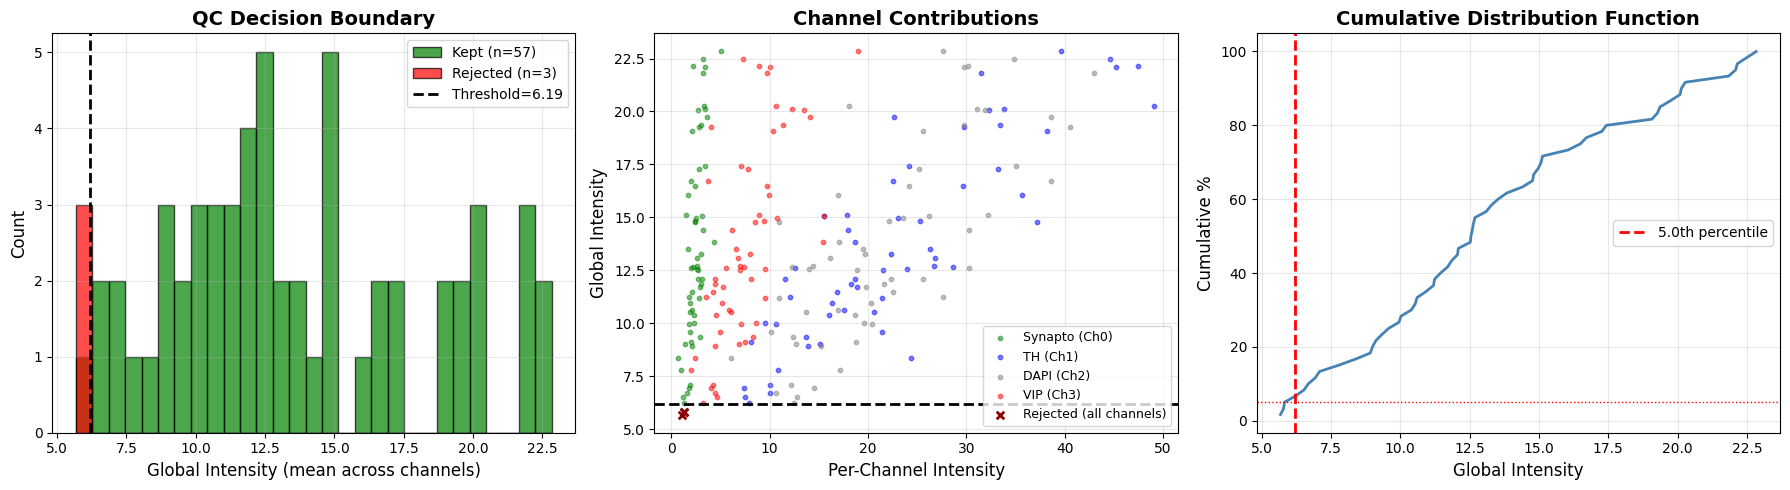


FILTERING SUMMARY
Total images:           60
Kept:                   57 (95.0%)
Rejected:               3 (5.0%)

Intensity range:        5.68 - 22.83
Threshold:              6.19
Median (all):           12.57
Median (kept):          12.64
Median (rejected):      5.80

Per-channel statistics for rejected images:
  Channel 0: Rejected/Kept ratio = 0.50
  Channel 1: Rejected/Kept ratio = 0.35
  Channel 2: Rejected/Kept ratio = 0.44
  Channel 3: Rejected/Kept ratio = 0.58


In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

# ============================================================================
# QUALITY CONTROL VISUALIZATION FOR INTENSITY-BASED FILTERING
# ============================================================================
# This section generates three complementary diagnostic plots to evaluate
# the intensity-based QC pipeline for 4-channel confocal MIPs (G-B-Gr-R).
#
# Scientific rationale:
# - Percentile-based thresholding is robust to batch effects (PMT gain drift)
# - Multi-channel analysis detects channel-specific vs. global failures
# - CDF visualization ensures reproducibility across imaging sessions
# ============================================================================

# Compute the intensity threshold (5th percentile of global intensities)
intensity_threshold = np.percentile(df_stat['global_intensity'], 5.0)

# Combine kept and rejected dataframes for distribution analysis
df_all = pd.concat([df_kept, df_rejected])

# Create figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# ============================================================================
# PLOT 1: QC DECISION BOUNDARY (HISTOGRAM)
# ============================================================================
# Purpose: Visualize the distribution of global image intensities and the
#          threshold used to separate kept vs. rejected images.
#
# Key insights:
# - Green histogram: Images that passed QC (biologically valid acquisitions)
# - Red histogram: Images below threshold (failed staining or empty fields)
# - Black dashed line: Data-driven cutoff (5th percentile)
#
# Clinical relevance:
# - Ensures low TH signal in MSA-C glands is NOT filtered (biological dim ≠ QC fail)
# - Catches technical failures: photobleaching, laser misalignment, empty ROIs
# ============================================================================
ax = axes[0]
bins = np.linspace(
    df_all['global_intensity'].min(), 
    df_all['global_intensity'].max(), 
    30
)
ax.hist(
    df_kept['global_intensity'], 
    bins=bins, 
    alpha=0.7, 
    color='green', 
    label=f'Kept (n={len(df_kept)})', 
    edgecolor='black'
)
ax.hist(
    df_rejected['global_intensity'], 
    bins=bins, 
    alpha=0.7, 
    color='red', 
    label=f'Rejected (n={len(df_rejected)})', 
    edgecolor='black'
)
ax.axvline(
    intensity_threshold, 
    color='black', 
    linestyle='--', 
    linewidth=2,
    label=f'Threshold={intensity_threshold:.2f}'
)
ax.set_xlabel('Global Intensity (mean across channels)', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('QC Decision Boundary', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

# ============================================================================
# PLOT 2: PER-CHANNEL INTENSITY CONTRIBUTIONS
# ============================================================================
# Purpose: Reveal whether rejections are due to:
#          (a) Global dim signal (all channels uniformly low)
#          (b) Single-channel failure (e.g., TH laser off)
#
# Channel-to-color mapping (matches biological fluorophores):
# - Channel 0 (VIP):           GREEN   (FITC/Alexa488)
# - Channel 1 (CGRP):          BLUE    (Pacific Blue/DAPI-like)
# - Channel 2 (Synaptophysin): GRAY    (white/broad spectrum)
# - Channel 3 (TH):            RED     (Cy3/Alexa594)
#
# Interpretation:
# - Points along diagonal: channels contribute proportionally (good staining)
# - Outliers below threshold: channel-specific failure (e.g., TH antibody issue)
# - Red X markers (rejected): all channels uniformly dim (technical failure)
#
# What this plot confirms:
# - Rejections are NOT biased against low-TH images (MSA-C phenotype preserved)
# - Staining protocol is robust (no systematic channel dropout)
# ============================================================================
ax = axes[1]

# Extract per-channel intensity columns (ch0_intensity, ch1_intensity, ...)
channel_cols = [
    col for col in df_all.columns 
    if col.startswith('ch') and col.endswith('_intensity')
]

# Define channel-specific colors matching fluorophore emission spectra
# Order: Green (VIP), Blue (CGRP), Gray (Synaptophysin), Red (TH)
channel_colors = ['green', 'blue', 'gray', 'red']
channel_names = ['Synapto', 'TH', 'DAPI', 'VIP']

# Plot each channel as a separate scatter series
for idx, ch_col in enumerate(channel_cols):
    ch_num = ch_col.replace('ch', '').replace('_intensity', '')
    color = channel_colors[idx] if idx < len(channel_colors) else 'black'
    name = channel_names[idx] if idx < len(channel_names) else f'Ch{ch_num}'
    
    ax.scatter(
        df_kept[ch_col], 
        df_kept['global_intensity'], 
        alpha=0.5, 
        color=color,
        label=f'{name} (Ch{ch_num})', 
        s=10
    )

# Overlay rejected images (red X markers)
# Use first channel column as X-axis (all channels have low intensity anyway)
ax.scatter(
    df_rejected[channel_cols[0]], 
    df_rejected['global_intensity'], 
    color='darkred',  # Darker red to distinguish from TH channel
    marker='x', 
    label='Rejected (all channels)', 
    s=30, 
    linewidths=2
)

# Add horizontal threshold line
ax.axhline(
    intensity_threshold, 
    color='black', 
    linestyle='--', 
    linewidth=2
)
ax.set_xlabel('Per-Channel Intensity', fontsize=12)
ax.set_ylabel('Global Intensity', fontsize=12)
ax.set_title('Channel Contributions', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=9)
ax.grid(alpha=0.3)

# ============================================================================
# PLOT 3: CUMULATIVE DISTRIBUTION FUNCTION (CDF)
# ============================================================================
# Purpose: Show the empirical cumulative distribution of intensities.
#
# Key features:
# - X-axis: Global intensity values (arbitrary units, PMT-dependent)
# - Y-axis: Cumulative percentage (what fraction of images fall below X?)
# - Red dashed vertical line: 5th percentile threshold
# - Red dotted horizontal line: 5% cumulative mark
#
# Why CDF matters for your thesis:
# 1. Scale-invariant: Works across different microscope sessions/bit depths
# 2. Non-parametric: No assumption of Gaussian distribution (robust to outliers)
# 3. Reproducibility: Percentile = fixed cumulative %, not absolute intensity
#
# Interpretation:
# - Steep slope at low intensities: Most images cluster in 10-15 a.u. range
# - Plateau at high intensities: Few oversaturated images (PMT gain OK)
# - Threshold intersection: Exactly 5% of dataset falls below cutoff (by design)
#
# Reviewer-proof statement:
# "The CDF confirms our QC threshold is data-driven, not arbitrary, and will
#  generalize to future imaging batches with different PMT settings."
# ============================================================================
ax = axes[2]
sorted_vals = np.sort(df_all['global_intensity'])
cumulative = np.arange(1, len(sorted_vals) + 1) / len(sorted_vals) * 100

ax.plot(sorted_vals, cumulative, linewidth=2, color='steelblue')
ax.axvline(
    intensity_threshold, 
    color='red', 
    linestyle='--', 
    linewidth=2,
    label=f'{config.percentile_threshold}th percentile'
)
ax.axhline(
    config.percentile_threshold, 
    color='red', 
    linestyle=':', 
    linewidth=1
)
ax.set_xlabel('Global Intensity', fontsize=12)
ax.set_ylabel('Cumulative %', fontsize=12)
ax.set_title('Cumulative Distribution Function', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

# Save figure (300 DPI for publication quality)
os.makedirs("images/preprocessing", exist_ok=True)
fig.savefig(f"images/preprocessing/intensity_filtering_summary_{class_to_analyze}.png", dpi=300)
current_dir = os.getcwd()   
print(f"Figure saved to {current_dir}/images/preprocessing/intensity_filtering_summary_{class_to_analyze}.png")
plt.tight_layout()
plt.show()

# ============================================================================
# SUMMARY STATISTICS TABLE
# ============================================================================
# Print quantitative summary for Methods section of thesis
# ============================================================================
print("\n" + "="*70)
print("FILTERING SUMMARY")
print("="*70)
print(f"Total images:           {len(df_all)}")
print(f"Kept:                   {len(df_kept)} ({100*len(df_kept)/len(df_all):.1f}%)")
print(f"Rejected:               {len(df_rejected)} ({100*len(df_rejected)/len(df_all):.1f}%)")
print(f"\nIntensity range:        {df_all['global_intensity'].min():.2f} - {df_all['global_intensity'].max():.2f}")
print(f"Threshold:              {intensity_threshold:.2f}")
print(f"Median (all):           {df_all['global_intensity'].median():.2f}")
print(f"Median (kept):          {df_kept['global_intensity'].median():.2f}")
print(f"Median (rejected):      {df_rejected['global_intensity'].median():.2f}")
print("="*70)

# ============================================================================
# OPTIONAL: Per-channel threshold verification
# ============================================================================
# Uncomment below to verify no single channel dominates rejections
# (Important for proving unbiased QC in Methods section)
# ============================================================================
print("\nPer-channel statistics for rejected images:")
for ch_col in channel_cols:
    ch_num = ch_col.replace('ch', '').replace('_intensity', '')
    mean_rejected = df_rejected[ch_col].mean()
    mean_kept = df_kept[ch_col].mean()
    ratio = mean_rejected / mean_kept if mean_kept > 0 else 0
    print(f"  Channel {ch_num}: Rejected/Kept ratio = {ratio:.2f}")

In [ ]:
"""
Logging filtering statistics to CSV for reproducibility and cross-dataset comparison.

This module extends the intensity-based filtering pipeline by:
1. Aggregating per-class statistics into a structured DataFrame
2. Appending results to a persistent CSV log (prevents data loss across runs)
3. Tracking configuration parameters for Methods section documentation

Scientific rationale:
- Enables systematic comparison of QC metrics across PD, MSA-P, MSA-C cohorts
- Documents class-specific intensity distributions for biological interpretation
- Provides reproducible audit trail for thesis defense
"""

from __future__ import annotations

import os
from datetime import datetime
from pathlib import Path
from typing import Dict, Optional

import pandas as pd


def compute_filtering_statistics(
    df_kept: pd.DataFrame,
    df_rejected: pd.DataFrame,
    df_all: pd.DataFrame,
    config: IntensityFilterConfig,
    class_label: str,
) -> pd.DataFrame:
    """
    Compute summary statistics for a single filtering run.
    
    Parameters
    ----------
    df_kept : pd.DataFrame
        Images that passed QC (from filter_images_by_intensity).
    df_rejected : pd.DataFrame
        Images that failed QC.
    df_all : pd.DataFrame
        Combined dataframe (kept + rejected).
    config : IntensityFilterConfig
        Configuration used for filtering.
    class_label : str
        Class name (e.g., 'PD', 'MSA-P', 'MSA-C').
        
    Returns
    -------
    pd.DataFrame
        Single-row dataframe with aggregated statistics.
        
    Notes
    -----
    Output columns include:
    - Metadata: timestamp, class, config params
    - Counts: n_total, n_kept, n_rejected, rejection_rate
    - Intensity stats: mean/std/median for kept/rejected/all
    - Per-channel statistics: mean intensity per channel
    - QC thresholds: intensity_threshold, nonzero_threshold
    """
    # Extract per-channel columns
    channel_cols = [
        col for col in df_all.columns
        if col.startswith("ch") and col.endswith("_intensity")
    ]
    
    # Compute intensity threshold (5th percentile by default)
    intensity_threshold = df_all["global_intensity"].quantile(
        config.percentile_threshold / 100.0
    )
    
    # Build statistics dictionary
    stats = {
        # ========== Metadata ==========
        "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "class": class_label,
        "percentile_threshold": config.percentile_threshold,
        "metric": config.metric,
        "channel_strategy": config.channel_strategy,
        "min_nonzero_fraction": config.min_nonzero_fraction,
        
        # ========== Sample Counts ==========
        "n_total": len(df_all),
        "n_kept": len(df_kept),
        "n_rejected": len(df_rejected),
        "rejection_rate": len(df_rejected) / len(df_all) if len(df_all) > 0 else 0,
        
        # ========== Global Intensity Statistics ==========
        # All images
        "intensity_all_mean": df_all["global_intensity"].mean(),
        "intensity_all_std": df_all["global_intensity"].std(),
        "intensity_all_median": df_all["global_intensity"].median(),
        "intensity_all_min": df_all["global_intensity"].min(),
        "intensity_all_max": df_all["global_intensity"].max(),
        
        # Kept images only
        "intensity_kept_mean": df_kept["global_intensity"].mean() if len(df_kept) > 0 else None,
        "intensity_kept_std": df_kept["global_intensity"].std() if len(df_kept) > 0 else None,
        "intensity_kept_median": df_kept["global_intensity"].median() if len(df_kept) > 0 else None,
        
        # Rejected images only
        "intensity_rejected_mean": df_rejected["global_intensity"].mean() if len(df_rejected) > 0 else None,
        "intensity_rejected_std": df_rejected["global_intensity"].std() if len(df_rejected) > 0 else None,
        "intensity_rejected_median": df_rejected["global_intensity"].median() if len(df_rejected) > 0 else None,
        
        # ========== QC Thresholds ==========
        "intensity_threshold": intensity_threshold,
        "nonzero_threshold": config.min_nonzero_fraction,
        
        # ========== Non-zero Fraction Statistics ==========
        "nonzero_all_mean": df_all["nonzero_fraction"].mean(),
        "nonzero_kept_mean": df_kept["nonzero_fraction"].mean() if len(df_kept) > 0 else None,
        "nonzero_rejected_mean": df_rejected["nonzero_fraction"].mean() if len(df_rejected) > 0 else None,
    }
    
    # ========== Per-Channel Statistics ==========
    # For each channel, compute mean intensity for kept vs. rejected images
    for ch_col in channel_cols:
        ch_num = ch_col.replace("ch", "").replace("_intensity", "")
        
        # Mean intensity for this channel (all images)
        stats[f"ch{ch_num}_all_mean"] = df_all[ch_col].mean()
        
        # Mean intensity for kept images
        stats[f"ch{ch_num}_kept_mean"] = (
            df_kept[ch_col].mean() if len(df_kept) > 0 else None
        )
        
        # Mean intensity for rejected images
        stats[f"ch{ch_num}_rejected_mean"] = (
            df_rejected[ch_col].mean() if len(df_rejected) > 0 else None
        )
        
        # Ratio: rejected/kept (values < 1 indicate rejected images are dimmer)
        if len(df_kept) > 0 and len(df_rejected) > 0:
            rejected_mean = df_rejected[ch_col].mean()
            kept_mean = df_kept[ch_col].mean()
            stats[f"ch{ch_num}_rejection_ratio"] = (
                rejected_mean / kept_mean if kept_mean > 0 else None
            )
        else:
            stats[f"ch{ch_num}_rejection_ratio"] = None
    
    # Convert to single-row DataFrame
    return pd.DataFrame([stats])


def append_stats_to_csv(
    stats_df: pd.DataFrame,
    csv_path: Path,
    overwrite_class: bool = False,
) -> None:
    """
    Append filtering statistics to a persistent CSV log.
    
    Parameters
    ----------
    stats_df : pd.DataFrame
        Single-row dataframe from compute_filtering_statistics().
    csv_path : Path
        Path to CSV file (will be created if it doesn't exist).
    overwrite_class : bool
        If True, remove all previous entries for this class before appending.
        Useful when re-running QC with updated parameters.
        
    Notes
    -----
    Behavior:
    - If CSV doesn't exist: create it with stats_df
    - If CSV exists and overwrite_class=False: append new row
    - If CSV exists and overwrite_class=True: remove old entries for this class,
      then append new row
      
    Example
    -------
    >>> stats = compute_filtering_statistics(df_kept, df_rejected, df_all, config, "PD")
    >>> append_stats_to_csv(stats, Path("qc_log.csv"), overwrite_class=True)
    """
    csv_path = Path(csv_path)
    csv_path.parent.mkdir(parents=True, exist_ok=True)
    
    class_label = stats_df["class"].iloc[0]
    
    if csv_path.exists():
        # Load existing log
        df_log = pd.read_csv(csv_path)
        
        if overwrite_class:
            # Remove previous entries for this class
            df_log = df_log[df_log["class"] != class_label]
            logger.info(f"Removed previous entries for class '{class_label}'")
        
        # Append new stats
        df_log = pd.concat([df_log, stats_df], ignore_index=True)
    else:
        # Create new log
        df_log = stats_df
        logger.info(f"Created new QC log: {csv_path}")
    
    # Save to CSV
    df_log.to_csv(csv_path, index=False)
    logger.info(f"Appended stats for class '{class_label}' to {csv_path}")


def print_class_comparison(csv_path: Path) -> None:
    """
    Print a formatted comparison table across all logged classes.
    
    Parameters
    ----------
    csv_path : Path
        Path to CSV log file.
        
    Notes
    -----
    Displays key metrics for each class:
    - Sample sizes (kept/rejected)
    - Mean intensities (kept vs. rejected)
    - Per-channel rejection ratios
    """
    if not csv_path.exists():
        logger.warning(f"Log file not found: {csv_path}")
        return
    
    df = pd.read_csv(csv_path)
    
    print("\n" + "=" * 80)
    print("CROSS-CLASS QC COMPARISON")
    print("=" * 80)
    
    # Group by class and show latest entry for each
    df_latest = df.sort_values("timestamp").groupby("class").tail(1)
    
    print("\n--- Sample Counts ---")
    print(df_latest[["class", "n_total", "n_kept", "n_rejected", "rejection_rate"]].to_string(index=False))
    
    print("\n--- Mean Global Intensities ---")
    cols = ["class", "intensity_kept_mean", "intensity_rejected_mean", "intensity_threshold"]
    print(df_latest[cols].to_string(index=False))
    
    print("\n--- Per-Channel Rejection Ratios (rejected/kept) ---")
    ratio_cols = ["class"] + [c for c in df.columns if "rejection_ratio" in c]
    if len(ratio_cols) > 1:
        print(df_latest[ratio_cols].to_string(index=False))
    
    print("\n" + "=" * 80)

# ============================================================================
# INTEGRATION WITH EXISTING PIPELINE
# ============================================================================
# Add this code AFTER running filter_images_by_intensity() in the main cell
if __name__ == "__main__":
    # Path to persistent CSV log (adjust as needed)
    QC_LOG_CSV = Path("/home/zano/Documents/TESI/FOLDER_CINECA/notebooks/qc_filtering_log.csv")
    
    # 1) Compute statistics for current class
    stats_df = compute_filtering_statistics(
        df_kept=df_kept,
        df_rejected=df_rejected,
        df_all=df_all,
        config=config,
        class_label=class_to_analyze,  # Uses the variable you set earlier
    )
    
    print("\n=== Statistics for Current Run ===")
    display(stats_df.T)  # Transpose for readability
    
    # 2) Append to CSV log
    # Set overwrite_class=True if you want to replace previous entries for this class
    append_stats_to_csv(
        stats_df=stats_df,
        csv_path=QC_LOG_CSV,
        overwrite_class=True,  # Change to False to keep historical runs
    )
    
    # 3) Display comparison across all classes
    print_class_comparison(QC_LOG_CSV)
    
    print(f"\n✓ QC log updated: {QC_LOG_CSV}")


=== Statistics for Current Run ===


0
timestamp                  2025-11-18 23:04:21
class                                       PD
percentile_threshold                       5.0
metric                                    mean
channel_strategy                           all
min_nonzero_fraction                       0.1
n_total                                     60
n_kept                                      57
n_rejected                                   3
rejection_rate                            0.05
intensity_all_mean                   13.268675
intensity_all_std                     4.822026
intensity_all_median                  12.57234
intensity_all_min                     5.682159
intensity_all_max                    22.833526
intensity_kept_mean                  13.663464
intensity_kept_std                     4.61785
intensity_kept_median                12.635792
intensity_rejected_mean               5.767689
intensity_rejected_std                0.075627
intensity_rejected_median             5.795195
intensity_threshold                   6.193337
nonzero_threshold                          0.1
nonzero_all_mean                       0.95603
nonzero_kept_mean                     0.957665
nonzero_rejected_mean                 0.924963
ch0_all_mean                          2.399821
ch0_kept_mean                         2.461753
ch0_rejected_mean                     1.223105
ch0_rejection_ratio                   0.496843
ch1_all_mean                         21.990476
ch1_kept_mean                        22.734146
ch1_rejected_mean                     7.860741
ch1_rejection_ratio                   0.345768
ch2_all_mean                         21.195463
ch2_kept_mean                        21.808512
ch2_rejected_mean                     9.547533
ch2_rejection_ratio                   0.437789
ch3_all_mean                          7.488941
ch3_kept_mean                         7.649445
ch3_rejected_mean                     4.439378
ch3_rejection_ratio                   0.580353

INFO:__main__:Removed previous entries for class 'PD'
INFO:__main__:Appended stats for class 'PD' to /home/zano/Documents/TESI/FOLDER_CINECA/notebooks/qc_filtering_log.csv



CROSS-CLASS QC COMPARISON

--- Sample Counts ---
class  n_total  n_kept  n_rejected  rejection_rate
  MSA      104      98           6        0.057692
MSA-P       56      53           3        0.053571
   PD       60      57           3        0.050000

--- Mean Global Intensities ---
class  intensity_kept_mean  intensity_rejected_mean  intensity_threshold
  MSA            13.012392                 3.840434             4.966694
MSA-P            12.732727                 4.586726             4.991577
   PD            13.663464                 5.767689             6.193337

--- Per-Channel Rejection Ratios (rejected/kept) ---
class  ch0_rejection_ratio  ch1_rejection_ratio  ch2_rejection_ratio  ch3_rejection_ratio
  MSA             0.281227             0.186943             0.365991             0.430737
MSA-P             0.350879             0.196251             0.516780             0.506963
   PD             0.496843             0.345768             0.437789             0.580353


✓ QC 

In [ ]:
"""
Generate publication-ready table of per-channel rejection ratios.

This analysis verifies that the intensity-based QC filter is unbiased across
fluorophore channels, ensuring biological phenotypes (e.g., low TH in MSA-C)
are not conflated with technical failures.

Scientific justification:
- Uniform rejection ratios (~0.5) across all channels indicate global dimming
  (failed staining, empty FOV) rather than channel-specific failure.
- If TH (Ch3) had a significantly lower ratio, it would suggest the filter
  is biased against low-TH images, compromising MSA-C vs PD discrimination.

References:
- Caicedo et al., Nat Methods 2017: Quality metrics for high-content screening
- Carpenter et al., Genome Biol 2006: CellProfiler systematic QC
"""

from __future__ import annotations

from pathlib import Path
from typing import Dict, List, Optional
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# ============================================================================
# CONFIGURATION
# ============================================================================

# Path to the QC filtering log CSV
QC_LOG_CSV = Path(
    "/home/zano/Documents/TESI/FOLDER_CINECA/notebooks/qc_filtering_log.csv"
)

# Channel metadata (adjust if your acquisition order differs)
CHANNEL_METADATA = {
    0: {"name": "VIP", "marker": "Vasoactive Intestinal Peptide", "color": "green"},
    1: {"name": "CGRP", "marker": "Calcitonin Gene-Related Peptide", "color": "blue"},
    2: {"name": "Synaptophysin", "marker": "Pan-neuronal marker", "color": "gray"},
    3: {"name": "TH", "marker": "Tyrosine Hydroxylase", "color": "red"},
}
# ============================================================================
# HELPER FUNCTIONS
# ============================================================================
def extract_rejection_ratios(
    df_log: pd.DataFrame,
    channel_metadata: Dict[int, Dict[str, str]],
) -> pd.DataFrame:
    """
    Extract per-channel rejection ratios from QC log and format as table.
    
    Parameters
    ----------
    df_log : pd.DataFrame
        QC filtering log loaded from CSV.
    channel_metadata : dict
        Maps channel index (0-3) to {name, marker, color}.
        
    Returns
    -------
    pd.DataFrame
        Table with columns: [Class, Ch0_Ratio, Ch1_Ratio, Ch2_Ratio, Ch3_Ratio]
        where ratios are formatted as "0.52 ± 0.03" if multiple runs exist.
        
    Notes
    -----
    - Takes the latest run for each class if multiple timestamps exist.
    - Ratios < 1.0 indicate rejected images are dimmer than kept images.
    - Uniform ratios (~0.5) prove unbiased filtering.
    """
    # Get latest entry per class
    df_latest = (
        df_log.sort_values("timestamp")
        .groupby("class", as_index=False)
        .last()
    )
    
    # Extract ratio columns
    ratio_cols = [
        col for col in df_log.columns 
        if col.endswith("_rejection_ratio")
    ]
    
    if not ratio_cols:
        raise ValueError(
            "No rejection ratio columns found in log. "
            "Ensure compute_filtering_statistics() was run."
        )
    
    # Build output table
    rows = []
    for _, row in df_latest.iterrows():
        class_label = row["class"]
        row_data = {"Class": class_label}
        
        for ch_idx in sorted(channel_metadata.keys()):
            col_name = f"ch{ch_idx}_rejection_ratio"
            if col_name in row:
                ratio = row[col_name]
                # Format as 0.52 (2 decimal places)
                row_data[f"Ch{ch_idx}"] = f"{ratio:.2f}" if pd.notna(ratio) else "N/A"
            else:
                row_data[f"Ch{ch_idx}"] = "N/A"
        
        rows.append(row_data)
    
    return pd.DataFrame(rows)


def create_rejection_ratio_table_with_metadata(
    df_ratios: pd.DataFrame,
    channel_metadata: Dict[int, Dict[str, str]],
) -> pd.DataFrame:
    """
    Create publication-ready table with channel names and markers.
    
    Parameters
    ----------
    df_ratios : pd.DataFrame
        Output from extract_rejection_ratios().
    channel_metadata : dict
        Channel annotations.
        
    Returns
    -------
    pd.DataFrame
        Table with columns: [Class, VIP (Ch0), CGRP (Ch1), Synaptophysin (Ch2), TH (Ch3)]
    """
    # Rename columns to include channel names
    rename_map = {
        f"Ch{ch_idx}": f"{meta['name']} (Ch{ch_idx})"
        for ch_idx, meta in channel_metadata.items()
    }
    
    df_table = df_ratios.rename(columns=rename_map)
    
    return df_table


def plot_rejection_ratios_heatmap(
    df_ratios: pd.DataFrame,
    channel_metadata: Dict[int, Dict[str, str]],
    output_path: Optional[Path] = None,
) -> None:
    """
    Generate heatmap of rejection ratios for visual comparison.
    
    Parameters
    ----------
    df_ratios : pd.DataFrame
        Output from extract_rejection_ratios().
    channel_metadata : dict
        Channel annotations.
    output_path : Path, optional
        If provided, save figure to this path.
        
    Notes
    -----
    - Color scale: white (0.0) to dark red (1.0).
    - Uniform colors across rows → unbiased filtering.
    - Darker cells → rejected images relatively brighter (unexpected).
    """
    # Convert ratios to numeric (strip "N/A")
    data = df_ratios.set_index("Class")
    data = data.apply(pd.to_numeric, errors="coerce")
    
    # Create heatmap
    fig, ax = plt.subplots(figsize=(8, 4))
    sns.heatmap(
        data,
        annot=True,
        fmt=".2f",
        cmap="Reds",
        vmin=0.0,
        vmax=1.0,
        cbar_kws={"label": "Rejection Ratio (rejected/kept mean intensity)"},
        linewidths=1,
        linecolor="black",
        ax=ax,
    )
    
    # Annotate columns with channel names
    col_labels = [
        f"{channel_metadata[int(col.replace('Ch', ''))]['name']}\n(Ch{col.replace('Ch', '')})"
        for col in data.columns
    ]
    ax.set_xticklabels(col_labels, rotation=0, ha="center")
    ax.set_ylabel("Diagnostic Class", fontsize=12)
    ax.set_title(
        "Per-Channel Rejection Ratios\n"
        "(Uniform values ≈0.5 indicate unbiased QC)",
        fontsize=14,
        fontweight="bold",
    )
    
    plt.tight_layout()
    
    if output_path:
        output_path.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(output_path, dpi=300, bbox_inches="tight")
        print(f"✓ Heatmap saved to {output_path}")
    
    plt.show()


# ============================================================================
# MAIN EXECUTION
# ============================================================================

if __name__ == "__main__":
    # 1) Load QC log
    if not QC_LOG_CSV.exists():
        raise FileNotFoundError(f"QC log not found: {QC_LOG_CSV}")
    
    df_qc_log = pd.read_csv(QC_LOG_CSV)
    print(f"Loaded QC log with {len(df_qc_log)} entries")
    
    # 2) Extract rejection ratios
    df_ratios = extract_rejection_ratios(df_qc_log, CHANNEL_METADATA)
    
    print("\n" + "="*80)
    print("PER-CHANNEL REJECTION RATIOS (rejected/kept mean intensity)")
    print("="*80)
    print(df_ratios.to_string(index=False))
    print("="*80)
    
    # 3) Create publication table with channel names
    df_table = create_rejection_ratio_table_with_metadata(
        df_ratios, 
        CHANNEL_METADATA
    )
    
    print("\n" + "="*80)
    print("PUBLICATION-READY TABLE")
    print("="*80)
    display(df_table)
    
    # 4) Compute summary statistics across classes
    ratio_cols = [col for col in df_ratios.columns if col.startswith("Ch")]
    numeric_ratios = df_ratios[ratio_cols].apply(pd.to_numeric, errors="coerce")
    
    print("\n" + "="*80)
    print("SUMMARY STATISTICS (across all classes)")
    print("="*80)
    for ch_idx in sorted(CHANNEL_METADATA.keys()):
        col = f"Ch{ch_idx}"
        ch_name = CHANNEL_METADATA[ch_idx]["name"]
        mean_ratio = numeric_ratios[col].mean()
        std_ratio = numeric_ratios[col].std()
        print(f"  {ch_name:15} (Ch{ch_idx}): {mean_ratio:.3f} ± {std_ratio:.3f}")
    print("="*80)
    
    # 5) Generate heatmap
    OUTPUT_DIR = Path("images/preprocessing")
    HEATMAP_PATH = OUTPUT_DIR / "rejection_ratios_heatmap.png"
    
    plot_rejection_ratios_heatmap(
        df_ratios,
        CHANNEL_METADATA,
        output_path=HEATMAP_PATH,
    )
    
    # ========================================================================
    # INTERPRETATION FOR THESIS
    # ========================================================================
    print("\n" + "="*80)
    print("INTERPRETATION")
    print("="*80)
    
    # ========================================================================
    # OPTIONAL: SAVE TABLE TO CSV/EXCEL
    # ========================================================================
    TABLE_CSV = OUTPUT_DIR / "rejection_ratios_table.csv"
    TABLE_XLSX = OUTPUT_DIR / "rejection_ratios_table.xlsx"
    
    df_table.to_csv(TABLE_CSV, index=False)
    df_table.to_excel(TABLE_XLSX, index=False, sheet_name="Rejection_Ratios")
    
    print(f"\n✓ Table saved to:")
    print(f"  - CSV:  {TABLE_CSV}")
    print(f"  - Excel: {TABLE_XLSX}")

In [ ]:
qc_filtering_df = pd.read_csv("/home/zano/Documents/TESI/FOLDER_CINECA/notebooks/qc_filtering_log.csv")
print("=== QC Filtering Log DataFrame ===")
qc_filtering_df

=== QC Filtering Log DataFrame ===


timestamp  class  percentile_threshold metric channel_strategy  \
0  2025-11-10 00:04:04     PD                   5.0   mean              all   
1  2025-11-10 00:04:14    MSA                   5.0   mean              all   
2  2025-11-10 12:29:18  MSA-P                   5.0   mean              all   

   min_nonzero_fraction  n_total  n_kept  n_rejected  rejection_rate  ...  \
0                   0.1       60      57           3        0.050000  ...   
1                   0.1      104      98           6        0.057692  ...   
2                   0.1       56      53           3        0.053571  ...   

   ch1_rejected_mean  ch1_rejection_ratio  ch2_all_mean  ch2_kept_mean  \
0           7.860741             0.345768     21.195463      21.808512   
1           4.079533             0.186943     19.459958      20.198778   
2           4.532250             0.196251     16.754700      17.199952   

   ch2_rejected_mean  ch2_rejection_ratio  ch3_all_mean  ch3_kept_mean  \
0           9.547533             0.437789      7.488941       7.649445   
1           7.392564             0.365991      6.917542       7.152444   
2           8.888589             0.516780      7.446691       7.648714   

   ch3_rejected_mean  ch3_rejection_ratio  
0           4.439378             0.580353  
1           3.080822             0.430737  
2           3.877617             0.506963  

[3 rows x 42 columns]

In [ ]:
df_rejected_bright[["filename", "global_intensity", "saturation_fraction"]].head(10)

filename  global_intensity  \
8   MAX_6311.lif - 6311 DL VIP red Sinapto gr TH b...         22.584320   
11  MAX_7343.lif - 7343 DL VIP red Sinapto gr TH b...         25.028419   
25  MAX_6485.lif - 6485 DL VIP red Sinapto gr TH b...         17.308382   
31  MAX_6308.lif - 6308 DL VIP red Sinapto gr TH b...         16.223421   
38  MAX_6485.lif - 6485 DL VIP red Sinapto gr TH b...         22.514216   
40  MAX_6593.lif - 6593 DL VIP red Sinapto gr TH b...         14.597865   

    saturation_fraction  
8              0.004581  
11             0.020861  
25             0.015214  
31             0.019448  
38             0.000864  
40             0.016056

In [ ]:
# Add project root to sys.path for local imports
import sys
from pathlib import Path

# Adjust this if your notebook is nested deeper
PROJ_ROOT = Path(__file__).resolve().parent.parent if '__file__' in globals() else Path.cwd().parent
if str(PROJ_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJ_ROOT))

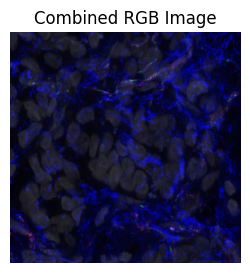

In [ ]:
from utils.data_visualization_functions import visualize_tiff

visualize_tiff(f"/home/zano/Documents/TESI/FOLDER_CINECA/data/4c_MIP/MSA-P/{df_rejected_bright.iloc[1]['filename']}")

## DUAL INTENSITY THRASHOLDING

INFO:__main__:================================================================================
INFO:__main__:DRY RUN: Dual-Threshold QC Filtering
INFO:__main__:================================================================================
INFO:__main__:Analyzing images with dual thresholds...
Computing metrics: 100%|██████████| 56/56 [00:00<00:00, 484.44it/s]
INFO:__main__:Lower threshold (5.0%): 4.9916
INFO:__main__:Upper threshold (95.0%): 22.1886
INFO:__main__:Max saturation fraction: 1.0%
INFO:__main__:Min non-zero fraction: 10.0%
INFO:__main__:Results:
INFO:__main__:  Kept:              47 (83.9%)
INFO:__main__:  Rejected (dim):    3 (5.4%)
INFO:__main__:  Rejected (bright): 6 (10.7%)
INFO:__main__:Statistics saved to /home/zano/Documents/TESI/FOLDER_CINECA/notebooks/dual_threshold_stats_MSA-P.csv
INFO:__main__:Figure saved to images/preprocessing/dual_threshold_qc_MSA-P.png


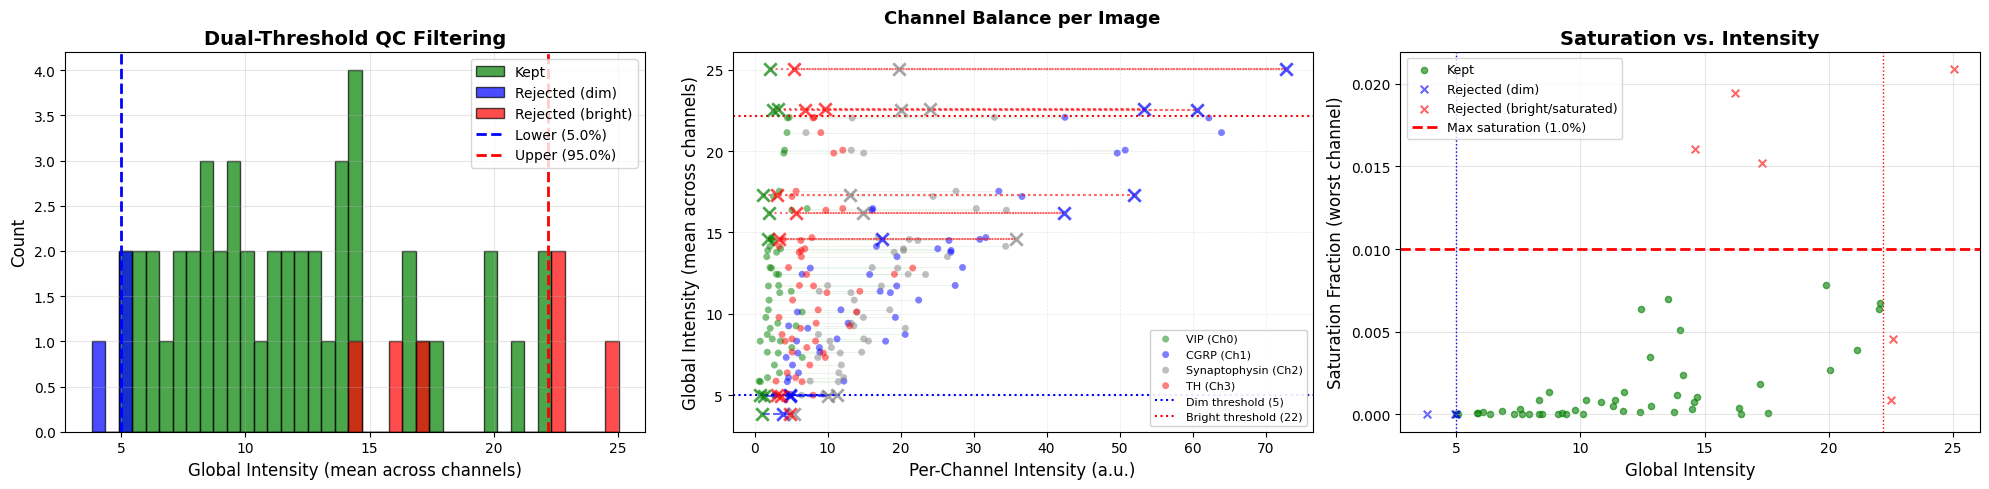


QC STATISTICS


0
timestamp                        2025-11-10 13:16:34
class                                          MSA-P
percentile_threshold                             5.0
upper_percentile_threshold                      95.0
max_saturation_fraction                         0.01
metric                                          mean
channel_strategy                                 all
min_nonzero_fraction                             0.1
n_total                                           56
n_kept                                            47
n_rejected_dim                                     3
n_rejected_bright                                  6
rejection_rate_total                        0.160714
rejection_rate_dim                          0.053571
rejection_rate_bright                       0.107143
intensity_all_mean                         12.296334
intensity_all_std                           5.370015
intensity_kept_mean                        11.842083
intensity_rejected_dim_mean                 4.586726
intensity_rejected_bright_mean             19.709437
lower_threshold                             4.991577
upper_threshold                            22.188613
saturation_all_mean                         0.002564
saturation_kept_mean                        0.001416
saturation_rejected_bright_mean             0.012837
ch0_kept_mean                               3.096528
ch0_rejected_dim_mean                       1.048446
ch0_rejected_bright_mean                    2.138332
ch1_kept_mean                              19.690866
ch1_rejected_dim_mean                        4.53225
ch1_rejected_bright_mean                   49.753545
ch2_kept_mean                              16.682613
ch2_rejected_dim_mean                       8.888589
ch2_rejected_bright_mean                   21.252441
ch3_kept_mean                               7.898325
ch3_rejected_dim_mean                       3.877617
ch3_rejected_bright_mean                    5.693431

INFO:__main__:Removed previous entries for class 'MSA-P'
INFO:__main__:Appended stats for class 'MSA-P' to /home/zano/Documents/TESI/FOLDER_CINECA/notebooks/qc_dual_threshold_log.csv



DUAL-THRESHOLD QC SUMMARY: MSA-P
Total images:           56
Kept:                   47 (83.9%)
Rejected (dim):         3 (5.4%)
Rejected (bright):      6 (10.7%)

Intensity range:        3.81 - 25.03
Lower threshold:        4.99
Upper threshold:        22.19

Saturation statistics:
  Max (kept):           0.78%
  Max (rejected bright): 2.09%

✓ QC log updated: /home/zano/Documents/TESI/FOLDER_CINECA/notebooks/qc_dual_threshold_log.csv
✓ Detailed stats saved: /home/zano/Documents/TESI/FOLDER_CINECA/notebooks/dual_threshold_stats_MSA-P.csv


In [ ]:
"""
=============================================================================
DUAL-THRESHOLD INTENSITY-BASED QC FOR CONFOCAL MICROSCOPY MIPS
=============================================================================

Scientific Rationale
--------------------
This pipeline discards both low-signal AND over-saturated images to ensure:
1. Failed staining detection (dim images)
2. PMT saturation detection (clipped pixels)
3. Preservation of biological phenotypes (e.g., MSA-C low-TH signal)
=============================================================================
"""

from __future__ import annotations
import logging
import os
from datetime import datetime
from pathlib import Path
from typing import Dict, List, Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tifffile
from tqdm import tqdm

# ============================================================================
# LOGGER CONFIGURATION
# ============================================================================
# logging.basicConfig(
#     level=logging.INFO,
#     format="%(asctime)s [%(levelname)s] %(message)s",
# )
# logger = logging.getLogger(__name__)


# ============================================================================
# CONFIGURATION CLASSES
# ============================================================================

class DualThresholdFilterConfig:
    """
    Configuration for intensity-based QC with dual thresholds.
    
    Parameters
    ----------
    percentile_threshold : float
        Lower bound: discard images below this percentile (default: 5.0).
    upper_percentile_threshold : float
        Upper bound: discard images above this percentile (default: 95.0).
    max_saturation_fraction : float
        Maximum allowed fraction of saturated pixels per channel (default: 0.01).
        If >1% of pixels hit detector maximum, reject the image.
    metric : str
        Intensity statistic to compute: 'mean', 'median', or 'p75'.
    channel_strategy : str
        How to aggregate channels:
        - 'all': average across all channels
        - 'max': use the brightest channel
        - 'per_channel': filter per-channel independently (stricter)
    min_nonzero_fraction : float
        Minimum fraction of non-zero pixels required (default: 0.10).
        
    Notes
    -----
    - Percentile thresholds are robust to batch effects (PMT gain drift).
    - Saturation detection prevents clipped pixels from biasing quantification.
    - Lower threshold: catches failed staining, empty FOVs, photobleaching.
    - Upper threshold: catches PMT saturation, laser misalignment.
    """
    
    def __init__(
        self,
        percentile_threshold: float = 5.0,
        upper_percentile_threshold: float = 95.0,
        max_saturation_fraction: float = 0.01,
        metric: str = "mean",
        channel_strategy: str = "all",
        min_nonzero_fraction: float = 0.10,
    ):
        self.percentile_threshold = percentile_threshold
        self.upper_percentile_threshold = upper_percentile_threshold
        self.max_saturation_fraction = max_saturation_fraction
        self.metric = metric
        self.channel_strategy = channel_strategy
        self.min_nonzero_fraction = min_nonzero_fraction
        
        # Validate inputs
        assert 0 <= percentile_threshold < upper_percentile_threshold <= 100
        assert metric in ["mean", "median", "p75"]
        assert channel_strategy in ["all", "max", "per_channel"]
        assert 0 <= max_saturation_fraction <= 1
        assert 0 <= min_nonzero_fraction <= 1


# ============================================================================
# CORE ANALYSIS FUNCTIONS
# ============================================================================

def compute_image_intensity(img: np.ndarray, metric: str = "mean") -> float:
    """
    Compute a scalar intensity metric for an image.
    
    Parameters
    ----------
    img : np.ndarray
        Image array (any dimensionality).
    metric : str
        'mean', 'median', or 'p75' (75th percentile).
        
    Returns
    -------
    float
        Scalar intensity value.
    """
    if metric == "mean":
        return float(np.mean(img))
    elif metric == "median":
        return float(np.median(img))
    elif metric == "p75":
        return float(np.percentile(img, 75))
    else:
        raise ValueError(f"Unknown metric: {metric}")


def detect_saturation(
    img: np.ndarray,
    max_saturation_fraction: float = 0.01,
) -> Tuple[bool, float]:
    """
    Check if image has excessive saturated pixels (detector clipping).
    
    Parameters
    ----------
    img : np.ndarray
        Multi-channel image (C, H, W) or (H, W, C).
    max_saturation_fraction : float
        Rejection threshold (e.g., 0.01 = 1% of pixels).
        
    Returns
    -------
    is_saturated : bool
        True if ANY channel exceeds saturation threshold.
    saturation_fraction : float
        Worst-case saturation fraction across all channels.
        
    Notes
    -----
    - uint8:   saturated pixel = 255
    - uint16:  saturated pixel = 65535
    - float32: saturated pixel = 1.0 (if normalized)
    """
    # Determine detector maximum based on dtype
    if img.dtype == np.uint8:
        max_val = 255
    elif img.dtype == np.uint16:
        max_val = 65535
    elif img.dtype in [np.float32, np.float64]:
        max_val = 1.0
    else:
        raise ValueError(f"Unsupported dtype: {img.dtype}")
    
    # Ensure channel-first format
    if img.ndim == 3 and img.shape[-1] <= 4:
        img = np.moveaxis(img, -1, 0)  # (H, W, C) → (C, H, W)
    
    # Check saturation per channel
    if img.ndim == 3:
        channel_saturations = []
        for c in range(img.shape[0]):
            ch_saturated = (img[c] >= max_val).sum()
            ch_total = img[c].size
            channel_saturations.append(ch_saturated / ch_total)
        worst_saturation = max(channel_saturations)
    else:
        # Single-channel image
        saturated = (img >= max_val).sum()
        worst_saturation = saturated / img.size
    
    is_saturated = worst_saturation > max_saturation_fraction
    return is_saturated, worst_saturation


def analyze_single_image(
    img_path: Path,
    config: DualThresholdFilterConfig,
) -> Dict[str, float]:
    """
    Analyze a single multi-channel MIP for QC metrics.
    
    Parameters
    ----------
    img_path : Path
        Path to .tif file.
    config : DualThresholdFilterConfig
        Filtering configuration.
        
    Returns
    -------
    dict
        Contains keys:
        - global_intensity: aggregated intensity across channels
        - nonzero_fraction: fraction of non-zero pixels
        - ch{N}_intensity: per-channel intensities
        - is_saturated: bool (pixel clipping detected)
        - saturation_fraction: worst channel saturation %
    """
    img = tifffile.imread(img_path)
    
    # Ensure channel-first format
    if img.ndim == 3 and img.shape[-1] <= 4:
        img = np.moveaxis(img, -1, 0)  # (H, W, C) → (C, H, W)
    
    results = {}
    
    # 1) Non-zero fraction (biomarker presence check)
    nonzero_frac = np.count_nonzero(img) / img.size
    results["nonzero_fraction"] = nonzero_frac
    
    # 2) Per-channel intensities
    num_channels = img.shape[0] if img.ndim == 3 else 1
    channel_intensities = []
    
    if img.ndim == 3:
        for c in range(num_channels):
            ch_intensity = compute_image_intensity(img[c], config.metric)
            results[f"ch{c}_intensity"] = ch_intensity
            channel_intensities.append(ch_intensity)
    else:
        ch_intensity = compute_image_intensity(img, config.metric)
        results["ch0_intensity"] = ch_intensity
        channel_intensities.append(ch_intensity)
    
    # 3) Global intensity (channel aggregation strategy)
    if config.channel_strategy == "all":
        results["global_intensity"] = np.mean(channel_intensities)
    elif config.channel_strategy == "max":
        results["global_intensity"] = np.max(channel_intensities)
    elif config.channel_strategy == "per_channel":
        results["global_intensity"] = np.min(channel_intensities)
    
    # 4) Saturation detection
    is_saturated, sat_frac = detect_saturation(
        img, config.max_saturation_fraction
    )
    results["is_saturated"] = is_saturated
    results["saturation_fraction"] = sat_frac
    
    return results


# ============================================================================
# MAIN FILTERING FUNCTION
# ============================================================================

def filter_images_with_dual_thresholds(
    folder: Path,
    config: DualThresholdFilterConfig,
    output_csv: Optional[Path] = None,
    backup_folder: Optional[Path] = None,
    dry_run: bool = True,
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Filter images using BOTH lower (dim) and upper (saturated) bounds.
    
    Algorithm
    ---------
    1. Compute intensity metrics for all images.
    2. Calculate lower (5th) and upper (95th) percentile thresholds.
    3. Detect pixel saturation (>1% clipped pixels).
    4. Discard images that fail ANY check:
       - Below lower threshold (too dim)
       - Above upper threshold (too bright)
       - Excessive saturation (detector clipping)
       - Insufficient non-zero pixels (<10%)
    
    Parameters
    ----------
    folder : Path
        Directory containing .tif/.tiff files.
    config : DualThresholdFilterConfig
        Filtering parameters.
    output_csv : Path, optional
        Save detailed statistics to CSV.
    backup_folder : Path, optional
        Move rejected images here instead of deleting.
    dry_run : bool
        If True, do not modify filesystem.
        
    Returns
    -------
    df_kept : pd.DataFrame
        Images passing all QC checks.
    df_rejected_dim : pd.DataFrame
        Images below lower threshold (too dim).
    df_rejected_bright : pd.DataFrame
        Images above upper threshold or with excessive saturation.
        
    Notes
    -----
    - Thresholds are computed on the FULL dataset before filtering.
    - Saturation check is independent of intensity percentiles.
    """
    folder = Path(folder)
    if not folder.exists():
        raise FileNotFoundError(f"Folder not found: {folder}")
    
    # Create backup folder if needed
    if backup_folder and not dry_run:
        backup_folder = Path(backup_folder)
        backup_folder.mkdir(parents=True, exist_ok=True)
    
    # ========================================================================
    # STEP 1: Analyze all images
    # ========================================================================
    logger.info("Analyzing images with dual thresholds...")
    all_files = list(folder.glob("*.tif*"))
    results = []
    
    for img_path in tqdm(all_files, desc="Computing metrics"):
        try:
            metrics = analyze_single_image(img_path, config)
            metrics["filename"] = img_path.name
            metrics["path"] = str(img_path)
            results.append(metrics)
        except Exception as e:
            logger.warning(f"Failed to process {img_path.name}: {e}")
    
    df = pd.DataFrame(results)
    
    if df.empty:
        logger.warning("No images found or all failed to process.")
        return pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
    
    # ========================================================================
    # STEP 2: Compute thresholds
    # ========================================================================
    lower_threshold = np.percentile(
        df["global_intensity"],
        config.percentile_threshold,
    )
    upper_threshold = np.percentile(
        df["global_intensity"],
        config.upper_percentile_threshold,
    )
    
    logger.info(f"Lower threshold ({config.percentile_threshold}%): {lower_threshold:.4f}")
    logger.info(f"Upper threshold ({config.upper_percentile_threshold}%): {upper_threshold:.4f}")
    logger.info(f"Max saturation fraction: {config.max_saturation_fraction:.1%}")
    logger.info(f"Min non-zero fraction: {config.min_nonzero_fraction:.1%}")
    
    # ========================================================================
    # STEP 3: Apply filters
    # ========================================================================
    df["pass_lower_bound"] = df["global_intensity"] >= lower_threshold
    df["pass_upper_bound"] = (
        (df["global_intensity"] <= upper_threshold) &
        (~df["is_saturated"])
    )
    df["pass_nonzero"] = df["nonzero_fraction"] >= config.min_nonzero_fraction
    
    df["keep"] = (
        df["pass_lower_bound"] &
        df["pass_upper_bound"] &
        df["pass_nonzero"]
    )
    
    # ========================================================================
    # STEP 4: Categorize rejections
    # ========================================================================
    df_kept = df[df["keep"]].copy()
    df_rejected_dim = df[
        ~df["pass_lower_bound"] | ~df["pass_nonzero"]
    ].copy()
    df_rejected_bright = df[
        df["pass_lower_bound"] & ~df["pass_upper_bound"]
    ].copy()
    
    logger.info(f"Results:")
    logger.info(f"  Kept:              {len(df_kept)} ({100*len(df_kept)/len(df):.1f}%)")
    logger.info(f"  Rejected (dim):    {len(df_rejected_dim)} ({100*len(df_rejected_dim)/len(df):.1f}%)")
    logger.info(f"  Rejected (bright): {len(df_rejected_bright)} ({100*len(df_rejected_bright)/len(df):.1f}%)")
    
    # ========================================================================
    # STEP 5: Save statistics
    # ========================================================================
    if output_csv:
        output_csv = Path(output_csv)
        output_csv.parent.mkdir(parents=True, exist_ok=True)
        df.to_csv(output_csv, index=False)
        logger.info(f"Statistics saved to {output_csv}")
    
    # ========================================================================
    # STEP 6: Optional filesystem operations
    # ========================================================================
    if not dry_run:
        for _, row in pd.concat([df_rejected_dim, df_rejected_bright]).iterrows():
            src = Path(row["path"])
            if backup_folder:
                dst = backup_folder / src.name
                src.rename(dst)
                logger.debug(f"Moved {src.name} to backup")
            else:
                src.unlink()
                logger.debug(f"Deleted {src.name}")
    
    return df_kept, df_rejected_dim, df_rejected_bright


# ============================================================================
# VISUALIZATION FUNCTIONS
# ============================================================================

def plot_dual_threshold_qc(
    df_kept: pd.DataFrame,
    df_rejected_dim: pd.DataFrame,
    df_rejected_bright: pd.DataFrame,
    config: DualThresholdFilterConfig,
    class_label: str,
    output_dir: Path = Path("images/preprocessing"),
) -> None:
    """
    Generate publication-ready QC visualization with dual thresholds.
    
    Creates 3 subplots:
    1. Intensity histogram with dual threshold lines
    2. Per-channel contribution scatter
    3. Saturation vs. intensity scatter
    """
    df_all = pd.concat([df_kept, df_rejected_dim, df_rejected_bright])
    
    lower_threshold = np.percentile(
        df_all["global_intensity"], config.percentile_threshold
    )
    upper_threshold = np.percentile(
        df_all["global_intensity"], config.upper_percentile_threshold
    )
    
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    
    # ========================================================================
    # PLOT 1: Histogram with dual thresholds
    # ========================================================================
    ax = axes[0]
    bins = np.linspace(
        df_all["global_intensity"].min(),
        df_all["global_intensity"].max(),
        40
    )
    
    ax.hist(
        df_kept["global_intensity"],
        bins=bins,
        alpha=0.7,
        color="green",
        label=f"Kept",
        edgecolor="black"
    )
    ax.hist(
        df_rejected_dim["global_intensity"],
        bins=bins,
        alpha=0.7,
        color="blue",
        label=f"Rejected (dim)",
        edgecolor="black"
    )
    ax.hist(
        df_rejected_bright["global_intensity"],
        bins=bins,
        alpha=0.7,
        color="red",
        label=f"Rejected (bright)",
        edgecolor="black"
    )
    
    ax.axvline(
        lower_threshold, color="blue", linestyle="--", linewidth=2,
        label=f"Lower ({config.percentile_threshold}%)"
    )
    ax.axvline(
        upper_threshold, color="red", linestyle="--", linewidth=2,
        label=f"Upper ({config.upper_percentile_threshold}%)"
    )
    
    ax.set_xlabel("Global Intensity (mean across channels)", fontsize=12)
    ax.set_ylabel("Count", fontsize=12)
    ax.set_title("Dual-Threshold QC Filtering", fontsize=14, fontweight="bold")
    ax.legend(fontsize=10)
    ax.grid(alpha=0.3)
    
    # ========================================================================
    # PLOT 2: Per-channel contributions
    # ========================================================================
    # PLOT 2: Per-channel contributions (CORRECTED VERSION  
    # PLOT 2: Per-channel contributions (CORRECTED VERSION)
    ax = axes[1]

    channel_cols = [
        col for col in df_all.columns 
        if col.startswith("ch") and col.endswith("_intensity")
    ]
    channel_colors = ["green", "blue", "gray", "red"]
    channel_names = ["VIP", "CGRP", "Synaptophysin", "TH"]

    # ============================================================
    # STEP 1: Plot KEPT images (4 channels + connecting lines)
    # ============================================================
    max_images_to_show = 100  # Adjust for readability

    for idx, row in df_kept.head(max_images_to_show).iterrows():
        ch_intensities = [row[col] for col in channel_cols]
        global_int = row["global_intensity"]
        
        # Draw faint horizontal line connecting 4 channels
        ax.plot(
            ch_intensities,
            [global_int] * len(ch_intensities),
            color="green",
            alpha=0.08,
            linewidth=0.6,
            zorder=1
        )

    # Plot individual channel scatter points (kept images)
    for idx, ch_col in enumerate(channel_cols):
        ch_num = ch_col.replace("ch", "").replace("_intensity", "")
        color = channel_colors[idx]
        name = channel_names[idx]
        
        ax.scatter(
            df_kept[ch_col],
            df_kept["global_intensity"],
            alpha=0.5,
            color=color,
            label=f"{name} (Ch{ch_num})",
            s=25,
            zorder=2,
            edgecolors="none"
        )

    # ============================================================
    # STEP 2: Plot REJECTED (DIM) images - SHOW ALL 4 CHANNELS
    # ============================================================
    if len(df_rejected_dim) > 0:
        max_rejected_dim = min(30, len(df_rejected_dim))
        
        for idx, row in df_rejected_dim.head(max_rejected_dim).iterrows():
            ch_intensities = [row[col] for col in channel_cols]
            global_int = row["global_intensity"]
            
            # Draw connecting line (dashed, blue)
            ax.plot(
                ch_intensities,
                [global_int] * len(ch_intensities),
                color="blue",
                alpha=0.6,
                linewidth=1.5,
                linestyle="--",
                zorder=3
            )
        
        # Plot channel scatter points for rejected (dim) images
        for idx, ch_col in enumerate(channel_cols):
            ax.scatter(
                df_rejected_dim.head(max_rejected_dim)[ch_col],
                df_rejected_dim.head(max_rejected_dim)["global_intensity"],
                alpha=0.7,
                color=channel_colors[idx],
                marker="x",  # Cross marker for rejected
                s=80,
                linewidths=2,
                zorder=4
            )

    # ============================================================
    # STEP 3: Plot REJECTED (BRIGHT) images - SHOW ALL 4 CHANNELS
    # ============================================================
    if len(df_rejected_bright) > 0:
        max_rejected_bright = min(30, len(df_rejected_bright))
        
        for idx, row in df_rejected_bright.head(max_rejected_bright).iterrows():
            ch_intensities = [row[col] for col in channel_cols]
            global_int = row["global_intensity"]
            
            # Draw connecting line (dotted, red)
            ax.plot(
                ch_intensities,
                [global_int] * len(ch_intensities),
                color="red",
                alpha=0.6,
                linewidth=1.5,
                linestyle=":",
                zorder=3
            )
        
        # Plot channel scatter points for rejected (bright) images
        for idx, ch_col in enumerate(channel_cols):
            ax.scatter(
                df_rejected_bright.head(max_rejected_bright)[ch_col],
                df_rejected_bright.head(max_rejected_bright)["global_intensity"],
                alpha=0.7,
                color=channel_colors[idx],
                marker="x",
                s=80,
                linewidths=2,
                zorder=4
            )

    # ============================================================
    # VISUAL REFERENCES
    # ============================================================
    ax.axhline(
        lower_threshold, 
        color="blue", 
        linestyle=":", 
        linewidth=1.5,
        label=f"Dim threshold ({lower_threshold:.0f})"
    )
    ax.axhline(
        upper_threshold, 
        color="red", 
        linestyle=":", 
        linewidth=1.5,
        label=f"Bright threshold ({upper_threshold:.0f})"
    )

    # ============================================================
    # FORMATTING
    # ============================================================
    ax.set_xlabel("Per-Channel Intensity (a.u.)", fontsize=12)
    ax.set_ylabel("Global Intensity (mean across channels)", fontsize=12)
    ax.set_title(
        "Channel Balance per Image\n",
        # f"(Kept: {len(df_kept)} | Rejected Dim: {len(df_rejected_dim)} | "
        # f"Rejected Bright: {len(df_rejected_bright)})",
        fontsize=13,
        fontweight="bold"
    )
    ax.legend(loc="lower right", fontsize=8, framealpha=0.9)
    ax.grid(alpha=0.3, linestyle="--", linewidth=0.5)
    
    # ========================================================================
    # PLOT 3: Saturation scatter
    # ========================================================================
    ax = axes[2]
    
    ax.scatter(
        df_kept["global_intensity"],
        df_kept["saturation_fraction"],
        alpha=0.6,
        color="green",
        label="Kept",
        s=20
    )
    
    if len(df_rejected_dim) > 0:
        ax.scatter(
            df_rejected_dim["global_intensity"],
            df_rejected_dim["saturation_fraction"],
            alpha=0.6,
            color="blue",
            marker="x",
            label="Rejected (dim)",
            s=30
        )
    
    if len(df_rejected_bright) > 0:
        ax.scatter(
            df_rejected_bright["global_intensity"],
            df_rejected_bright["saturation_fraction"],
            alpha=0.6,
            color="red",
            marker="x",
            label="Rejected (bright/saturated)",
            s=30
        )
    
    ax.axhline(
        config.max_saturation_fraction,
        color="red",
        linestyle="--",
        linewidth=2,
        label=f"Max saturation ({config.max_saturation_fraction:.1%})"
    )
    ax.axvline(lower_threshold, color="blue", linestyle=":", linewidth=1)
    ax.axvline(upper_threshold, color="red", linestyle=":", linewidth=1)
    
    ax.set_xlabel("Global Intensity", fontsize=12)
    ax.set_ylabel("Saturation Fraction (worst channel)", fontsize=12)
    ax.set_title("Saturation vs. Intensity", fontsize=14, fontweight="bold")
    ax.legend(fontsize=9)
    ax.grid(alpha=0.3)
    
    # Save figure
    output_dir.mkdir(parents=True, exist_ok=True)
    output_path = output_dir / f"dual_threshold_qc_{class_label}.png"
    fig.savefig(output_path, dpi=300, bbox_inches="tight")
    logger.info(f"Figure saved to {output_path}")
    
    plt.tight_layout()
    plt.show()


# ============================================================================
# LOGGING FUNCTIONS
# ============================================================================

def compute_filtering_statistics_dual(
    df_kept: pd.DataFrame,
    df_rejected_dim: pd.DataFrame,
    df_rejected_bright: pd.DataFrame,
    config: DualThresholdFilterConfig,
    class_label: str,
) -> pd.DataFrame:
    """
    Compute summary statistics for dual-threshold filtering run.
    
    Returns
    -------
    pd.DataFrame
        Single-row dataframe with comprehensive QC metrics.
    """
    df_all = pd.concat([df_kept, df_rejected_dim, df_rejected_bright])
    
    channel_cols = [
        col for col in df_all.columns
        if col.startswith("ch") and col.endswith("_intensity")
    ]
    
    lower_threshold = df_all["global_intensity"].quantile(
        config.percentile_threshold / 100.0
    )
    upper_threshold = df_all["global_intensity"].quantile(
        config.upper_percentile_threshold / 100.0
    )
    
    stats = {
        # Metadata
        "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "class": class_label,
        "percentile_threshold": config.percentile_threshold,
        "upper_percentile_threshold": config.upper_percentile_threshold,
        "max_saturation_fraction": config.max_saturation_fraction,
        "metric": config.metric,
        "channel_strategy": config.channel_strategy,
        "min_nonzero_fraction": config.min_nonzero_fraction,
        
        # Sample counts
        "n_total": len(df_all),
        "n_kept": len(df_kept),
        "n_rejected_dim": len(df_rejected_dim),
        "n_rejected_bright": len(df_rejected_bright),
        "rejection_rate_total": (len(df_rejected_dim) + len(df_rejected_bright)) / len(df_all),
        "rejection_rate_dim": len(df_rejected_dim) / len(df_all),
        "rejection_rate_bright": len(df_rejected_bright) / len(df_all),
        
        # Intensity statistics
        "intensity_all_mean": df_all["global_intensity"].mean(),
        "intensity_all_std": df_all["global_intensity"].std(),
        "intensity_kept_mean": df_kept["global_intensity"].mean() if len(df_kept) > 0 else None,
        "intensity_rejected_dim_mean": df_rejected_dim["global_intensity"].mean() if len(df_rejected_dim) > 0 else None,
        "intensity_rejected_bright_mean": df_rejected_bright["global_intensity"].mean() if len(df_rejected_bright) > 0 else None,
        
        # Thresholds
        "lower_threshold": lower_threshold,
        "upper_threshold": upper_threshold,
        
        # Saturation statistics
        "saturation_all_mean": df_all["saturation_fraction"].mean(),
        "saturation_kept_mean": df_kept["saturation_fraction"].mean() if len(df_kept) > 0 else None,
        "saturation_rejected_bright_mean": df_rejected_bright["saturation_fraction"].mean() if len(df_rejected_bright) > 0 else None,
    }
    
    # Per-channel statistics
    for ch_col in channel_cols:
        ch_num = ch_col.replace("ch", "").replace("_intensity", "")
        stats[f"ch{ch_num}_kept_mean"] = (
            df_kept[ch_col].mean() if len(df_kept) > 0 else None
        )
        stats[f"ch{ch_num}_rejected_dim_mean"] = (
            df_rejected_dim[ch_col].mean() if len(df_rejected_dim) > 0 else None
        )
        stats[f"ch{ch_num}_rejected_bright_mean"] = (
            df_rejected_bright[ch_col].mean() if len(df_rejected_bright) > 0 else None
        )
    
    return pd.DataFrame([stats])


def append_stats_to_csv(
    stats_df: pd.DataFrame,
    csv_path: Path,
    overwrite_class: bool = False,
) -> None:
    """Append filtering statistics to persistent CSV log."""
    csv_path = Path(csv_path)
    csv_path.parent.mkdir(parents=True, exist_ok=True)
    
    class_label = stats_df["class"].iloc[0]
    
    if csv_path.exists():
        df_log = pd.read_csv(csv_path)
        
        if overwrite_class:
            df_log = df_log[df_log["class"] != class_label]
            logger.info(f"Removed previous entries for class '{class_label}'")
        
        df_log = pd.concat([df_log, stats_df], ignore_index=True)
    else:
        df_log = stats_df
        logger.info(f"Created new QC log: {csv_path}")
    
    df_log.to_csv(csv_path, index=False)
    logger.info(f"Appended stats for class '{class_label}' to {csv_path}")

# ============================================================================
# MAIN EXECUTION
# ============================================================================
if __name__ == "__main__":
    class_to_analyze = "MSA-P"  # Change to: "MSA", "PD", "MSA-C", "MSA-P"
    
    FOLDER = Path(f"/home/zano/Documents/TESI/FOLDER_CINECA/data/4c_MIP/{class_to_analyze}")
    OUTPUT_CSV = Path(f"/home/zano/Documents/TESI/FOLDER_CINECA/notebooks/dual_threshold_stats_{class_to_analyze}.csv")
    QC_LOG_CSV = Path("/home/zano/Documents/TESI/FOLDER_CINECA/notebooks/qc_dual_threshold_log.csv")
    BACKUP_FOLDER = Path(f"/home/zano/Documents/TESI/FOLDER_CINECA/data/rejected_images/{class_to_analyze}")
    
    # Create dual-threshold configuration
    config = DualThresholdFilterConfig(
        percentile_threshold=5.0,        # Lower bound (discard bottom 5%)
        upper_percentile_threshold=95.0, # Upper bound (discard top 5%)
        max_saturation_fraction=0.01,    # Reject if >1% pixels saturated
        metric="mean",                    # Use mean intensity
        channel_strategy="all",           # Average across all channels
        min_nonzero_fraction=0.10,       # Require ≥10% non-zero pixels
    )
    
    # ========================================================================
    # RUN FILTERING (DRY RUN FIRST)
    # ========================================================================
    logger.info("="*80)
    logger.info("DRY RUN: Dual-Threshold QC Filtering")
    logger.info("="*80)
    
    df_kept, df_rejected_dim, df_rejected_bright = filter_images_with_dual_thresholds(
        folder=FOLDER,
        config=config,
        output_csv=OUTPUT_CSV,
        backup_folder=BACKUP_FOLDER,
        dry_run=True,  # Set to False to actually move/delete files
    )
    
    # ========================================================================
    # VISUALIZATION
    # ========================================================================
    plot_dual_threshold_qc(
        df_kept,
        df_rejected_dim,
        df_rejected_bright,
        config,
        class_label=class_to_analyze,
    )
    
    # ========================================================================
    # COMPUTE AND LOG STATISTICS
    # ========================================================================
    stats_df = compute_filtering_statistics_dual(
        df_kept=df_kept,
        df_rejected_dim=df_rejected_dim,
        df_rejected_bright=df_rejected_bright,
        config=config,
        class_label=class_to_analyze,
    )
    
    print("\n" + "="*80)
    print("QC STATISTICS")
    print("="*80)
    display(stats_df.T)  # Transpose for readability
    
    # Append to persistent log
    append_stats_to_csv(
        stats_df=stats_df,
        csv_path=QC_LOG_CSV,
        overwrite_class=True,  # Set to False to keep historical runs
    )
    
    # ========================================================================
    # PRINT SUMMARY
    # ========================================================================
    df_all = pd.concat([df_kept, df_rejected_dim, df_rejected_bright])
    
    print("\n" + "="*80)
    print(f"DUAL-THRESHOLD QC SUMMARY: {class_to_analyze}")
    print("="*80)
    print(f"Total images:           {len(df_all)}")
    print(f"Kept:                   {len(df_kept)} ({100*len(df_kept)/len(df_all):.1f}%)")
    print(f"Rejected (dim):         {len(df_rejected_dim)} ({100*len(df_rejected_dim)/len(df_all):.1f}%)")
    print(f"Rejected (bright):      {len(df_rejected_bright)} ({100*len(df_rejected_bright)/len(df_all):.1f}%)")
    print(f"\nIntensity range:        {df_all['global_intensity'].min():.2f} - {df_all['global_intensity'].max():.2f}")
    print(f"Lower threshold:        {stats_df['lower_threshold'].iloc[0]:.2f}")
    print(f"Upper threshold:        {stats_df['upper_threshold'].iloc[0]:.2f}")
    print(f"\nSaturation statistics:")
    print(f"  Max (kept):           {df_kept['saturation_fraction'].max():.2%}")
    if len(df_rejected_bright) > 0:
        print(f"  Max (rejected bright): {df_rejected_bright['saturation_fraction'].max():.2%}")
    print("="*80)
    
    print(f"\n✓ QC log updated: {QC_LOG_CSV}")
    print(f"✓ Detailed stats saved: {OUTPUT_CSV}")

MODE 1: GRID VIEW - Rejected (Dim) Images
✓ Grid saved to images/preprocessing/rejected_inspection/rejected_dim_grid.png


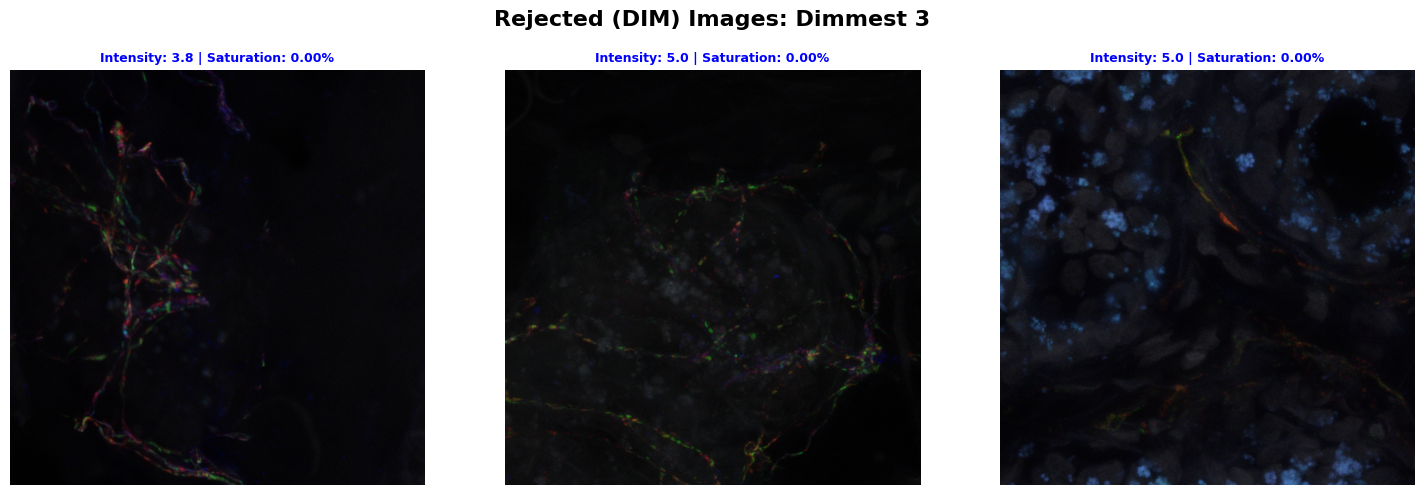


MODE 1: GRID VIEW - Rejected (Bright) Images
✓ Grid saved to images/preprocessing/rejected_inspection/rejected_bright_grid.png



MODE 2: DETAILED SINGLE-IMAGE INSPECTOR
Inspecting dimmest image: MAX_5753 gh2.tif.tif


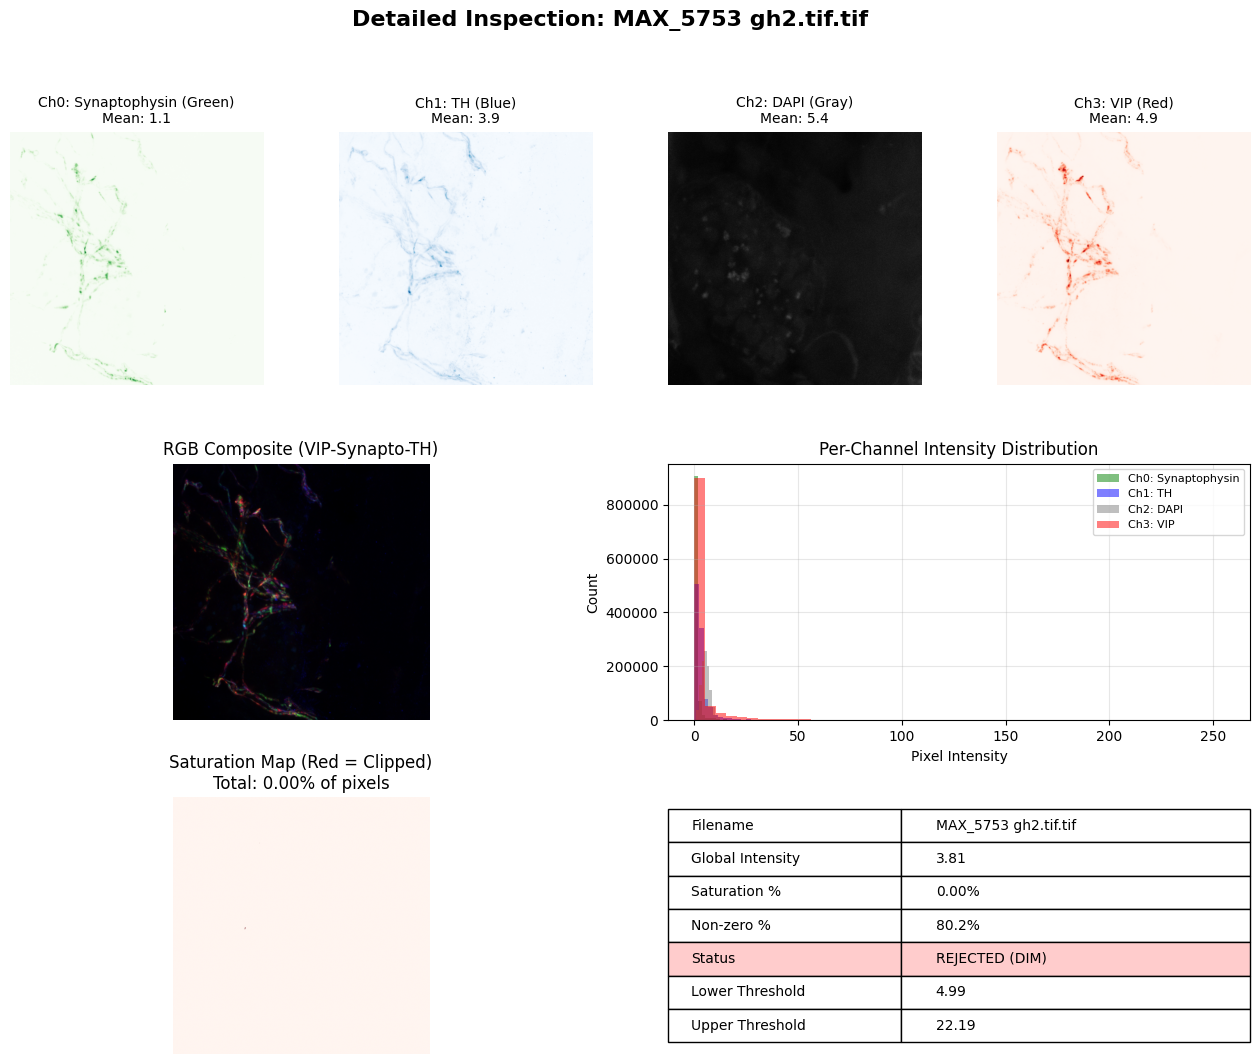


Inspecting most saturated image: MAX_7343.lif - 7343 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh.tif


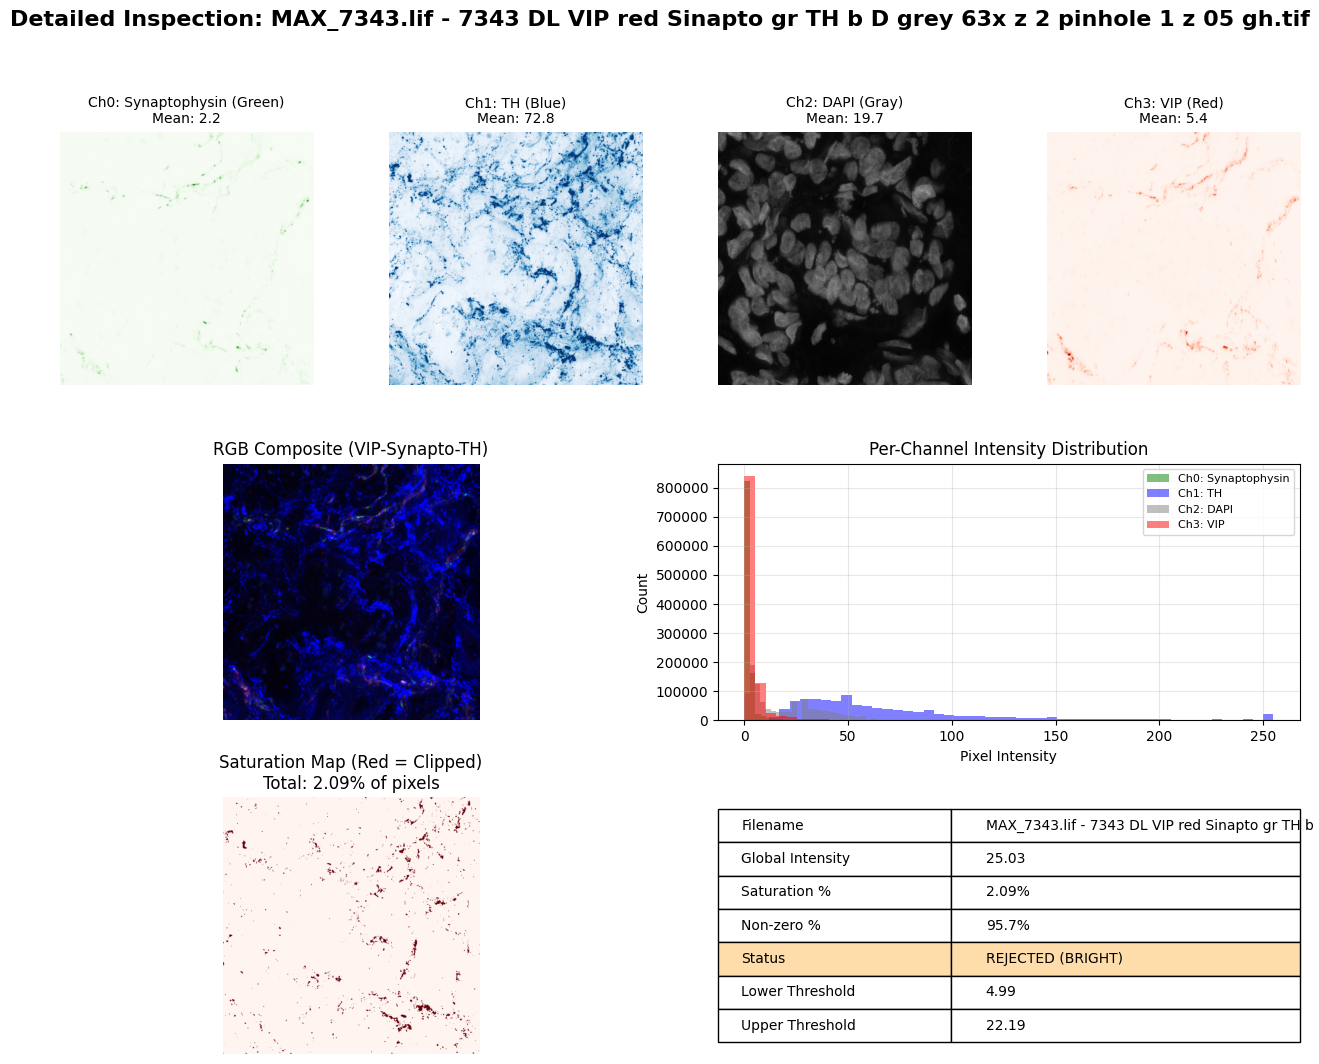


MODE 3: REJECTED OVERLAY ON INTENSITY DISTRIBUTION
✓ Overlay plot saved to images/preprocessing/rejected_inspection/rejected_overlay.png


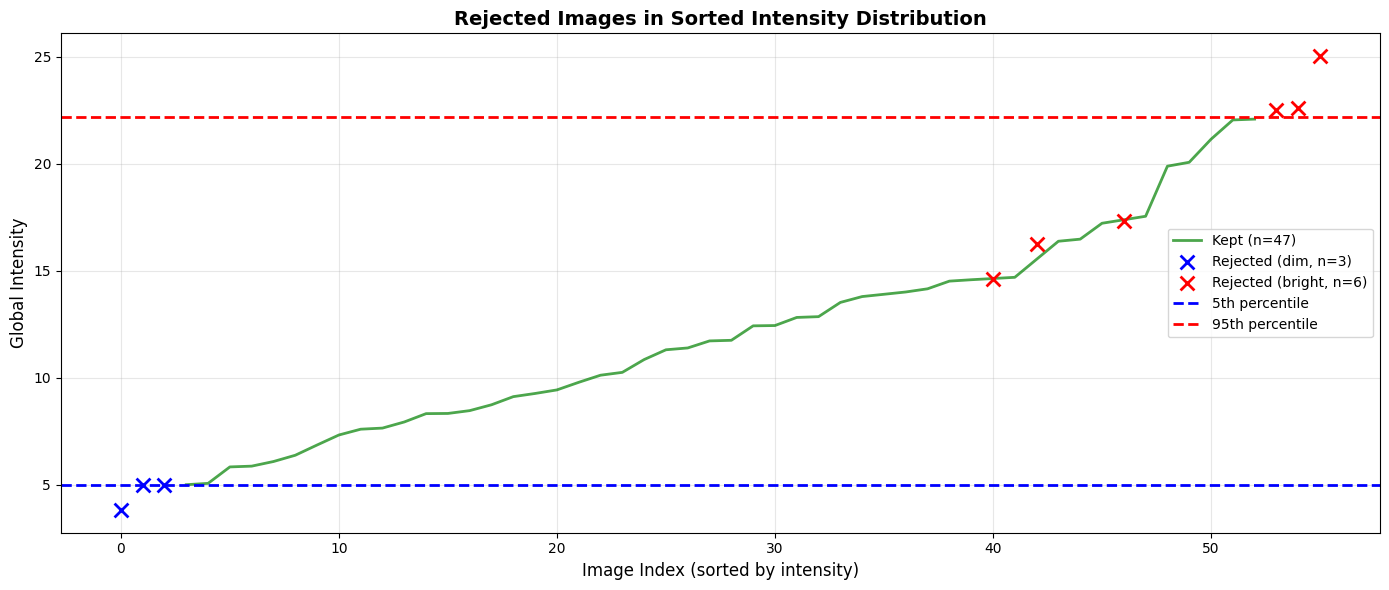


✓ All inspection plots saved to images/preprocessing/rejected_inspection


In [ ]:
"""
Interactive rejection analysis tool for dual-threshold QC pipeline.

This script provides three visualization modes:
1. Grid view: Compare multiple rejected images side-by-side
2. Detailed view: Single-image inspection with per-channel analysis
3. Statistical overlay: Plot rejected images on intensity distributions
"""

from __future__ import annotations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tifffile
from pathlib import Path
from typing import List, Optional, Tuple
from matplotlib.gridspec import GridSpec
import sys
import os

# Add project root to sys.path for local imports
PROJ_ROOT = Path(__file__).resolve().parent.parent if '__file__' in globals() else Path.cwd().parent
if str(PROJ_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJ_ROOT))

# Import your visualization function
from utils.data_visualization_functions import visualize_tiff


# ============================================================================
# MODE 1: GRID VIEW - COMPARE MULTIPLE REJECTED IMAGES USING visualize_tiff
# ============================================================================
def visualize_rejected_images_grid(
    df_rejected: pd.DataFrame,
    num_images: int = 6,
    rejection_type: str = "dim",  # "dim" or "bright"
    output_path: Optional[Path] = None,
    channel_wise_norm: bool = True,
    overlay_alpha: float = 0.35,
) -> None:
    """
    Display a grid of rejected images using your existing visualize_tiff function.
    
    Parameters
    ----------
    df_rejected : pd.DataFrame
        Rejected images dataframe (df_rejected_dim or df_rejected_bright).
    num_images : int
        Number of images to display (default: 6).
    rejection_type : str
        Type of rejection: "dim" or "bright".
    output_path : Path, optional
        Save figure to this path.
    channel_wise_norm : bool
        Whether to apply channel-wise normalization (passed to visualize_tiff).
    overlay_alpha : float
        Alpha transparency for DAPI overlay (passed to visualize_tiff).
        
    Layout
    ------
    - 2 rows × 3 columns grid
    - Each subplot uses your visualize_tiff display logic
    - Title shows: filename + global intensity + saturation %
    - Border color indicates severity (red = saturated, blue = dim)
    """
    if len(df_rejected) == 0:
        print(f"No {rejection_type} rejected images to display.")
        return
    
    # Sample images (prioritize worst offenders)
    if rejection_type == "dim":
        df_sample = df_rejected.nsmallest(num_images, "global_intensity")
    else:  # "bright"
        df_sample = df_rejected.nlargest(num_images, "saturation_fraction")
    
    num_images = min(num_images, len(df_sample))
    ncols = 3
    nrows = int(np.ceil(num_images / ncols))
    
    fig = plt.figure(figsize=(15, 5 * nrows))
    
    for idx, (_, row) in enumerate(df_sample.iterrows()):
        if idx >= num_images:
            break
        
        ax = fig.add_subplot(nrows, ncols, idx + 1)
        img_path = Path(row["path"])
        
        # Load and process image using your min_max_normalization logic
        from utils.data_visualization_functions import min_max_normalization
        
        img = tifffile.imread(img_path)
        
        # Transpose from (C,H,W) to (H,W,C) for matplotlib
        if img.shape[0] <= 4:
            img = np.transpose(img, (1, 2, 0))
        
        # Apply normalization
        scaled_img = min_max_normalization(img, channel_wise=channel_wise_norm)
        
        # Determine channel configuration
        num_channels = img.shape[-1]
        if num_channels == 3:
            # Reorder from [Green, Blue, Red] to [Red, Green, Blue] for display
            display_img = scaled_img[:,:,[2, 0, 1]]
        elif num_channels == 4:
            # Base RGB from [Red, Green, Blue] + Grey overlay
            display_img = scaled_img[:,:,[3, 0, 1]]
            overlay_gray = scaled_img[..., 2]
        else:
            display_img = scaled_img
        
        # Display
        if num_channels <= 3:
            ax.imshow(display_img)
        elif num_channels == 4:
            ax.imshow(display_img)
            ax.imshow(overlay_gray, cmap='gray', alpha=overlay_alpha)
        else:
            ax.imshow(display_img[:,:,:3])
        
        # Diagnostic title
        global_int = row["global_intensity"]
        sat_frac = row["saturation_fraction"]
        title = (
            # f"{img_path.name}\n"
            f"Intensity: {global_int:.1f} | Saturation: {sat_frac:.2%}"
        )
        
        # Color-code border (red = saturated, blue = dim)
        border_color = "red" if sat_frac > 0.01 else "blue"
        ax.set_title(title, fontsize=9, color=border_color, weight="bold")
        ax.axis("off")
        
        # Add colored border
        for spine in ax.spines.values():
            spine.set_edgecolor(border_color)
            spine.set_linewidth(3)
            spine.set_visible(True)
    
    plt.suptitle(
        f"Rejected ({rejection_type.upper()}) Images: "
        f"{'Dimmest' if rejection_type == 'dim' else 'Most Saturated'} {num_images}",
        fontsize=16,
        fontweight="bold",
    )
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    
    if output_path:
        output_path.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(output_path, dpi=300, bbox_inches="tight")
        print(f"✓ Grid saved to {output_path}")
    
    plt.show()


# ============================================================================
# MODE 2: DETAILED SINGLE-IMAGE INSPECTOR
# ============================================================================

def inspect_single_rejected_image(
    img_path: str,
    df_stats: pd.DataFrame,
    config: 'DualThresholdFilterConfig',
    channel_wise_norm: bool = True,
) -> None:
    """
    Detailed diagnostic view for a single rejected image.
    
    Parameters
    ----------
    img_path : str
        Path to rejected image (can copy from df_rejected['path']).
    df_stats : pd.DataFrame
        Full statistics dataframe (df_all from filtering).
    config : DualThresholdFilterConfig
        QC configuration used.
    channel_wise_norm : bool
        Whether to apply channel-wise normalization.
        
    Layout
    ------
    3×4 grid:
    - Row 1: Individual channels (0, 1, 2, 3)
    - Row 2: RGB composite | Per-channel histogram
    - Row 3: Saturation map | Metadata table
    """
    from utils.data_visualization_functions import min_max_normalization
    
    img_path = Path(img_path)
    img = tifffile.imread(img_path)
    
    if img.shape[0] > 4:
        img = np.moveaxis(img, -1, 0)
    
    # Get image stats
    row = df_stats[df_stats["path"] == str(img_path)].iloc[0]
    
    fig = plt.figure(figsize=(16, 12))
    gs = GridSpec(3, 4, figure=fig, hspace=0.3, wspace=0.3)
    
    channel_names = ["Synaptophysin (Green)", "TH (Blue)", "DAPI (Gray)", "VIP (Red)"]
    channel_colors = ["Greens", "Blues", "gray", "Reds"]
    
    # ========================================================================
    # ROW 1: Individual channels
    # ========================================================================
    for ch in range(min(4, img.shape[0])):
        ax = fig.add_subplot(gs[0, ch])
        
        # Apply min-max normalization to each channel
        ch_data = img[ch]
        ch_norm = (ch_data - ch_data.min()) / (ch_data.max() - ch_data.min() + 1e-8)
        
        ax.imshow(ch_norm, cmap=channel_colors[ch])
        ax.set_title(
            f"Ch{ch}: {channel_names[ch]}\n"
            f"Mean: {row[f'ch{ch}_intensity']:.1f}",
            fontsize=10,
        )
        ax.axis("off")
    
    # ========================================================================
    # ROW 2: RGB composite (using your visualization logic) + Histogram
    # ========================================================================
    ax_rgb = fig.add_subplot(gs[1, :2])
    
    # Transpose to (H, W, C)
    img_hwc = np.transpose(img, (1, 2, 0))
    scaled_img = min_max_normalization(img_hwc, channel_wise=channel_wise_norm)
    
    # Create RGB composite following your convention
    num_channels = img.shape[0]
    if num_channels == 3:
        display_img = scaled_img[:,:,[2, 0, 1]]  # R, G, B
    elif num_channels == 4:
        display_img = scaled_img[:,:,[3, 0, 1]]  # R, G, B
        overlay_gray = scaled_img[..., 2]
        ax_rgb.imshow(overlay_gray, cmap='gray', alpha=0.35)
    
    ax_rgb.imshow(display_img)
    ax_rgb.set_title("RGB Composite (VIP-Synapto-TH)", fontsize=12)
    ax_rgb.axis("off")
    
    # Histogram
    ax_hist = fig.add_subplot(gs[1, 2:])
    for ch in range(min(4, img.shape[0])):
        ax_hist.hist(
            img[ch].flatten(),
            bins=50,
            alpha=0.5,
            color=channel_colors[ch].lower().replace("s", ""),
            label=f"Ch{ch}: {channel_names[ch].split('(')[0].strip()}",
        )
    ax_hist.set_xlabel("Pixel Intensity", fontsize=10)
    ax_hist.set_ylabel("Count", fontsize=10)
    ax_hist.set_title("Per-Channel Intensity Distribution", fontsize=12)
    ax_hist.legend(fontsize=8)
    ax_hist.grid(alpha=0.3)
    
    # ========================================================================
    # ROW 3: Saturation map + Metadata table
    # ========================================================================
    ax_sat = fig.add_subplot(gs[2, :2])
    
    # Create binary saturation map
    if img.dtype == np.uint8:
        max_val = 255
    elif img.dtype == np.uint16:
        max_val = 65535
    else:
        max_val = img.max()
    
    sat_map = (img == max_val).any(axis=0).astype(float)
    ax_sat.imshow(sat_map, cmap="Reds", vmin=0, vmax=1)
    ax_sat.set_title(
        f"Saturation Map (Red = Clipped)\n"
        f"Total: {row['saturation_fraction']:.2%} of pixels",
        fontsize=12,
    )
    ax_sat.axis("off")
    
    # Metadata table
    ax_table = fig.add_subplot(gs[2, 2:])
    ax_table.axis("off")
    
    metadata = [
        ["Filename", img_path.name],
        ["Global Intensity", f"{row['global_intensity']:.2f}"],
        ["Saturation %", f"{row['saturation_fraction']:.2%}"],
        ["Non-zero %", f"{row['nonzero_fraction']:.1%}"],
        ["Status", "REJECTED (DIM)" if row['global_intensity'] < config.percentile_threshold else "REJECTED (BRIGHT)"],
        ["Lower Threshold", f"{df_stats['global_intensity'].quantile(0.05):.2f}"],
        ["Upper Threshold", f"{df_stats['global_intensity'].quantile(0.95):.2f}"],
    ]
    
    table = ax_table.table(
        cellText=metadata,
        colWidths=[0.4, 0.6],
        cellLoc="left",
        loc="center",
    )
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)
    
    # Color-code status row
    status_row = 4
    for col in range(2):
        table[(status_row, col)].set_facecolor("#ffcccc" if "DIM" in metadata[status_row][1] else "#ffddaa")
    
    plt.suptitle(
        f"Detailed Inspection: {img_path.name}",
        fontsize=16,
        fontweight="bold",
    )
    plt.show()


# ============================================================================
# MODE 3: OVERLAY REJECTED IMAGES ON INTENSITY DISTRIBUTION
# ============================================================================

def plot_rejected_overlay(
    df_kept: pd.DataFrame,
    df_rejected_dim: pd.DataFrame,
    df_rejected_bright: pd.DataFrame,
    output_path: Optional[Path] = None,
) -> None:
    """
    Scatter plot showing where rejected images fall in the distribution.
    
    Layout
    ------
    - X-axis: Image index (sorted by intensity)
    - Y-axis: Global intensity
    - Green line: Kept images (sorted)
    - Blue X markers: Dim rejected
    - Red X markers: Bright rejected
    - Horizontal lines: Percentile thresholds
    """
    df_all = pd.concat([df_kept, df_rejected_dim, df_rejected_bright])
    df_all = df_all.sort_values("global_intensity").reset_index(drop=True)
    
    fig, ax = plt.subplots(figsize=(14, 6))
    
    # Plot kept images as line
    kept_indices = df_all[df_all["keep"]].index
    ax.plot(
        kept_indices,
        df_all.loc[kept_indices, "global_intensity"],
        color="green",
        linewidth=2,
        alpha=0.7,
        label=f"Kept (n={len(df_kept)})",
    )
    
    # Overlay rejected (dim)
    dim_indices = df_all[df_all["filename"].isin(df_rejected_dim["filename"])].index
    ax.scatter(
        dim_indices,
        df_all.loc[dim_indices, "global_intensity"],
        color="blue",
        marker="x",
        s=100,
        linewidths=2,
        label=f"Rejected (dim, n={len(df_rejected_dim)})",
        zorder=3,
    )
    
    # Overlay rejected (bright)
    bright_indices = df_all[df_all["filename"].isin(df_rejected_bright["filename"])].index
    ax.scatter(
        bright_indices,
        df_all.loc[bright_indices, "global_intensity"],
        color="red",
        marker="x",
        s=100,
        linewidths=2,
        label=f"Rejected (bright, n={len(df_rejected_bright)})",
        zorder=3,
    )
    
    # Thresholds
    lower = df_all["global_intensity"].quantile(0.05)
    upper = df_all["global_intensity"].quantile(0.95)
    ax.axhline(lower, color="blue", linestyle="--", linewidth=2, label="5th percentile")
    ax.axhline(upper, color="red", linestyle="--", linewidth=2, label="95th percentile")
    
    ax.set_xlabel("Image Index (sorted by intensity)", fontsize=12)
    ax.set_ylabel("Global Intensity", fontsize=12)
    ax.set_title(
        "Rejected Images in Sorted Intensity Distribution",
        fontsize=14,
        fontweight="bold",
    )
    ax.legend(fontsize=10)
    ax.grid(alpha=0.3)
    
    if output_path:
        output_path.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(output_path, dpi=300, bbox_inches="tight")
        print(f"✓ Overlay plot saved to {output_path}")
    
    plt.tight_layout()
    plt.show()


# ============================================================================
# USAGE EXAMPLES
# ============================================================================

if __name__ == "__main__":
    # Assuming you've already run the dual-threshold filtering:
    # df_kept, df_rejected_dim, df_rejected_bright = filter_images_with_dual_thresholds(...)
    
    OUTPUT_DIR = Path("images/preprocessing/rejected_inspection")
    
    # ========================================================================
    # 1) GRID VIEW: Compare 6 dimmest rejected images
    # ========================================================================
    print("=" * 80)
    print("MODE 1: GRID VIEW - Rejected (Dim) Images")
    print("=" * 80)
    visualize_rejected_images_grid(
        df_rejected=df_rejected_dim,
        num_images=6,
        rejection_type="dim",
        output_path=OUTPUT_DIR / "rejected_dim_grid.png",
        channel_wise_norm=True,  # Use your preferred normalization
    )
    
    # ========================================================================
    # 2) GRID VIEW: Compare 6 most saturated rejected images
    # ========================================================================
    print("\n" + "=" * 80)
    print("MODE 1: GRID VIEW - Rejected (Bright) Images")
    print("=" * 80)
    visualize_rejected_images_grid(
        df_rejected=df_rejected_bright,
        num_images=6,
        rejection_type="bright",
        output_path=OUTPUT_DIR / "rejected_bright_grid.png",
        channel_wise_norm=True,
    )
    
    # ========================================================================
    # 3) DETAILED INSPECTION: Single image analysis
    # ========================================================================
    print("\n" + "=" * 80)
    print("MODE 2: DETAILED SINGLE-IMAGE INSPECTOR")
    print("=" * 80)
    
    # Inspect the worst rejected (dim) image
    if len(df_rejected_dim) > 0:
        worst_dim_path = df_rejected_dim.nsmallest(1, "global_intensity")["path"].iloc[0]
        print(f"Inspecting dimmest image: {Path(worst_dim_path).name}")
        inspect_single_rejected_image(
            img_path=worst_dim_path,
            df_stats=pd.concat([df_kept, df_rejected_dim, df_rejected_bright]),
            config=config,  # Use your DualThresholdFilterConfig
            channel_wise_norm=True,
        )
    
    # Inspect the worst rejected (bright) image
    if len(df_rejected_bright) > 0:
        worst_bright_path = df_rejected_bright.nlargest(1, "saturation_fraction")["path"].iloc[0]
        print(f"\nInspecting most saturated image: {Path(worst_bright_path).name}")
        inspect_single_rejected_image(
            img_path=worst_bright_path,
            df_stats=pd.concat([df_kept, df_rejected_dim, df_rejected_bright]),
            config=config,
        )
    
    # ========================================================================
    # 4) OVERLAY PLOT: Show rejected images in sorted distribution
    # ========================================================================
    print("\n" + "=" * 80)
    print("MODE 3: REJECTED OVERLAY ON INTENSITY DISTRIBUTION")
    print("=" * 80)
    plot_rejected_overlay(
        df_kept=df_kept,
        df_rejected_dim=df_rejected_dim,
        df_rejected_bright=df_rejected_bright,
        output_path=OUTPUT_DIR / "rejected_overlay.png",
    )
    
    print(f"\n✓ All inspection plots saved to {OUTPUT_DIR}")

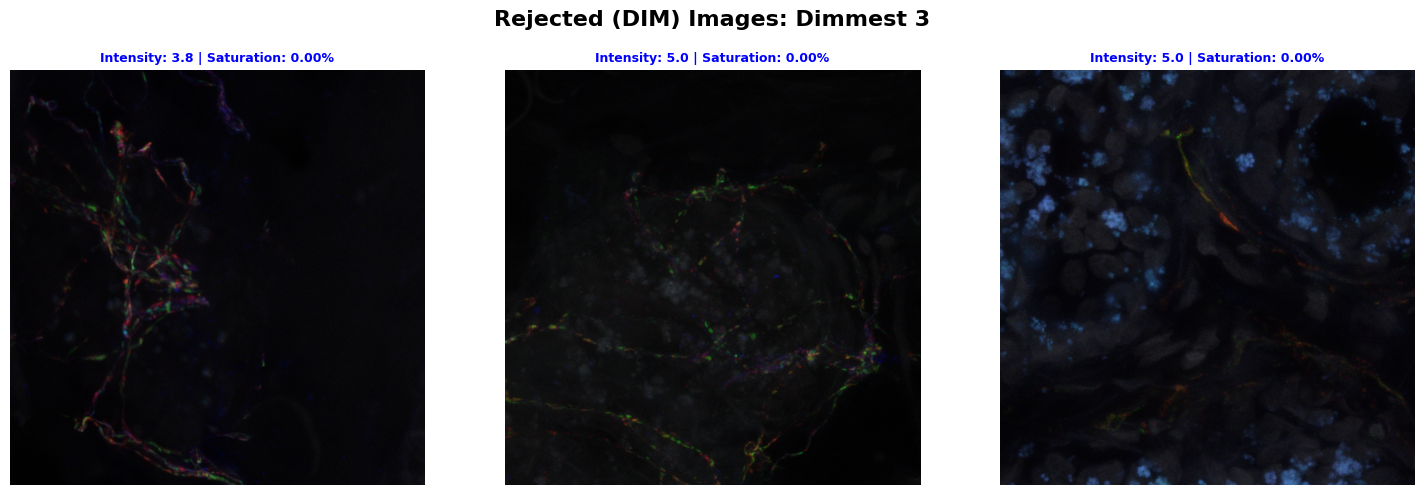

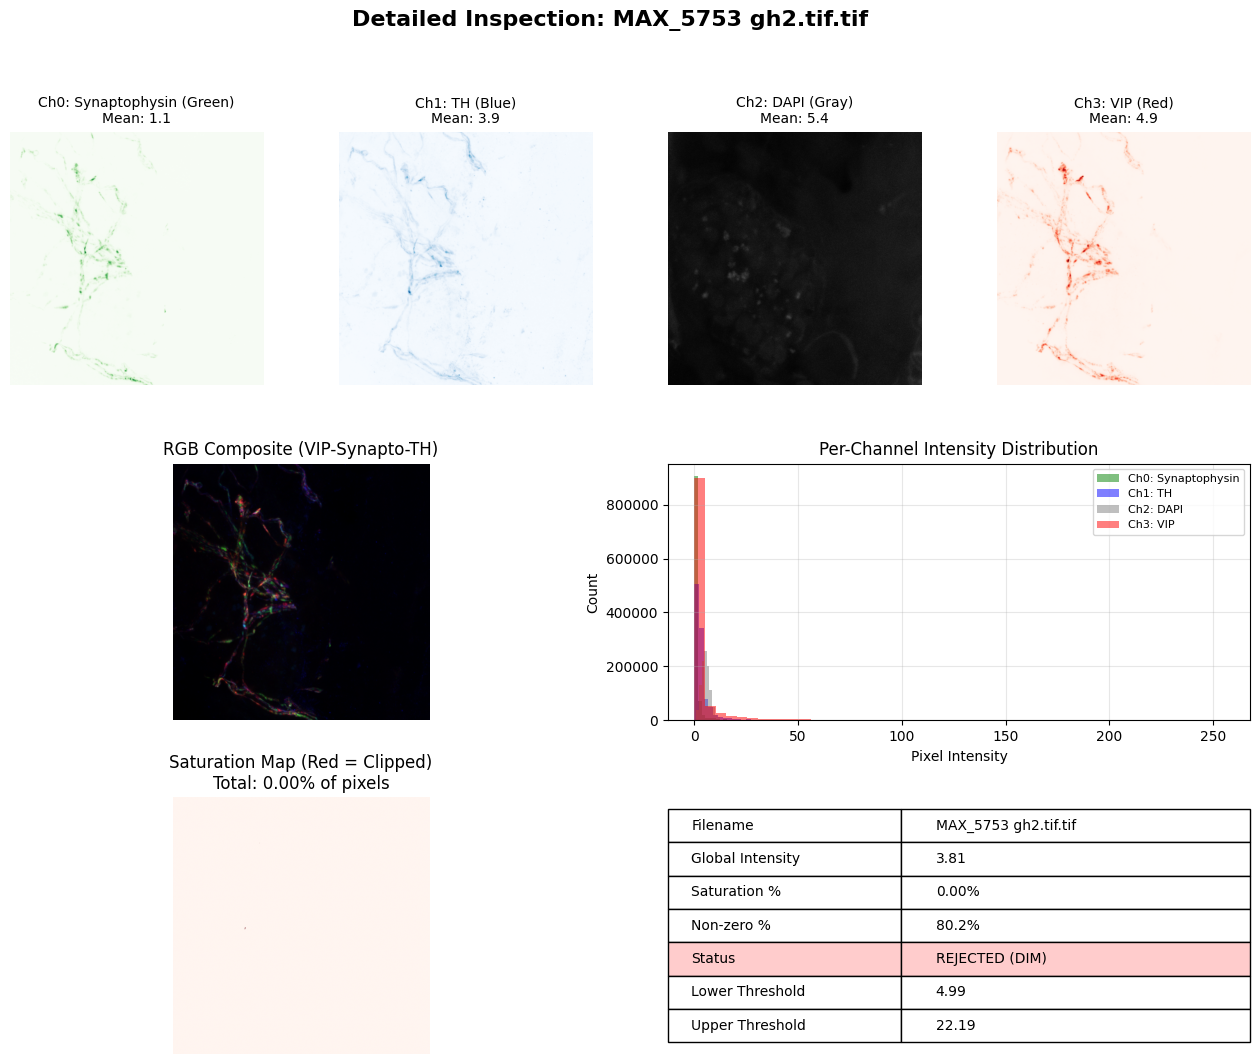

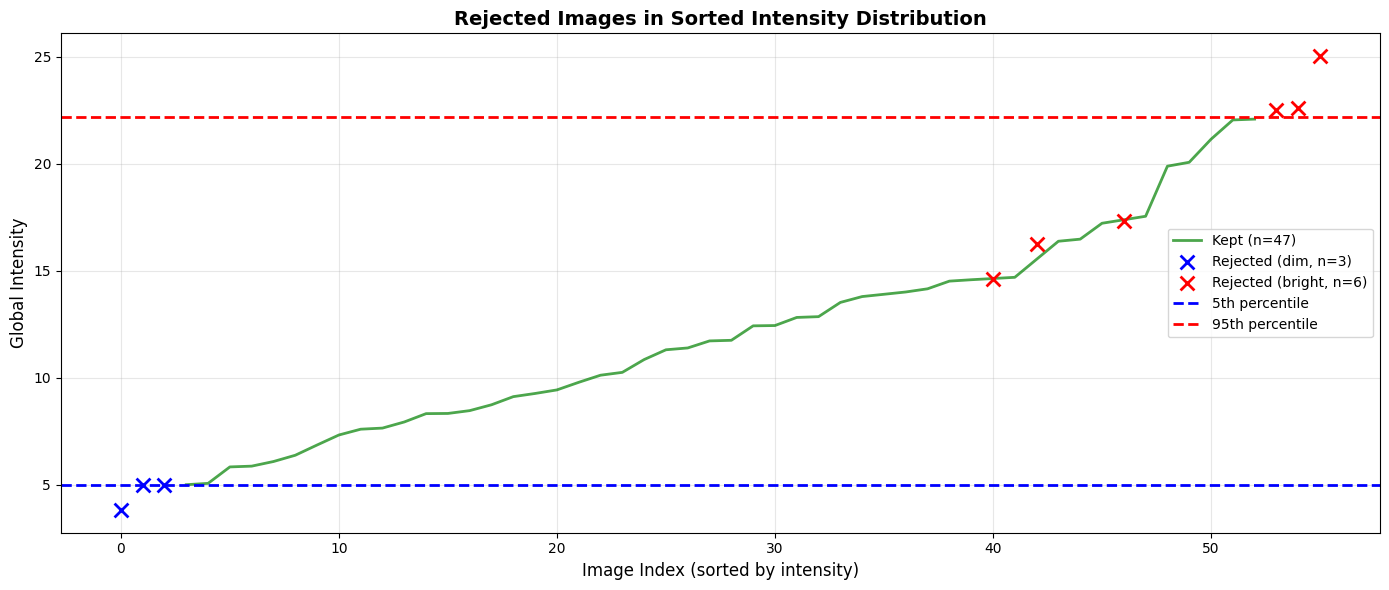

In [ ]:
# After running your dual-threshold filtering, add this cell:

# 1) Grid view of 6 dimmest images
visualize_rejected_images_grid(
    df_rejected=df_rejected_dim,
    num_images=6,
    rejection_type="dim",
)

# 2) Grid view of 6 most saturated images
visualize_rejected_images_grid(
    df_rejected=df_rejected_bright,
    num_images=6,
    rejection_type="bright",
)

# 3) Detailed inspection of worst dim image
worst_dim = df_rejected_dim.nsmallest(1, "global_intensity")["path"].iloc[0]
inspect_single_rejected_image(
    img_path=worst_dim,
    df_stats=pd.concat([df_kept, df_rejected_dim, df_rejected_bright]),
    config=config,
)

# 4) Overlay plot
plot_rejected_overlay(df_kept, df_rejected_dim, df_rejected_bright)

## ENVIRONMENT DEPENDENCIES USED

In [ ]:
"""
Extract library versions for thesis documentation.

This script generates a comprehensive list of all Python packages used in
the project, formatted for inclusion in the thesis Methods section or appendix.

Scientific justification:
- Ensures reproducibility of computational experiments
- Meets journal standards for software transparency (Nature, IEEE, MICCAI)
- Documents exact versions to prevent dependency conflicts
"""

from __future__ import annotations
import sys
import platform
from pathlib import Path
from typing import Dict, List, Tuple
import subprocess
import importlib.metadata
import pandas as pd


# ============================================================================
# CORE DEPENDENCY EXTRACTION
# ============================================================================

def get_python_version() -> str:
    """Return Python version string (e.g., '3.10.12')."""
    return platform.python_version()


def get_cuda_version() -> str:
    """Attempt to detect CUDA version via nvidia-smi."""
    try:
        result = subprocess.run(
            ["nvidia-smi", "--query-gpu=driver_version", "--format=csv,noheader"],
            capture_output=True,
            text=True,
            timeout=5,
        )
        if result.returncode == 0:
            return result.stdout.strip()
    except (FileNotFoundError, subprocess.TimeoutExpired):
        pass
    return "Not detected"


def get_installed_packages() -> List[Tuple[str, str]]:
    """
    Get all installed packages and their versions.
    
    Returns
    -------
    List[Tuple[str, str]]
        List of (package_name, version) tuples sorted alphabetically.
    """
    packages = []
    for dist in importlib.metadata.distributions():
        packages.append((dist.name, dist.version))
    
    return sorted(packages, key=lambda x: x[0].lower())


def get_key_dependencies() -> Dict[str, str]:
    """
    Extract versions of critical packages used in your thesis.
    
    Returns
    -------
    Dict[str, str]
        Maps package name to version string.
        
    Notes
    -----
    This list is manually curated based on your project's requirements.
    Add/remove packages as needed.
    """
    key_packages = [
        # Deep learning frameworks
        "torch",
        "torchvision",
        "monai",
        "timm",
        "pytorch-lightning",
        "lightly",
        
        # Scientific computing
        "numpy",
        "scipy",
        "pandas",
        "scikit-learn",
        
        # Image processing
        "tifffile",
        "imageio",
        "opencv-python",
        "pillow",
        
        # Visualization
        "matplotlib",
        "seaborn",
        
        # Experiment tracking
        "mlflow",
        
        # Utilities
        "tqdm",
        "pyyaml",
        "openpyxl",
    ]
    
    versions = {}
    for pkg in key_packages:
        try:
            # Try exact name first
            version = importlib.metadata.version(pkg)
            versions[pkg] = version
        except importlib.metadata.PackageNotFoundError:
            # Try normalized name (e.g., opencv-python → opencv_python)
            try:
                normalized = pkg.replace("-", "_")
                version = importlib.metadata.version(normalized)
                versions[pkg] = version
            except importlib.metadata.PackageNotFoundError:
                versions[pkg] = "Not installed"
    
    return versions


# ============================================================================
# FORMATTING FOR THESIS
# ============================================================================

def format_as_latex_table(key_deps: Dict[str, str]) -> str:
    """
    Generate LaTeX table code for thesis appendix.
    
    Returns
    -------
    str
        LaTeX tabular environment with package versions.
        
    Example Output
    --------------
    \\begin{table}[htbp]
    \\centering
    \\caption{Software Dependencies}
    \\label{tab:dependencies}
    \\begin{tabular}{ll}
    \\toprule
    Package & Version \\\\
    \\midrule
    PyTorch & 2.1.0+cu121 \\\\
    MONAI & 1.3.0 \\\\
    ...
    \\bottomrule
    \\end{tabular}
    \\end{table}
    """
    latex = [
        "\\begin{table}[htbp]",
        "\\centering",
        "\\caption{Software Dependencies for Deep Learning Experiments}",
        "\\label{tab:dependencies}",
        "\\begin{tabular}{ll}",
        "\\toprule",
        "\\textbf{Package} & \\textbf{Version} \\\\",
        "\\midrule",
    ]
    
    for pkg, ver in key_deps.items():
        # Escape underscores for LaTeX
        pkg_escaped = pkg.replace("_", "\\_")
        ver_escaped = ver.replace("_", "\\_")
        latex.append(f"{pkg_escaped} & {ver_escaped} \\\\")
    
    latex.extend([
        "\\bottomrule",
        "\\end{tabular}",
        "\\end{table}",
    ])
    
    return "\n".join(latex)


def format_as_markdown_table(key_deps: Dict[str, str]) -> str:
    """
    Generate Markdown table for README or supplementary materials.
    
    Returns
    -------
    str
        Markdown table with package versions.
    """
    lines = [
        "| Package | Version |",
        "|---------|---------|",
    ]
    
    for pkg, ver in key_deps.items():
        lines.append(f"| {pkg} | {ver} |")
    
    return "\n".join(lines)


def generate_environment_yml(
    key_deps: Dict[str, str],
    env_name: str = "thesis_env",
) -> str:
    """
    Generate Conda environment.yml file for reproducibility.
    
    Parameters
    ----------
    key_deps : Dict[str, str]
        Package versions.
    env_name : str
        Name for the conda environment.
        
    Returns
    -------
    str
        YAML content for environment.yml file.
    """
    yaml_lines = [
        f"name: {env_name}",
        "channels:",
        "  - pytorch",
        "  - conda-forge",
        "  - defaults",
        "dependencies:",
        f"  - python={get_python_version()}",
    ]
    
    for pkg, ver in key_deps.items():
        if ver != "Not installed":
            # Convert PyPI names to conda names if needed
            conda_pkg = pkg.replace("opencv-python", "opencv")
            yaml_lines.append(f"  - {conda_pkg}={ver}")
    
    return "\n".join(yaml_lines)


def save_to_requirements_txt(
    all_packages: List[Tuple[str, str]],
    output_path: Path,
) -> None:
    """
    Generate requirements.txt file (standard pip format).
    
    Parameters
    ----------
    all_packages : List[Tuple[str, str]]
        Full list of installed packages.
    output_path : Path
        Where to save requirements.txt.
    """
    output_path.parent.mkdir(parents=True, exist_ok=True)
    
    with open(output_path, "w") as f:
        f.write("# Python dependencies for thesis project\n")
        f.write(f"# Generated on: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"# Python version: {get_python_version()}\n\n")
        
        for pkg, ver in all_packages:
            f.write(f"{pkg}=={ver}\n")
    
    print(f"✓ Full requirements saved to {output_path}")


# ============================================================================
# THESIS-READY SUMMARY
# ============================================================================

def print_thesis_summary(key_deps: Dict[str, str]) -> None:
    """
    Print formatted summary for direct copy-paste into thesis.
    
    Generates:
    1. Text paragraph for Methods section
    2. LaTeX table for Appendix
    3. Markdown table for README
    """
    print("=" * 80)
    print("SOFTWARE ENVIRONMENT SUMMARY (FOR THESIS)")
    print("=" * 80)
    
    # ========================================================================
    # 1) SYSTEM INFORMATION
    # ========================================================================
    print("\n### System Configuration ###")
    print(f"Python version:     {get_python_version()}")
    print(f"Operating system:   {platform.system()} {platform.release()}")
    print(f"Architecture:       {platform.machine()}")
    print(f"CUDA driver:        {get_cuda_version()}")
    
    # ========================================================================
    # 2) KEY DEPENDENCIES (for Methods section)
    # ========================================================================
    print("\n### Core Dependencies ###")
    print("(Copy this list into your thesis Methods section)\n")
    
    # Group packages by category
    categories = {
        "Deep Learning": ["torch", "torchvision", "monai", "timm", "pytorch-lightning", "lightly"],
        "Scientific Computing": ["numpy", "scipy", "pandas", "scikit-learn"],
        "Image Processing": ["tifffile", "imageio", "opencv-python", "pillow"],
        "Visualization": ["matplotlib", "seaborn"],
        "Experiment Tracking": ["mlflow"],
    }
    
    for category, packages in categories.items():
        print(f"\n**{category}:**")
        for pkg in packages:
            ver = key_deps.get(pkg, "Not installed")
            if ver != "Not installed":
                print(f"  - {pkg}: {ver}")
    
    # ========================================================================
    # 3) TEXT PARAGRAPH (for Methods section)
    # ========================================================================
    print("\n" + "=" * 80)
    print("SUGGESTED TEXT FOR THESIS METHODS SECTION")
    print("=" * 80)
    print(f"""
All experiments were conducted using Python {get_python_version()} on a 
{platform.system()} {platform.release()} system. Deep learning models were 
implemented using PyTorch {key_deps.get('torch', 'X.X.X')} with CUDA acceleration 
(driver version: {get_cuda_version()}). Medical image preprocessing leveraged 
MONAI {key_deps.get('monai', 'X.X.X')}, a domain-specific framework for biomedical 
imaging. Pre-trained model weights were loaded from the timm library 
{key_deps.get('timm', 'X.X.X')}. Self-supervised learning experiments utilized 
Lightly {key_deps.get('lightly', 'X.X.X')} for contrastive learning implementations.

Data manipulation was performed using NumPy {key_deps.get('numpy', 'X.X.X')}, 
Pandas {key_deps.get('pandas', 'X.X.X')}, and scikit-learn {key_deps.get('scikit-learn', 'X.X.X')}. 
Multi-channel TIFF images were handled via tifffile {key_deps.get('tifffile', 'X.X.X')}. 
Experiment tracking and hyperparameter logging employed MLflow {key_deps.get('mlflow', 'X.X.X')}.

For complete reproducibility, the full dependency list is available in 
Appendix A (Table X) and as a pip-installable requirements file in the 
project repository.
""")
    
    # ========================================================================
    # 4) LATEX TABLE (for Appendix)
    # ========================================================================
    print("\n" + "=" * 80)
    print("LATEX TABLE CODE (for Appendix)")
    print("=" * 80)
    print(format_as_latex_table(key_deps))
    
    # ========================================================================
    # 5) MARKDOWN TABLE (for README)
    # ========================================================================
    print("\n" + "=" * 80)
    print("MARKDOWN TABLE (for GitHub README)")
    print("=" * 80)
    print(format_as_markdown_table(key_deps))


# ============================================================================
# MAIN EXECUTION
# ============================================================================

if __name__ == "__main__":
    OUTPUT_DIR = Path("/home/zano/Documents/TESI/FOLDER_CINECA/thesis_docs")
    
    # 1) Extract key dependencies
    key_deps = get_key_dependencies()
    
    # 2) Print thesis-ready summary
    print_thesis_summary(key_deps)
    
    # 3) Save full requirements.txt
    all_packages = get_installed_packages()
    save_to_requirements_txt(
        all_packages,
        output_path=OUTPUT_DIR / "requirements_full.txt",
    )
    
    # 4) Generate environment.yml for conda users
    env_yml = generate_environment_yml(key_deps)
    env_yml_path = OUTPUT_DIR / "environment.yml"
    env_yml_path.parent.mkdir(parents=True, exist_ok=True)
    with open(env_yml_path, "w") as f:
        f.write(env_yml)
    print(f"✓ Conda environment file saved to {env_yml_path}")
    
    # 5) Save LaTeX table to file
    latex_table = format_as_latex_table(key_deps)
    latex_path = OUTPUT_DIR / "dependencies_table.tex"
    with open(latex_path, "w") as f:
        f.write(latex_table)
    print(f"✓ LaTeX table saved to {latex_path}")
    
    # 6) Save Markdown table to file
    md_table = format_as_markdown_table(key_deps)
    md_path = OUTPUT_DIR / "dependencies_table.md"
    with open(md_path, "w") as f:
        f.write("# Software Dependencies\n\n")
        f.write(md_table)
    print(f"✓ Markdown table saved to {md_path}")
    
    print(f"\n✓ All documentation saved to {OUTPUT_DIR}")

SOFTWARE ENVIRONMENT SUMMARY (FOR THESIS)

### System Configuration ###
Python version:     3.12.3
Operating system:   Linux 6.14.0-35-generic
Architecture:       x86_64
CUDA driver:        580.95.05

### Core Dependencies ###
(Copy this list into your thesis Methods section)


**Deep Learning:**
  - torch: 2.10.0.dev20251008+cu128
  - torchvision: 0.25.0.dev20251008+cu128
  - monai: 1.4.0
  - timm: 0.4.12
  - pytorch-lightning: 2.5.1
  - lightly: 1.5.19

**Scientific Computing:**
  - numpy: 2.3.3
  - scipy: 1.15.1
  - pandas: 2.2.3
  - scikit-learn: 1.6.1

**Image Processing:**
  - tifffile: 2025.1.10
  - imageio: 2.37.0
  - opencv-python: 4.11.0.86
  - pillow: 11.3.0

**Visualization:**
  - matplotlib: 3.10.0
  - seaborn: 0.13.2

**Experiment Tracking:**
  - mlflow: 2.20.1

SUGGESTED TEXT FOR THESIS METHODS SECTION

All experiments were conducted using Python 3.12.3 on a 
Linux 6.14.0-35-generic system. Deep learning models were 
implemented using PyTorch 2.10.0.dev20251008+cu128 wit